# Projet Deep Learning - Pr√©diction de la valeur fonci√®re (r√©gression)

## 1. Connexion √† la base de donn√©es et chargement des donn√©es

In [1]:
#%pip install pandas
#%pip install sqlalchemy
#%pip install psycopg2

import pandas as pd
from sqlalchemy import create_engine

# Param√®tres de connexion
username = "spark"
password = "spark123"
host = "localhost"
port = 5432
database = "projet_final"

# Cha√Æne de connexion SQLAlchemy
engine = create_engine(f"postgresql://{username}:{password}@{host}:{port}/{database}")

# Lecture de la table en DataFrame pandas
df = pd.read_sql("SELECT * FROM public.silver_resultats", engine)
 
print(df.head())
print(df.info())

                                           id_unique code_postal  \
0  03996b55c28a97dca19b612f691f05363e65b70b5ba248...       42000   
1  649944a1fdfff0c80ff1b6b8a589f358efd8af34aa3165...       85300   
2  03fad8d151df184bd51784b19555a26115109979ab9caa...       33400   
3  4bc48634e27c58338cdfc37a90227aecb2df613e438bdd...       69310   
4  62035780c1d712ad51911092d9fc41913c44a9c0dd651e...       54370   

         commune date_mutation         fichier_source  \
0  SAINT-ETIENNE    2020-01-06  ValeursFoncieres-2020   
1       CHALLANS    2020-01-06  ValeursFoncieres-2020   
2        TALENCE    2020-01-23  ValeursFoncieres-2020   
3  PIERRE BENITE    2020-01-13  ValeursFoncieres-2020   
4      DEUXVILLE    2020-01-28  ValeursFoncieres-2020   

                      nature_mutation  nombre_pieces_principales  \
0                               Vente                          0   
1                               Vente                          0   
2                               Vente       

Nous voyons bien ici que nos donn√©es sont correctement r√©cup√©r√©es.

## 2. Etude des composants de la base de donn√©es

In [2]:
print("Shape :", df.shape)
print("\nTypes de variables :\n", df.dtypes)
print("\nPourcentage de valeurs manquantes :\n", df.isnull().mean() * 100)

Shape : (9343162, 11)

Types de variables :
 id_unique                     object
code_postal                   object
commune                       object
date_mutation                 object
fichier_source                object
nature_mutation               object
nombre_pieces_principales      int64
surface_reelle_bati          float64
type_local                    object
valeur_fonciere              float64
part_date                     object
dtype: object

Pourcentage de valeurs manquantes :
 id_unique                    0.0
code_postal                  0.0
commune                      0.0
date_mutation                0.0
fichier_source               0.0
nature_mutation              0.0
nombre_pieces_principales    0.0
surface_reelle_bati          0.0
type_local                   0.0
valeur_fonciere              0.0
part_date                    0.0
dtype: float64


Nous pouvons constater ici que notre premier travail de nettoyage √† bien fonctionn√©, nous n'avons pas de valeurs manquantes (ou tr√®s peu).

In [3]:
# Statistiques sur variables cat√©gorielles (exemples)
print("\nCommune les plus fr√©quentes :\n", df['commune'].value_counts().head(10))
print("\nTypes locaux :\n", df['type_local'].value_counts())
print("\nNature mutation :\n", df['nature_mutation'].value_counts())


Commune les plus fr√©quentes :
 commune
TOULOUSE         82155
NICE             65974
NANTES           48464
MONTPELLIER      48396
BORDEAUX         41283
RENNES           32941
LILLE            32696
DIJON            31363
SAINT-ETIENNE    28807
GRENOBLE         27992
Name: count, dtype: int64

Types locaux :
 type_local
                                            2552831
Maison                                      2302413
D√©pendance                                  2260944
Appartement                                 1882863
Local industriel. commercial ou assimil√©     344111
Name: count, dtype: int64

Nature mutation :
 nature_mutation
Vente                                 8734045
Vente en l'√©tat futur d'ach√®vement     497014
Echange                                 56448
Vente terrain √† b√¢tir                   29316
Adjudication                            24902
Expropriation                            1437
Name: count, dtype: int64


Nous pouvons ainsi avoir un premeir apper√ßu de la quantit√© de donn√©es que nous allons traiter.  
Maintenant, nous allons nous attaquer √† la pr√©diction. Pour cela, nous devons d√©finir quelle sera notre cible et qu'est ce que nous voulons pr√©dire.  

Ainsi, nous savons que notre jeu de donn√©e traite les transactions immobili√®res fran√ßaises de 2020 √† 2024. Nous pouvons donc essayer de faire une pr√©diction sur les ann√©es prochaines. Pour cela, nous allons donc d√©finir notre target sur la colonne 'valeur_fonciere', qui contient les montants des diff√©rentes transactions.  

Pour commencer, on va v√©rifier que notre colonne est parfaitement clean, c'est √† dire qu'il n'existe aucune valerurs ab√©rantes.

In [4]:
nb_valeurs_aberrantes = (df["valeur_fonciere"] > 500_000_000).sum()
print(f"Nombre de valeurs > 500 000 000 : {nb_valeurs_aberrantes}")

Nombre de valeurs > 500 000 000 : 15


Ici, on a regard√© s'il y avait des valeurs sup√©rieures √† 500M de valeurs fonci√®res. Comme le chiffre est petit, on va v√©rifier un par un ces √©lements pour √™tre s√ªr que ce ne sont pas de fausses valeurs.

In [5]:
valeurs_aberrantes = df[df["valeur_fonciere"] > 500_000_000]
print(valeurs_aberrantes)

                                                 id_unique code_postal  \
2047976  486f1eb0520c8ae49ceadae8c865c0ce90d149e439112f...       92130   
4172096  c3fa7bf0bad1e691b63426e16b94ba9d9420ab7d6cc834...       13008   
5595059  182e824ae2859fbc785028e60144ba6101184d4129ce6e...       64000   
5963544  7728bc9d14e3407c167a881af6e95c6b21767f59fc7f4c...       75008   
6123335  39029100158d6615627fafdd02963fd7ef6f00009edc73...       75008   
6192949  244cb2b8dd4892c4f7d1351555a87d8bb3586f3caf4f92...       75008   
6683548  8271ecc785bee4da7e4a339eddd263333bb2ba689b9e3a...       59700   
6790503  82e9420d5de8781bfd4aff372e1aae402582d07cfb6381...       59700   
7075149  9b92949ee9b9ae499ac8eaf61d025b0283e56514076628...       75013   
7123258  fb89b35f27168c3c9a0e3b3830785581bfde3317606b58...               
7301326  74b72ea72f13ede22c378be9102c8c3a413007ae0ac3c9...       75001   
7306473  138128bd3aa2626832e53f545c384d81d5b509ad64b926...       75001   
7395334  9b33646945097a6d05803d8119a08

On peut voir ici que les chiffres semblent bizarres. Pour √©viter tout probl√®me, on va retirer ces valeurs qui sont probablement des erreurs.

In [6]:
print(f"Nombre de lignes avant filtrage : {len(df)}")
seuil = 500_000_000

df = df[df["valeur_fonciere"] <= seuil]
print(f"Nombre de lignes apr√®s filtrage : {len(df)}")

Nombre de lignes avant filtrage : 9343162
Nombre de lignes apr√®s filtrage : 9343147


Nous avions 9343162 lignes avant le filtrages, et nous en avons 9343147 maintenant, ce qui correspond bien au 15 valeurs ab√©rantes que nous avions trouv√©es.

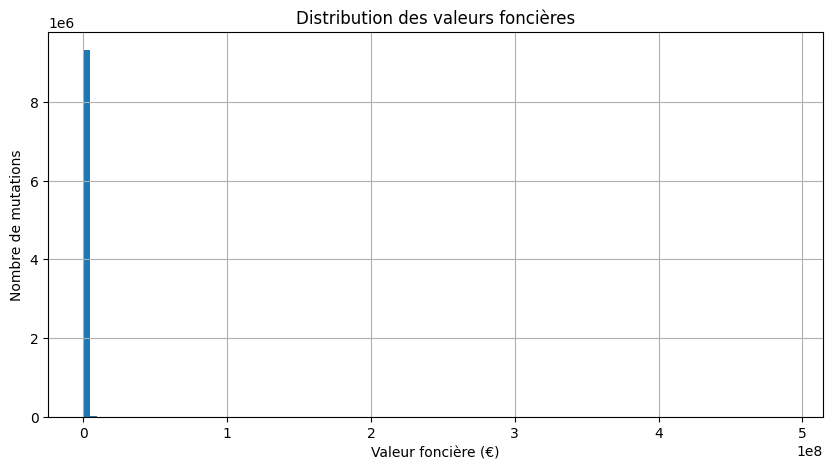

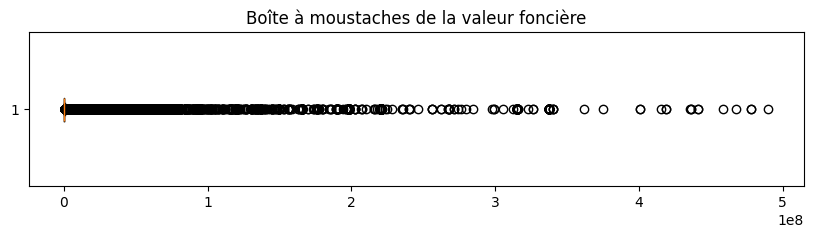

In [7]:
#%pip install matplotlib

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
df['valeur_fonciere'].hist(bins=100)
plt.title("Distribution des valeurs fonci√®res")
plt.xlabel("Valeur fonci√®re (‚Ç¨)")
plt.ylabel("Nombre de mutations")
plt.show()

plt.figure(figsize=(10,2))
plt.boxplot(df['valeur_fonciere'].dropna(), vert=False)
plt.title("Bo√Æte √† moustaches de la valeur fonci√®re")
plt.show()


Ce code nous permet de voir la disperssion des valeurs de notre dataset. C'est tr√®s int√©ressant car nous pouvons voir que, logiquement, l'immense partie des transations effectu√©es sont dites 'faibles', et qu'il reste encore certaines valeurs √©normes qui peuvent affecter notre future prediction.  
Nous pouvons donc alors aller plus loin dans notre travail de nettoyage en retirant encore plus de valeurs ab√©rantes.

In [8]:
nb_valeurs_aberrantes = (df["valeur_fonciere"] > 2_000_000).sum()
print(f"Nombre de valeurs > 2 000 000 : {nb_valeurs_aberrantes}")

Nombre de valeurs > 2 000 000 : 66968


In [9]:
nv_seuil = 2_000_000

df_clean = df[df["valeur_fonciere"] <= nv_seuil]
print(f"Nombre de lignes apr√®s filtrage : {len(df_clean)}")

Nombre de lignes apr√®s filtrage : 9276179


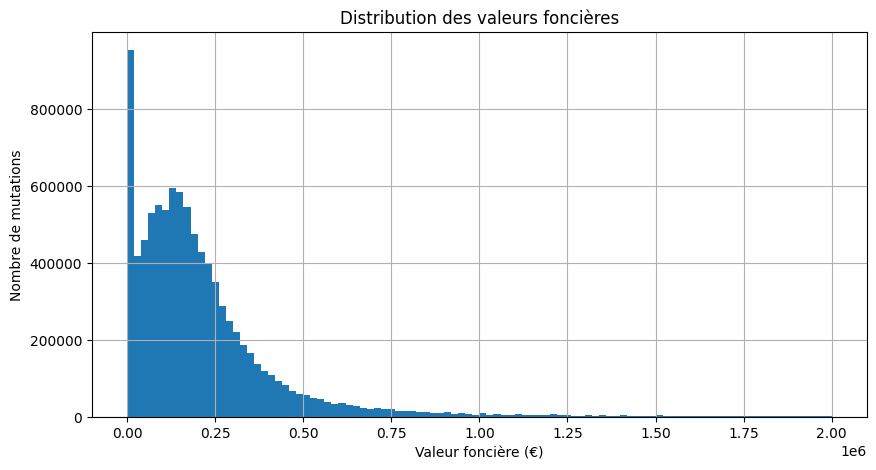

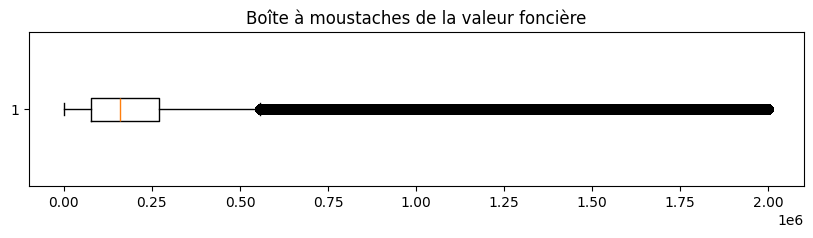

In [10]:
plt.figure(figsize=(10,5))
df_clean['valeur_fonciere'].hist(bins=100)
plt.title("Distribution des valeurs fonci√®res")
plt.xlabel("Valeur fonci√®re (‚Ç¨)")
plt.ylabel("Nombre de mutations")
plt.show()

plt.figure(figsize=(10,2))
plt.boxplot(df_clean['valeur_fonciere'].dropna(), vert=False)
plt.title("Bo√Æte √† moustaches de la valeur fonci√®re")
plt.show()

Maintenant qu'on √† supprim√© les valeurs ab√©rantes sup√©rieures, il faut faire le m√™me processur pour les valeurs faibles, car on peut voir sur le graphique qu'une √©crasante majorit√©es des valeurs sont tr√®s basses.  
Nous allons donc commencer par regarder les valeurs inf√©rieures √† 10 000‚Ç¨. Nous avons choisis ce chiffre car une transaction immobili√®re inf√©rieure √† ce chiffre est probablement douteuse.  
Egalement, nous avons d√©cid√© de scinder le dataset en trois, pour pouvoir analyser diff√©rement les donn√©es car les ordres de grandeurs sont tr√®s diff√©rents, et toutes ces donn√©es sont int√©ressantes √† analyser.

In [11]:
# Dataset 1 : transactions courantes
df_1 = df_clean[(df_clean['valeur_fonciere'] >= 10_000) & (df_clean['valeur_fonciere'] <= 470_000)]

# Dataset 2 : transactions semi √©lev√©es (ex: tr√®s grandes maisons)
df_2 = df_clean[(df_clean['valeur_fonciere'] >= 470_000) & (df_clean['valeur_fonciere'] <= 1_300_000)]

# Dataset 3 : transactions √©lev√©es (ex: biens d'exception)
df_3 = df_clean[(df_clean['valeur_fonciere'] >= 1_300_000) & (df_clean['valeur_fonciere'] <= 2_000_000)]

De cette mani√®re, on peut a pu ajuster notre dataset global en le divisant en 3 "sous datasets", pour qu'on puisse les analyser dystinctements pour faire des pr√©dictions sur chacun de ces derniers.

Distribution du DF_1 (valeurs communes):

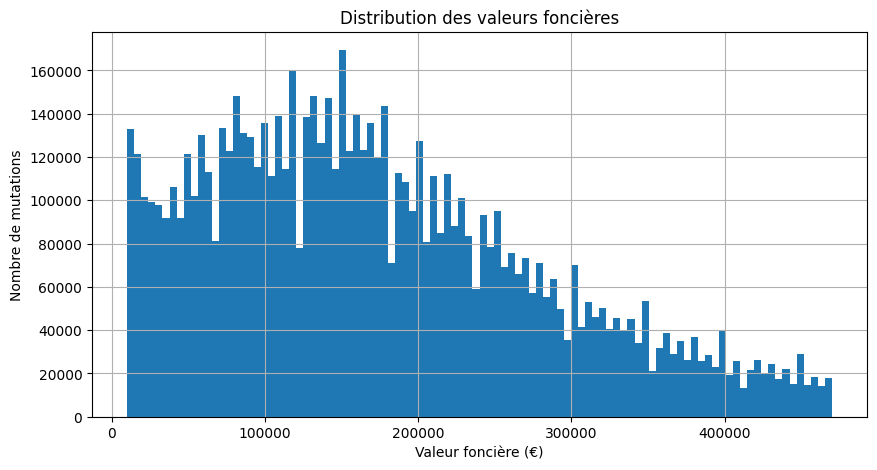

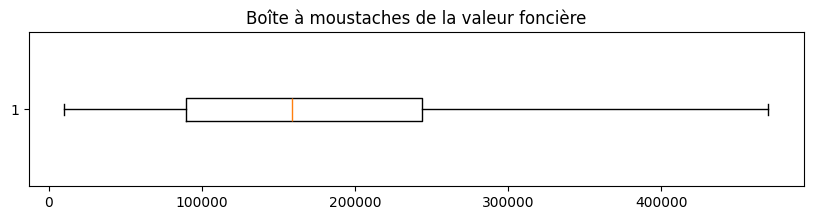

In [12]:
plt.figure(figsize=(10,5))
df_1['valeur_fonciere'].hist(bins=100)
plt.title("Distribution des valeurs fonci√®res")
plt.xlabel("Valeur fonci√®re (‚Ç¨)")
plt.ylabel("Nombre de mutations")
plt.show()

plt.figure(figsize=(10,2))
plt.boxplot(df_1['valeur_fonciere'].dropna(), vert=False)
plt.title("Bo√Æte √† moustaches de la valeur fonci√®re")
plt.show()

Distribution du DF_2 (valeurs haut gamme):

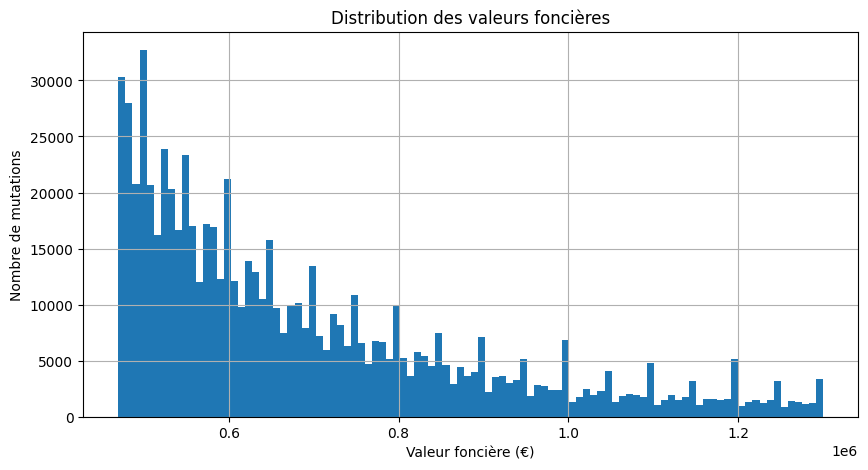

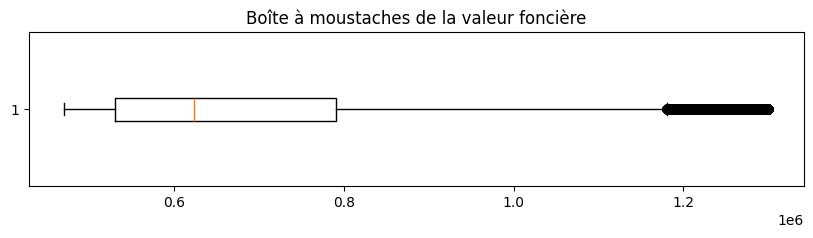

In [13]:
plt.figure(figsize=(10,5))
df_2['valeur_fonciere'].hist(bins=100)
plt.title("Distribution des valeurs fonci√®res")
plt.xlabel("Valeur fonci√®re (‚Ç¨)")
plt.ylabel("Nombre de mutations")
plt.show()

plt.figure(figsize=(10,2))
plt.boxplot(df_2['valeur_fonciere'].dropna(), vert=False)
plt.title("Bo√Æte √† moustaches de la valeur fonci√®re")
plt.show()

Distribution du DF_3 (valeurs tr√®s haut gamme):

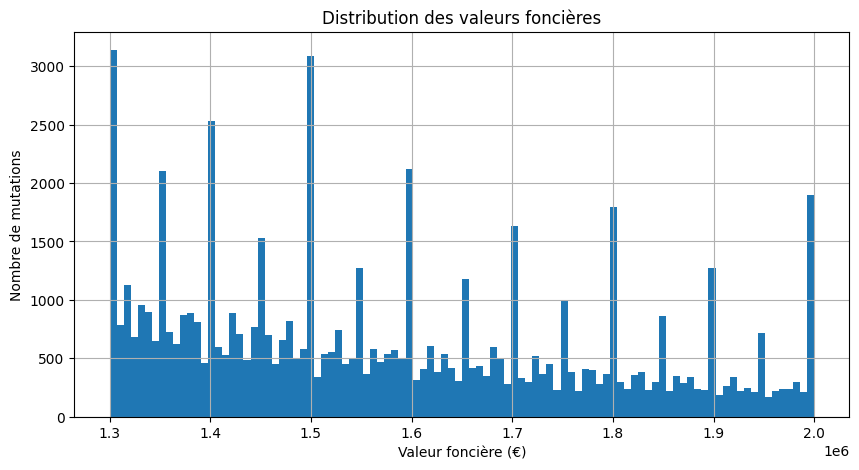

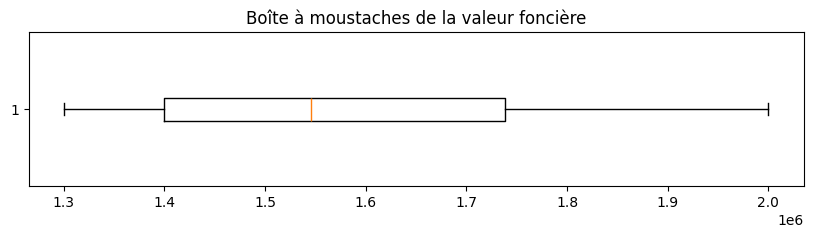

In [14]:
plt.figure(figsize=(10,5))
df_3['valeur_fonciere'].hist(bins=100)
plt.title("Distribution des valeurs fonci√®res")
plt.xlabel("Valeur fonci√®re (‚Ç¨)")
plt.ylabel("Nombre de mutations")
plt.show()

plt.figure(figsize=(10,2))
plt.boxplot(df_3['valeur_fonciere'].dropna(), vert=False)
plt.title("Bo√Æte √† moustaches de la valeur fonci√®re")
plt.show()

On peut constater maintenant qu'il n'y a plus d'outliners pour les prix.  

Nous allons maintenant nous attaquer aux outliners au niveau des surfaces. Pour cela, pour allons utiliser une autre m√©thode : la r√®gle de l'intervalle interquartile (IQR).  

Pour chaque dataframe, nous allons calculer chaque quartiles, ici sur la distribution des surfaces. Normalement, vu que nous avons d√©j√† travaill√© sur les prix, et s√©par√© chaque tranche de prix dans des dataframes diff√©rents, les ex√®s au niveau des surfaces devraient √™tre des erreurs dans le jeu de donn√©es. C'est pourquoi nous pensons que cette m√©thode est la meilleur et la plus efficace pour ce cas.  

Ainsi, chaque dataframe aura ses valeurs de surfaces filtr√©es sur ses propres quartiles, ce qui va √©liminer les surfaces anormalement petites ou grandes par rapport a la distribution g√©n√©rale de son dataframe.


In [15]:
def remove_surface_outliers_iqr(df, column='surface_reelle_bati'):
    # Calcul des quartiles sur la colonne 'surface_reelle_bati' de df
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # D√©finition des bornes inf√©rieure et sup√©rieure pour consid√©rer un outlier
    borne_inf = Q1 - 1.5 * IQR
    borne_sup = Q3 + 1.5 * IQR

    # On conserve ici uniquement les lignes dont la surface est dans [borne_inf, borne_sup]
    df_filtr√© = df[(df[column] >= borne_inf) & (df[column] <= borne_sup)].copy()
    return df_filtr√©

# 1) Nettoyage de df_1
df_1 = remove_surface_outliers_iqr(df_1, 'surface_reelle_bati')
print(f"df_1 : apr√®s = {df_1.shape[0]} lignes")

# 2) Nettoyage de df_2
df_2 = remove_surface_outliers_iqr(df_2, 'surface_reelle_bati')
print(f"df_2 : apr√®s = {df_2.shape[0]} lignes")

# 3) Nettoyage de df_3
df_3 = remove_surface_outliers_iqr(df_3, 'surface_reelle_bati')
print(f"df_3 : apr√®s = {df_3.shape[0]} lignes")


df_1 : apr√®s = 7696306 lignes
df_2 : apr√®s = 694820 lignes
df_3 : apr√®s = 60609 lignes


Nous avons ainsi retir√© une petite partie des lignes, ce qui correspondait aux outliners. Nous allons maintenant afficher les donn√©es pour voir la r√©partition :

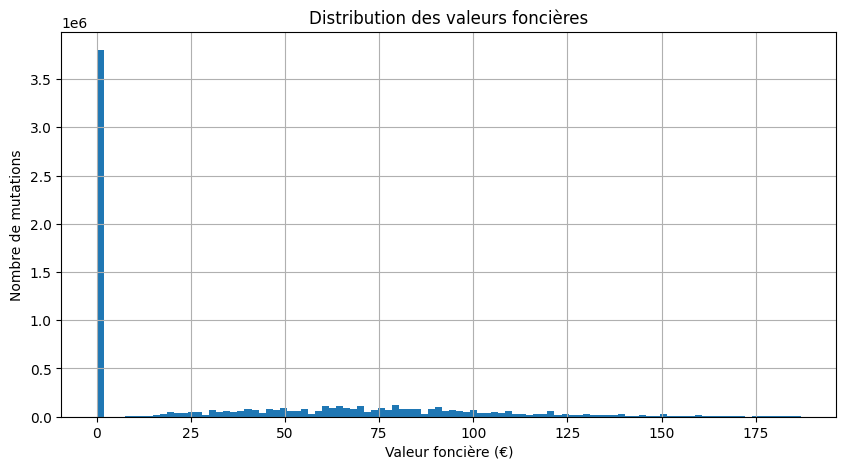

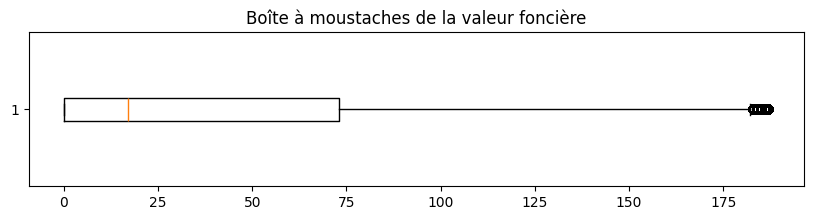

In [16]:
plt.figure(figsize=(10,5))
df_1['surface_reelle_bati'].hist(bins=100)
plt.title("Distribution des valeurs fonci√®res")
plt.xlabel("Valeur fonci√®re (‚Ç¨)")
plt.ylabel("Nombre de mutations")
plt.show()

plt.figure(figsize=(10,2))
plt.boxplot(df_1['surface_reelle_bati'].dropna(), vert=False)
plt.title("Bo√Æte √† moustaches de la valeur fonci√®re")
plt.show()

On peut voir ici que c'est tr√®s mal r√©parti. On va essayer de retirer les valeurs nulles ou √©gales √† 0.

In [ ]:
def count_zero_or_null_surface(df, column='surface_reelle_bati'):
    condition = df[column].isnull() | (df[column] == 0)
    return df[condition].shape[0]

# Exemple :
nb_zero_null_df2 = count_zero_or_null_surface(df_2)
nb_zero_null_df3 = count_zero_or_null_surface(df_3)
nb_zero_null_df1 = count_zero_or_null_surface(df_1)
print(f'Comptage de lignes nulles ou √©gales √† 0 : \n')
print(f"Nombre de lignes dans df_1 avec surface nulle ou √©gale √† 0 : {nb_zero_null_df1}")
print(f"Nombre de lignes dans df_2 avec surface nulle ou √©gale √† 0 : {nb_zero_null_df2}")
print(f"Nombre de lignes dans df_3 avec surface nulle ou √©gale √† 0 : {nb_zero_null_df3}")

Comptage de lignes nulles ou √©gales √† 0 : 

Nombre de lignes dans df_1 avec surface nulle ou √©gale √† 0 : 3799424
Nombre de lignes dans df_2 avec surface nulle ou √©gale √† 0 : 318787
Nombre de lignes dans df_3 avec surface nulle ou √©gale √† 0 : 30114


In [18]:
def drop_zero_or_null_surface(df, column='surface_reelle_bati'):
    # Condition True si surface est nulle ou √©gale √† 0
    condition_to_drop = df[column].isnull() | (df[column] == 0)
    # On ne garde que les lignes qui ne remplissent PAS cette condition
    df_filtered = df[~condition_to_drop].copy()
    return df_filtered

print(f'Nettoyage des valeurs nulles ou √©gales √† 0 pour chaque dataframes :')

# 1) Pour df_1
print(f"df_1 avant nettoyage : {df_1.shape[0]} lignes")
df_1_clean = drop_zero_or_null_surface(df_1, 'surface_reelle_bati')
print(f"df_1 apr√®s nettoyage : {df_1_clean.shape[0]} lignes (lignes supprim√©es = {df_1.shape[0] - df_1_clean.shape[0]})\n")
df_1 = df_1_clean

# 2) Pour df_2
print(f"df_2 avant nettoyage : {df_2.shape[0]} lignes")
df_2_clean = drop_zero_or_null_surface(df_2, 'surface_reelle_bati')
print(f"df_2 apr√®s nettoyage : {df_2_clean.shape[0]} lignes (lignes supprim√©es = {df_2.shape[0] - df_2_clean.shape[0]})\n")
df_2 = df_2_clean

# 3) Pour df_3
print(f"df_3 avant nettoyage : {df_3.shape[0]} lignes")
df_3_clean = drop_zero_or_null_surface(df_3, 'surface_reelle_bati')
print(f"df_3 apr√®s nettoyage : {df_3_clean.shape[0]} lignes (lignes supprim√©es = {df_3.shape[0] - df_3_clean.shape[0]})\n")
df_3 = df_3_clean


Nettoyage des valeurs nulles ou √©gales √† 0 pour chaque dataframes :
df_1 avant nettoyage : 7696306 lignes
df_1 apr√®s nettoyage : 3896882 lignes (lignes supprim√©es = 3799424)

df_2 avant nettoyage : 694820 lignes
df_2 apr√®s nettoyage : 376033 lignes (lignes supprim√©es = 318787)

df_3 avant nettoyage : 60609 lignes
df_3 apr√®s nettoyage : 30495 lignes (lignes supprim√©es = 30114)



Les trois jeux de donn√©es sont donc maintenant propre, r√©alistes et pr√™ts pour la cr√©ation de diff√©rents mod√®les d'analyse.

Nous allons proc√©der √† une analyse comparative compl√®te, de la statistique descriptive √† la visualisation g√©ographique, pour r√©v√©ler les diff√©rences cl√©s entre trois segments de prix immobiliers.  

Nous allons donc explorer les diff√©rences de structure, de distribution des prix, de comportement selon la surface, d‚Äô√©volution dans le temps et de r√©partition g√©ographique entre ces trois cat√©gories de biens.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("=== √âTAPE 2 : ANALYSE COMPARATIVE DES TROIS SEGMENTS ===\n")

# Configuration
plt.style.use('seaborn-v0_8')
fig_size = (15, 10)

def compare_segments(df_1, df_2, df_3,
                     segment1_name="Standard (10k-500k)",
                     segment2_name="Haut gamme (500k-1.3M)",
                     segment3_name="Ultra (1.3M-2M)"):
    
    print("1. COMPARAISON DES STATISTIQUES G√âN√âRALES")
    print("="*60)
    
    # Statistiques de base pour chaque segment
    stats_comparison = pd.DataFrame({
        segment1_name: [
            df_1.shape[0],
            df_1['valeur_fonciere'].mean(),
            df_1['valeur_fonciere'].median(),
            df_1['valeur_fonciere'].std(),
            df_1['surface_reelle_bati'].mean() if 'surface_reelle_bati' in df_1.columns else np.nan
        ],
        segment2_name: [
            df_2.shape[0],
            df_2['valeur_fonciere'].mean(),
            df_2['valeur_fonciere'].median(),
            df_2['valeur_fonciere'].std(),
            df_2['surface_reelle_bati'].mean() if 'surface_reelle_bati' in df_2.columns else np.nan
        ],
        segment3_name: [
            df_3.shape[0],
            df_3['valeur_fonciere'].mean(),
            df_3['valeur_fonciere'].median(),
            df_3['valeur_fonciere'].std(),
            df_3['surface_reelle_bati'].mean() if 'surface_reelle_bati' in df_3.columns else np.nan
        ]
    }, index=[
        'Nombre de transactions',
        'Prix moyen (‚Ç¨)',
        'Prix m√©dian (‚Ç¨)',
        '√âcart-type prix',
        'Surface moyenne (m¬≤)'
    ])
    
    print(stats_comparison.round(0))
    return stats_comparison

def plot_price_distributions(df_1, df_2, df_3,
                             segment1_name="Standard (10k-500k)",
                             segment2_name="Haut gamme (500k-1.3M)",
                             segment3_name="Ultra (1.3M-2M)"):
    print("\n2. DISTRIBUTIONS DES PRIX")
    print("="*30)
    
    # Cr√©ation d'une grille 3x2 pour accueillir trois histogrammes, un boxplot et une distribution log-normale
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    
    # Histogramme segment 1
    axes[0, 0].hist(df_1['valeur_fonciere'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title(f'Distribution - {segment1_name}')
    axes[0, 0].set_xlabel('Valeur fonci√®re (‚Ç¨)')
    axes[0, 0].set_ylabel('Fr√©quence')
    axes[0, 0].ticklabel_format(style='plain', axis='x')
    
    # Histogramme segment 2
    axes[0, 1].hist(df_2['valeur_fonciere'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0, 1].set_title(f'Distribution - {segment2_name}')
    axes[0, 1].set_xlabel('Valeur fonci√®re (‚Ç¨)')
    axes[0, 1].set_ylabel('Fr√©quence')
    axes[0, 1].ticklabel_format(style='plain', axis='x')
    
    # Histogramme segment 3
    axes[1, 0].hist(df_3['valeur_fonciere'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1, 0].set_title(f'Distribution - {segment3_name}')
    axes[1, 0].set_xlabel('Valeur fonci√®re (‚Ç¨)')
    axes[1, 0].set_ylabel('Fr√©quence')
    axes[1, 0].ticklabel_format(style='plain', axis='x')
    
    # Boxplot comparatif des trois segments
    data_combined = [
        df_1['valeur_fonciere'],
        df_2['valeur_fonciere'],
        df_3['valeur_fonciere']
    ]
    axes[1, 1].boxplot(data_combined, labels=[segment1_name, segment2_name, segment3_name])
    axes[1, 1].set_title('Comparaison Box Plots')
    axes[1, 1].set_ylabel('Valeur fonci√®re (‚Ç¨)')
    axes[1, 1].ticklabel_format(style='plain', axis='y')
    
    # Distributions log-normales des trois segments
    axes[2, 0].hist(np.log(df_1['valeur_fonciere']), bins=50, alpha=0.5, label=segment1_name, color='skyblue')
    axes[2, 0].hist(np.log(df_2['valeur_fonciere']), bins=50, alpha=0.5, label=segment2_name, color='lightcoral')
    axes[2, 0].hist(np.log(df_3['valeur_fonciere']), bins=50, alpha=0.5, label=segment3_name, color='lightgreen')
    axes[2, 0].set_title('Distributions Log-normales')
    axes[2, 0].set_xlabel('Log(Valeur fonci√®re)')
    axes[2, 0].set_ylabel('Fr√©quence')
    axes[2, 0].legend()
    
    # On masque l'axe restant (inutile)
    axes[2, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

def analyze_surface_price_relationship(df_1, df_2, df_3,
                                       segment1_name="Standard (10k-500k)",
                                       segment2_name="Haut gamme (500k-1.3M)",
                                       segment3_name="Ultra (1.3M-2M)"):
    print("\n3. RELATION SURFACE/PRIX PAR SEGMENT")
    print("="*45)
    
    # V√©rifier la pr√©sence de la colonne 'surface_reelle_bati'
    if 'surface_reelle_bati' in df_1.columns and 'surface_reelle_bati' in df_2.columns and 'surface_reelle_bati' in df_3.columns:
        # Garder seulement les lignes o√π la surface est > 0
        df_1_clean = df_1[df_1['surface_reelle_bati'] > 0].copy()
        df_2_clean = df_2[df_2['surface_reelle_bati'] > 0].copy()
        df_3_clean = df_3[df_3['surface_reelle_bati'] > 0].copy()
        
        # Calcul du prix au m¬≤ (optionnel mais utile pour info)
        df_1_clean['prix_m2'] = df_1_clean['valeur_fonciere'] / df_1_clean['surface_reelle_bati']
        df_2_clean['prix_m2'] = df_2_clean['valeur_fonciere'] / df_2_clean['surface_reelle_bati']
        df_3_clean['prix_m2'] = df_3_clean['valeur_fonciere'] / df_3_clean['surface_reelle_bati']
        
        # Affichage des prix moyens au m¬≤
        print(f"Prix au m¬≤ moyen - {segment1_name} : {df_1_clean['prix_m2'].mean():.0f} ‚Ç¨/m¬≤")
        print(f"Prix au m¬≤ moyen - {segment2_name} : {df_2_clean['prix_m2'].mean():.0f} ‚Ç¨/m¬≤")
        print(f"Prix au m¬≤ moyen - {segment3_name} : {df_3_clean['prix_m2'].mean():.0f} ‚Ç¨/m¬≤")
        
        # Pr√©paration de la figure avec 3 sous‚Äêgraphiques c√¥te √† c√¥te
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # √âchantillonnage pour la clart√© (limit√© √† 30 000 points, ou moins si le df est plus petit)
        sample_size_1 = min(30000, len(df_1_clean))
        sample_size_2 = min(30000, len(df_2_clean))
        sample_size_3 = min(30000, len(df_3_clean))
        
        df_1_sample = df_1_clean.sample(n=sample_size_1, random_state=42)
        df_2_sample = df_2_clean.sample(n=sample_size_2, random_state=42)
        df_3_sample = df_3_clean.sample(n=sample_size_3, random_state=42)
        
        # --------------------------------------------------
        # 1) Segment 1 : nuage + droite de r√©gression simple
        # --------------------------------------------------
        x1 = df_1_sample['surface_reelle_bati'].values
        y1 = df_1_sample['valeur_fonciere'].values
        
        # Nuage de points
        axes[0].scatter(x1, y1, alpha=0.5, s=1, color='skyblue')
        axes[0].set_title(f'Relation Surface/Prix - {segment1_name}')
        axes[0].set_xlabel('Surface (m¬≤)')
        axes[0].set_ylabel('Valeur fonci√®re (‚Ç¨)')
        
        # Calcul des coefficients de la droite de r√©gression (ordre 1)
        coef1 = np.polyfit(x1, y1, deg=1)        # coef1[0] = pente, coef1[1] = ordonn√©e √† l'origine
        pente1, intercept1 = coef1[0], coef1[1]
        
        # Trac√© de la droite : on cr√©e deux points extr√™mes sur l'axe des surfaces pour dessiner la ligne
        x1_min, x1_max = x1.min(), x1.max()
        y1_min_line = pente1 * x1_min + intercept1
        y1_max_line = pente1 * x1_max + intercept1
        axes[0].plot([x1_min, x1_max], [y1_min_line, y1_max_line],
                     color='darkblue', linewidth=2, label='R√©gression lin√©aire')
        axes[0].legend()
        
        # --------------------------------------------------
        # 2) Segment 2 : nuage + droite de r√©gression simple
        # --------------------------------------------------
        x2 = df_2_sample['surface_reelle_bati'].values
        y2 = df_2_sample['valeur_fonciere'].values
        
        axes[1].scatter(x2, y2, alpha=0.5, s=1, color='lightcoral')
        axes[1].set_title(f'Relation Surface/Prix - {segment2_name}')
        axes[1].set_xlabel('Surface (m¬≤)')
        axes[1].set_ylabel('Valeur fonci√®re (‚Ç¨)')
        
        coef2 = np.polyfit(x2, y2, deg=1)
        pente2, intercept2 = coef2[0], coef2[1]
        
        x2_min, x2_max = x2.min(), x2.max()
        y2_min_line = pente2 * x2_min + intercept2
        y2_max_line = pente2 * x2_max + intercept2
        axes[1].plot([x2_min, x2_max], [y2_min_line, y2_max_line],
                     color='darkred', linewidth=2, label='R√©gression lin√©aire')
        axes[1].legend()
        
        # --------------------------------------------------
        # 3) Segment 3 : nuage + droite de r√©gression simple
        # --------------------------------------------------
        x3 = df_3_sample['surface_reelle_bati'].values
        y3 = df_3_sample['valeur_fonciere'].values
        
        axes[2].scatter(x3, y3, alpha=0.5, s=1, color='lightgreen')
        axes[2].set_title(f'Relation Surface/Prix - {segment3_name}')
        axes[2].set_xlabel('Surface (m¬≤)')
        axes[2].set_ylabel('Valeur fonci√®re (‚Ç¨)')
        
        coef3 = np.polyfit(x3, y3, deg=1)
        pente3, intercept3 = coef3[0], coef3[1]
        
        x3_min, x3_max = x3.min(), x3.max()
        y3_min_line = pente3 * x3_min + intercept3
        y3_max_line = pente3 * x3_max + intercept3
        axes[2].plot([x3_min, x3_max], [y3_min_line, y3_max_line],
                     color='darkgreen', linewidth=2, label='R√©gression lin√©aire')
        axes[2].legend()
        
        plt.tight_layout()
        plt.show()
        
        return df_1_clean, df_2_clean, df_3_clean
    
    else:
        print("Colonne 'surface_reelle_bati' non trouv√©e dans l'un des dataframes")
        return df_1, df_2, df_3


def analyze_temporal_patterns(df_1, df_2, df_3,
                              segment1_name="Standard (10k-500k)",
                              segment2_name="Haut gamme (500k-1.3M)",
                              segment3_name="Ultra (1.3M-2M)"):
    """
    Analyse des patterns temporels pour les trois segments
    """
    print("\n4. ANALYSE TEMPORELLE")
    print("="*30)
    
    # V√©rifier la pr√©sence de la colonne 'date_mutation'
    if 'date_mutation' in df_1.columns and 'date_mutation' in df_2.columns and 'date_mutation' in df_3.columns:
        # Conversion des dates
        df_1['date_mutation'] = pd.to_datetime(df_1['date_mutation'])
        df_2['date_mutation'] = pd.to_datetime(df_2['date_mutation'])
        df_3['date_mutation'] = pd.to_datetime(df_3['date_mutation'])
        
        # Extraction des composantes temporelles
        for df in [df_1, df_2, df_3]:
            df['annee'] = df['date_mutation'].dt.year
            df['mois'] = df['date_mutation'].dt.month
        
        # Evolution annuelle des prix moyens
        prix_annuel_1 = df_1.groupby('annee')['valeur_fonciere'].mean()
        prix_annuel_2 = df_2.groupby('annee')['valeur_fonciere'].mean()
        prix_annuel_3 = df_3.groupby('annee')['valeur_fonciere'].mean()
        
        plt.figure(figsize=(12, 6))
        plt.plot(prix_annuel_1.index, prix_annuel_1.values, marker='o', label=segment1_name, linewidth=2)
        plt.plot(prix_annuel_2.index, prix_annuel_2.values, marker='s', label=segment2_name, linewidth=2)
        plt.plot(prix_annuel_3.index, prix_annuel_3.values, marker='^', label=segment3_name, linewidth=2)
        plt.title('√âvolution du prix moyen par ann√©e')
        plt.xlabel('Ann√©e')
        plt.ylabel('Prix moyen (‚Ç¨)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.ticklabel_format(style='plain', axis='y')
        plt.show()
        
        # Saisonnalit√© mensuelle des prix
        prix_mensuel_1 = df_1.groupby('mois')['valeur_fonciere'].mean()
        prix_mensuel_2 = df_2.groupby('mois')['valeur_fonciere'].mean()
        prix_mensuel_3 = df_3.groupby('mois')['valeur_fonciere'].mean()
        
        plt.figure(figsize=(12, 6))
        plt.plot(prix_mensuel_1.index, prix_mensuel_1.values, marker='o', label=segment1_name, linewidth=2)
        plt.plot(prix_mensuel_2.index, prix_mensuel_2.values, marker='s', label=segment2_name, linewidth=2)
        plt.plot(prix_mensuel_3.index, prix_mensuel_3.values, marker='^', label=segment3_name, linewidth=2)
        plt.title('Saisonnalit√© des prix (par mois)')
        plt.xlabel('Mois')
        plt.ylabel('Prix moyen (‚Ç¨)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(range(1, 13))
        plt.ticklabel_format(style='plain', axis='y')
        plt.show()
        
    else:
        print("Colonne 'date_mutation' non trouv√©e dans l'un des dataframes")

def extract_departement_from_postal_code(code_postal):
    code_str = str(code_postal).zfill(5)  # Remplit avec des z√©ros si n√©cessaire
    if len(code_str) == 4:  
        return code_str[:2].zfill(2)
    elif len(code_str) == 5:
        return code_str[:2]
    else:
        return None

def analyze_geographic_patterns(df_1, df_2, df_3):
    print("\n5. ANALYSE G√âOGRAPHIQUE PAR D√âPARTEMENT")
    print("=" * 45)
    
    # 1) V√©rifier la pr√©sence de la colonne 'code_postal' et 'valeur_fonciere' dans chacun
    for col in ['code_postal', 'valeur_fonciere']:
        if col not in df_1.columns or col not in df_2.columns or col not in df_3.columns:
            print(f"Erreur : la colonne '{col}' est manquante dans au moins un des DataFrames.")
            return df_1, df_2, df_3, None, None, None
    
    # 2) Cr√©er des copies pour ne pas modifier les originaux et extraire 'departement'
    def add_departement_col(df):
        temp = df.copy()
        temp['code_postal'] = temp['code_postal'].astype(str).str.zfill(5)
        temp['departement'] = temp['code_postal'].str[:2]
        return temp

    df1_geo = add_departement_col(df_1)
    df2_geo = add_departement_col(df_2)
    df3_geo = add_departement_col(df_3)
    
    df1_geo = df1_geo.dropna(subset=['departement'])
    df2_geo = df2_geo.dropna(subset=['departement'])
    df3_geo = df3_geo.dropna(subset=['departement'])
    
    print(f"‚úì D√©partements identifi√©s - Segment standard   : {df1_geo['departement'].nunique()}")
    print(f"‚úì D√©partements identifi√©s - Segment haut gamme : {df2_geo['departement'].nunique()}")
    print(f"‚úì D√©partements identifi√©s - Segment ultra      : {df3_geo['departement'].nunique()}")
    
    # 3) Calculer les statistiques par d√©partement pour chaque segment
    def compute_dept_stats(df_geo):
        agg = df_geo.groupby('departement').agg(
            valeur_fonciere_count=('valeur_fonciere', 'count'),
            valeur_fonciere_mean=('valeur_fonciere', 'mean'),
            valeur_fonciere_median=('valeur_fonciere', 'median'),
            valeur_fonciere_std=('valeur_fonciere', 'std')
        )
        # Ajouter stats de surface si disponible
        if 'surface_reelle_bati' in df_geo.columns:
            agg['surface_reelle_bati_mean'] = df_geo.groupby('departement')['surface_reelle_bati'].mean()
            agg['surface_reelle_bati_median'] = df_geo.groupby('departement')['surface_reelle_bati'].median()
        return agg.round(0).sort_values('valeur_fonciere_count', ascending=False)

    dept_stats_1 = compute_dept_stats(df1_geo)
    dept_stats_2 = compute_dept_stats(df2_geo)
    dept_stats_3 = compute_dept_stats(df3_geo)
    
    # 4) Afficher les Top 10 d√©partements pour chaque segment (par nombre de transactions)
    print("\nTOP 10 D√âPARTEMENTS - SEGMENT STANDARD (10k-500k ‚Ç¨)")
    print("-" * 60)
    print(dept_stats_1.head(10))
    
    print("\nTOP 10 D√âPARTEMENTS - SEGMENT HAUT GAMME (500k-1.3M ‚Ç¨)")
    print("-" * 60)
    print(dept_stats_2.head(10))
    
    print("\nTOP 10 D√âPARTEMENTS - SEGMENT ULTRA (1.3M-2M ‚Ç¨)")
    print("-" * 60)
    print(dept_stats_3.head(10))
    
    # 5) Visualisations Matplotlib
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # Top 15 par segment : nombre de transactions
    top15_1 = dept_stats_1.head(15)
    top15_2 = dept_stats_2.head(15)
    top15_3 = dept_stats_3.head(15)
    top15_mean_1 = dept_stats_1.sort_values('valeur_fonciere_mean', ascending=False).head(15)
    top15_mean_2 = dept_stats_2.sort_values('valeur_fonciere_mean', ascending=False).head(15)
    top15_mean_3 = dept_stats_3.sort_values('valeur_fonciere_mean', ascending=False).head(15)
    
    # 5.1) Nombre de transactions - Segment 1
    axes[0, 0].bar(top15_1.index, top15_1['valeur_fonciere_count'], color='skyblue', alpha=0.7)
    axes[0, 0].set_title('Top 15 D√©partements\nNb transactions - Standard')
    axes[0, 0].set_xlabel('D√©partement')
    axes[0, 0].set_ylabel('Nb transactions')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 5.2) Nombre de transactions - Segment 2
    axes[0, 1].bar(top15_2.index, top15_2['valeur_fonciere_count'], color='lightcoral', alpha=0.7)
    axes[0, 1].set_title('Top 15 D√©partements\nNb transactions - Haut gamme')
    axes[0, 1].set_xlabel('D√©partement')
    axes[0, 1].set_ylabel('Nb transactions')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 5.3) Nombre de transactions - Segment 3
    axes[0, 2].bar(top15_3.index, top15_3['valeur_fonciere_count'], color='lightgreen', alpha=0.7)
    axes[0, 2].set_title('Top 15 D√©partements\nNb transactions - Ultra')
    axes[0, 2].set_xlabel('D√©partement')
    axes[0, 2].set_ylabel('Nb transactions')
    axes[0, 2].tick_params(axis='x', rotation=45)
    
    # Top 15 par segment : prix moyen
    # 5.4) Prix moyen - Segment 1 (tri√© d√©croissant)
    axes[1, 0].bar(top15_mean_1.index, top15_mean_1['valeur_fonciere_mean'], 
                color='gold', alpha=0.7)
    axes[1, 0].set_title('Top 15 D√©partements\nPrix moyen (‚Ç¨) - Standard (tri√© d√©croissant)')
    axes[1, 0].set_xlabel('D√©partement')
    axes[1, 0].set_ylabel('Prix moyen (‚Ç¨)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].ticklabel_format(style='plain', axis='y')

    # 5.5) Prix moyen - Segment 2 (tri√© d√©croissant)
    axes[1, 1].bar(top15_mean_2.index, top15_mean_2['valeur_fonciere_mean'], 
                color='purple', alpha=0.7)
    axes[1, 1].set_title('Top 15 D√©partements\nPrix moyen (‚Ç¨) - Haut gamme (tri√© d√©croissant)')
    axes[1, 1].set_xlabel('D√©partement')
    axes[1, 1].set_ylabel('Prix moyen (‚Ç¨)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].ticklabel_format(style='plain', axis='y')

    # 5.6) Prix moyen - Segment 3 (tri√© d√©croissant)
    axes[1, 2].bar(top15_mean_3.index, top15_mean_3['valeur_fonciere_mean'], 
                color='darkgreen', alpha=0.7)
    axes[1, 2].set_title('Top 15 D√©partements\nPrix moyen (‚Ç¨) - Ultra (tri√© d√©croissant)')
    axes[1, 2].set_xlabel('D√©partement')
    axes[1, 2].set_ylabel('Prix moyen (‚Ç¨)')
    axes[1, 2].tick_params(axis='x', rotation=45)
    axes[1, 2].ticklabel_format(style='plain', axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # 6) D√©partements communs aux trois segments et comparaison des prix moyens
    depts_communs_123 = (
        set(df1_geo['departement'].unique()) &
        set(df2_geo['departement'].unique()) &
        set(df3_geo['departement'].unique())
    )
    print(f"\nD√âPARTEMENTS COMMUNS AUX TROIS SEGMENTS : {len(depts_communs_123)}")
    print(f"D√©partements communs : {sorted(depts_communs_123)}")
    
    if depts_communs_123:
        # Pour lisibilit√©, on ne prend que les 10 premiers d√©partements communs
        depts_afficher = sorted(list(depts_communs_123))[:10]
        
        comparison_data = []
        for dept in depts_afficher:
            prix_std   = dept_stats_1.loc[dept, 'valeur_fonciere_mean'] if dept in dept_stats_1.index else 0
            prix_hg    = dept_stats_2.loc[dept, 'valeur_fonciere_mean'] if dept in dept_stats_2.index else 0
            prix_ultra = dept_stats_3.loc[dept, 'valeur_fonciere_mean'] if dept in dept_stats_3.index else 0
            comparison_data.append({
                'departement': dept,
                'prix_standard': prix_std,
                'prix_haut_gamme': prix_hg,
                'prix_ultra': prix_ultra
            })
        
        comp_df = pd.DataFrame(comparison_data)
        comp_df = comp_df.set_index('departement')
        
        print("\nCOMPARAISON PRIX MOYENS - D√âPARTEMENTS COMMUNS (10 PREMIERS)")
        print("-" * 70)
        print(comp_df)
        
        # Graphique de comparaison pour les d√©partements communs
        plt.figure(figsize=(14, 8))
        x = np.arange(len(comp_df.index))
        width = 0.25
        
        plt.bar(x - width, comp_df['prix_standard'],  width, label='Standard',   color='skyblue', alpha=0.7)
        plt.bar(x,         comp_df['prix_haut_gamme'], width, label='Haut gamme', color='lightcoral', alpha=0.7)
        plt.bar(x + width, comp_df['prix_ultra'],     width, label='Ultra',      color='lightgreen', alpha=0.7)
        
        plt.xlabel('D√©partement')
        plt.ylabel('Prix moyen (‚Ç¨)')
        plt.title('Comparaison des prix moyens par d√©partement (communs)')
        plt.xticks(x, comp_df.index, rotation=45)
        plt.legend()
        plt.ticklabel_format(style='plain', axis='y')
        plt.tight_layout()
        plt.show()
    
    # 7) Statistiques g√©ographiques globales
    print(f"\nR√âSUM√â G√âOGRAPHIQUE")
    print("-" * 30)
    print("Segment Standard :")
    print(f"  - D√©partements couverts       : {df1_geo['departement'].nunique()}")
    print(f"  - Prix moyen national         : {df1_geo['valeur_fonciere'].mean():.0f} ‚Ç¨")
    print(f"  - D√©partement le plus cher    : {dept_stats_1['valeur_fonciere_mean'].idxmax()} ({dept_stats_1['valeur_fonciere_mean'].max():.0f} ‚Ç¨)")
    print(f"  - D√©partement le moins cher   : {dept_stats_1['valeur_fonciere_mean'].idxmin()} ({dept_stats_1['valeur_fonciere_mean'].min():.0f} ‚Ç¨)")
    
    print("\nSegment Haut gamme :")
    print(f"  - D√©partements couverts       : {df2_geo['departement'].nunique()}")
    print(f"  - Prix moyen national         : {df2_geo['valeur_fonciere'].mean():.0f} ‚Ç¨")
    print(f"  - D√©partement le plus cher    : {dept_stats_2['valeur_fonciere_mean'].idxmax()} ({dept_stats_2['valeur_fonciere_mean'].max():.0f} ‚Ç¨)")
    print(f"  - D√©partement le moins cher   : {dept_stats_2['valeur_fonciere_mean'].idxmin()} ({dept_stats_2['valeur_fonciere_mean'].min():.0f} ‚Ç¨)")
    
    print("\nSegment Ultra :")
    print(f"  - D√©partements couverts       : {df3_geo['departement'].nunique()}")
    print(f"  - Prix moyen national         : {df3_geo['valeur_fonciere'].mean():.0f} ‚Ç¨")
    print(f"  - D√©partement le plus cher    : {dept_stats_3['valeur_fonciere_mean'].idxmax()} ({dept_stats_3['valeur_fonciere_mean'].max():.0f} ‚Ç¨)")
    print(f"  - D√©partement le moins cher   : {dept_stats_3['valeur_fonciere_mean'].idxmin()} ({dept_stats_3['valeur_fonciere_mean'].min():.0f} ‚Ç¨)")
    
    return df1_geo, df2_geo, df3_geo, dept_stats_1, dept_stats_2, dept_stats_3



=== √âTAPE 2 : ANALYSE COMPARATIVE DES TROIS SEGMENTS ===



Lancement de l'analyse comparative sur trois segments...
1. COMPARAISON DES STATISTIQUES G√âN√âRALES
                        Standard (10k-500k)  Haut gamme (500k-1.3M)  \
Nombre de transactions            3896882.0                376033.0   
Prix moyen (‚Ç¨)                     185470.0                681279.0   
Prix m√©dian (‚Ç¨)                    167648.0                618000.0   
√âcart-type prix                    103852.0                197399.0   
Surface moyenne (m¬≤)                   75.0                   111.0   

                        Ultra (1.3M-2M)  
Nombre de transactions          30495.0  
Prix moyen (‚Ç¨)                1574360.0  
Prix m√©dian (‚Ç¨)               1535000.0  
√âcart-type prix                201615.0  
Surface moyenne (m¬≤)              134.0  

2. DISTRIBUTIONS DES PRIX


C:\Users\bonni\AppData\Local\Temp\ipykernel_21788\531409676.py:100: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(data_combined, labels=[segment1_name, segment2_name, segment3_name])


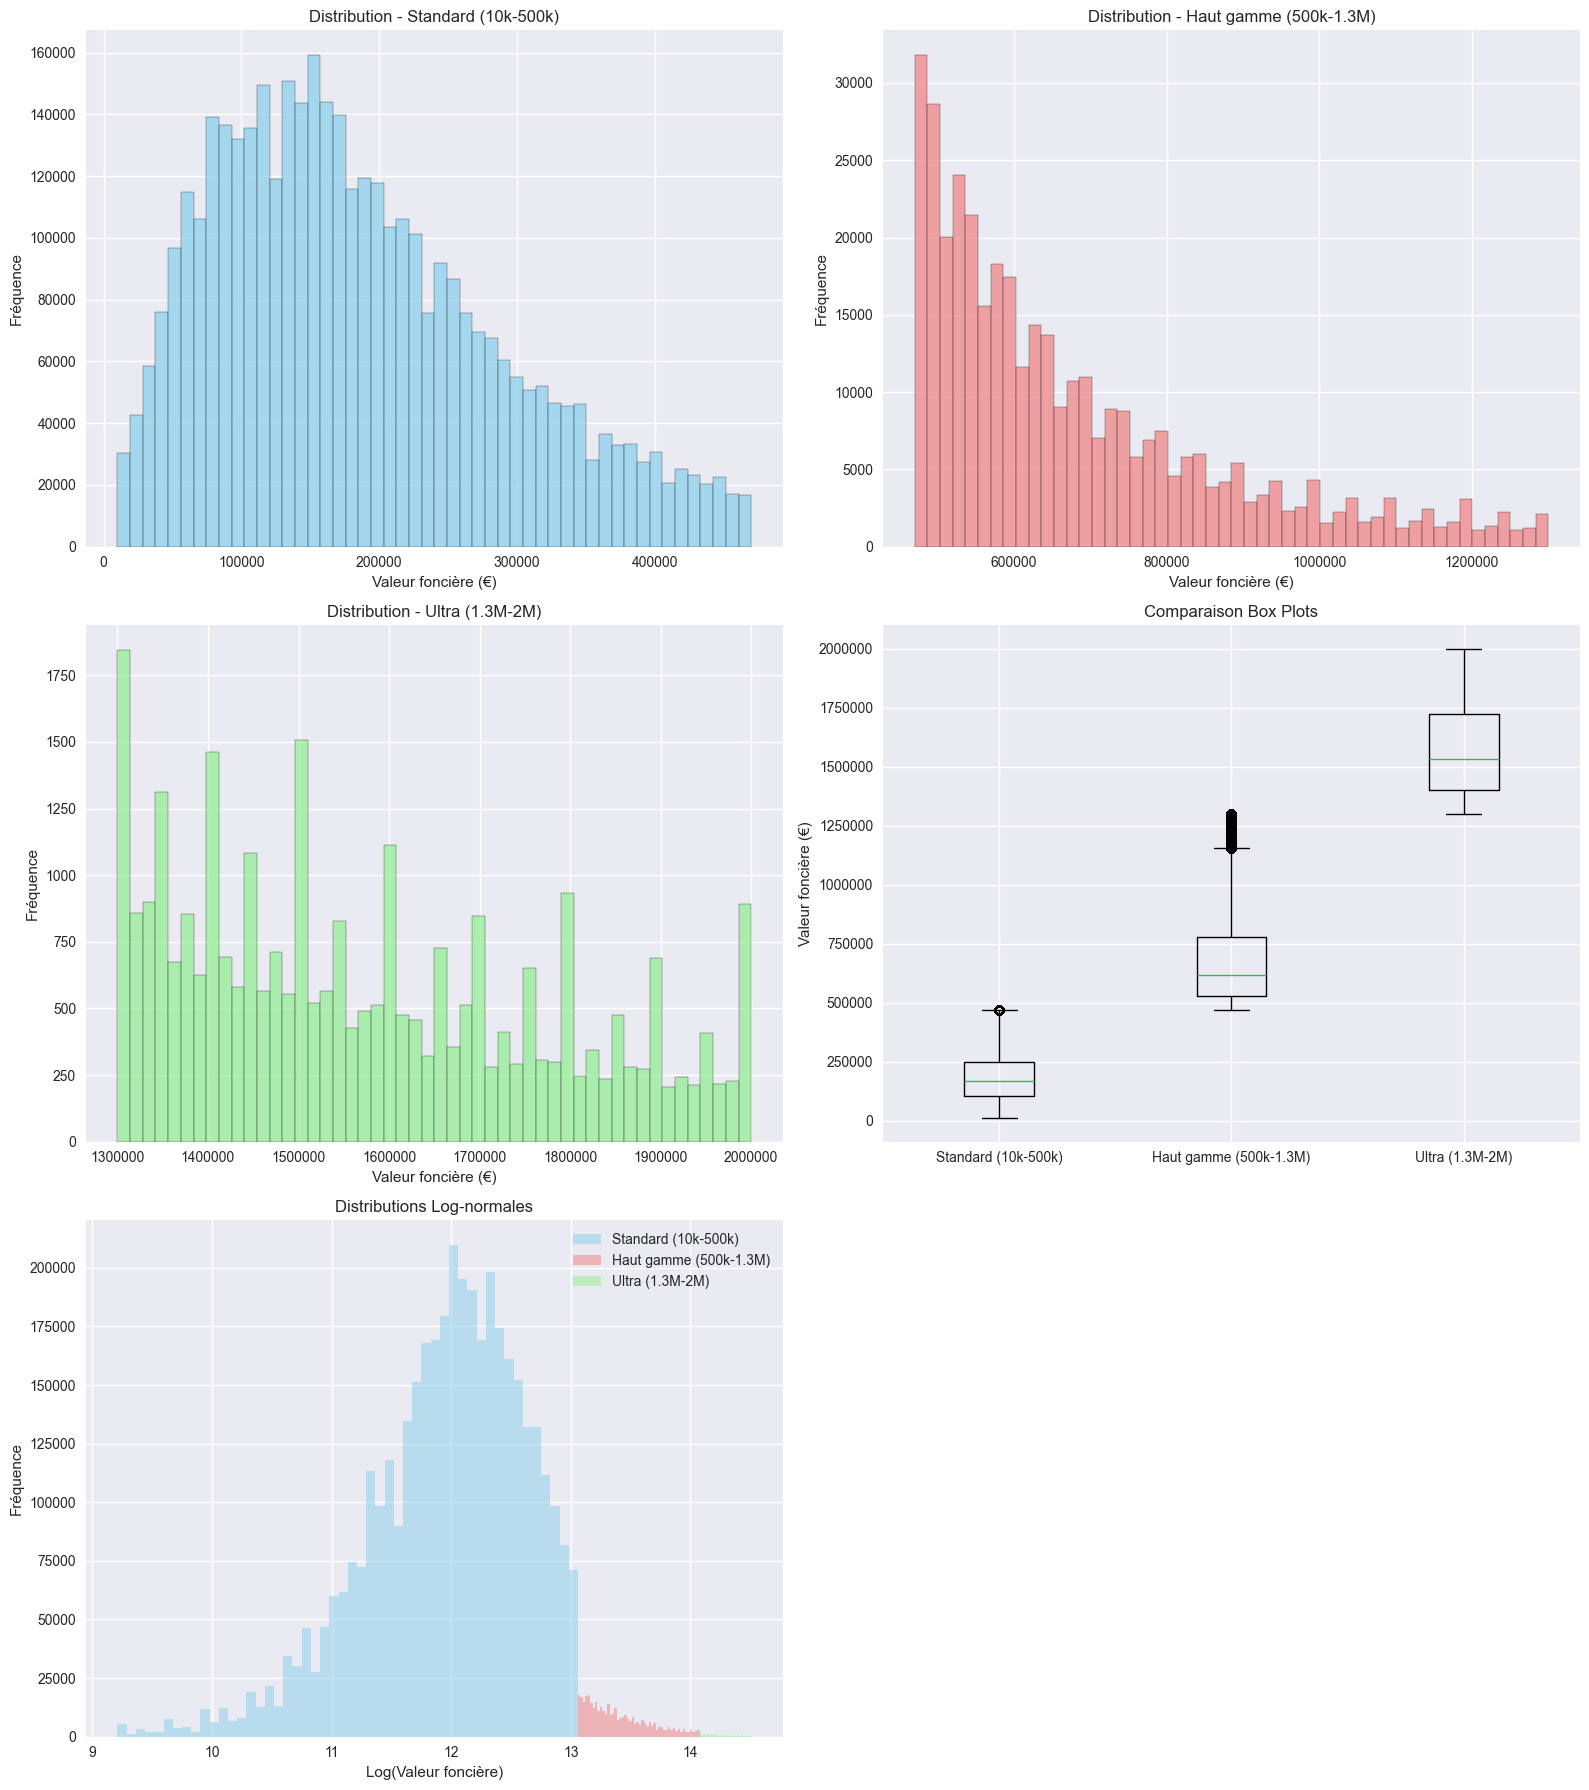


3. RELATION SURFACE/PRIX PAR SEGMENT
Prix au m¬≤ moyen - Standard (10k-500k) : 2975 ‚Ç¨/m¬≤
Prix au m¬≤ moyen - Haut gamme (500k-1.3M) : 8559 ‚Ç¨/m¬≤
Prix au m¬≤ moyen - Ultra (1.3M-2M) : 19260 ‚Ç¨/m¬≤


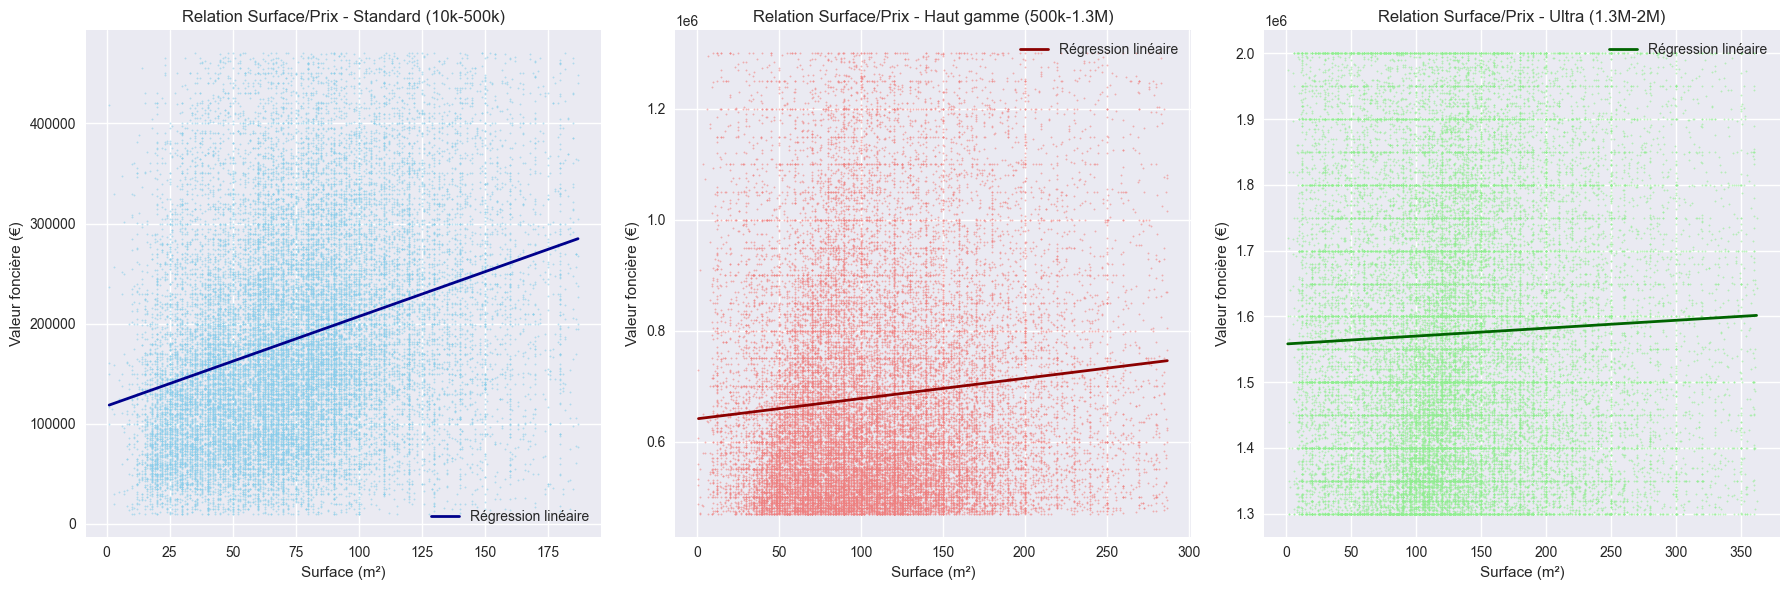


4. ANALYSE TEMPORELLE


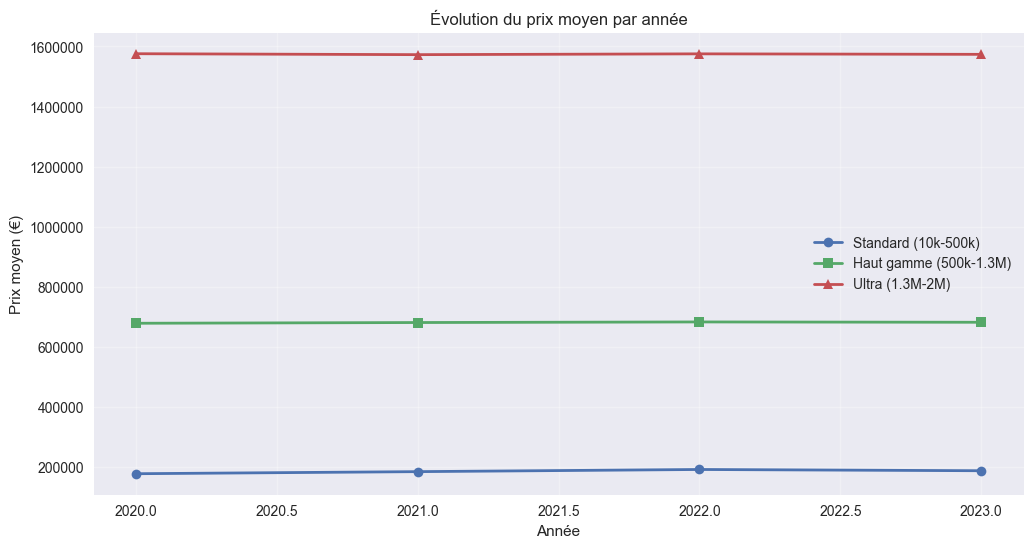

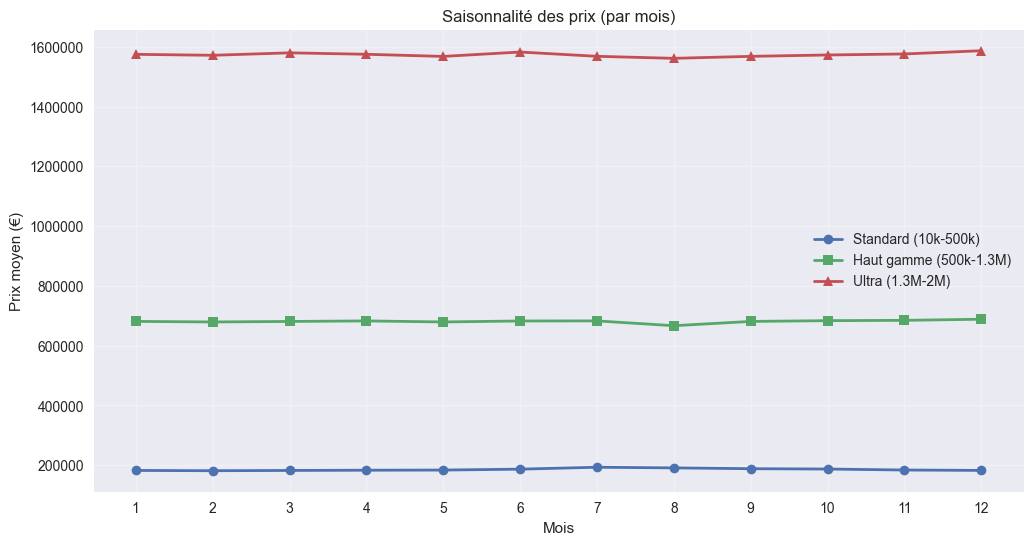


5. ANALYSE G√âOGRAPHIQUE PAR D√âPARTEMENT
‚úì D√©partements identifi√©s - Segment standard   : 94
‚úì D√©partements identifi√©s - Segment haut gamme : 94
‚úì D√©partements identifi√©s - Segment ultra      : 93

TOP 10 D√âPARTEMENTS - SEGMENT STANDARD (10k-500k ‚Ç¨)
------------------------------------------------------------
             valeur_fonciere_count  valeur_fonciere_mean  \
departement                                                
59                          147873              174286.0   
13                          114133              207747.0   
69                          100135              237201.0   
34                           98544              183135.0   
06                           96116              217253.0   
33                           93677              232253.0   
83                           93071              213863.0   
44                           89533              221322.0   
31                           88215              200230.0   
38          

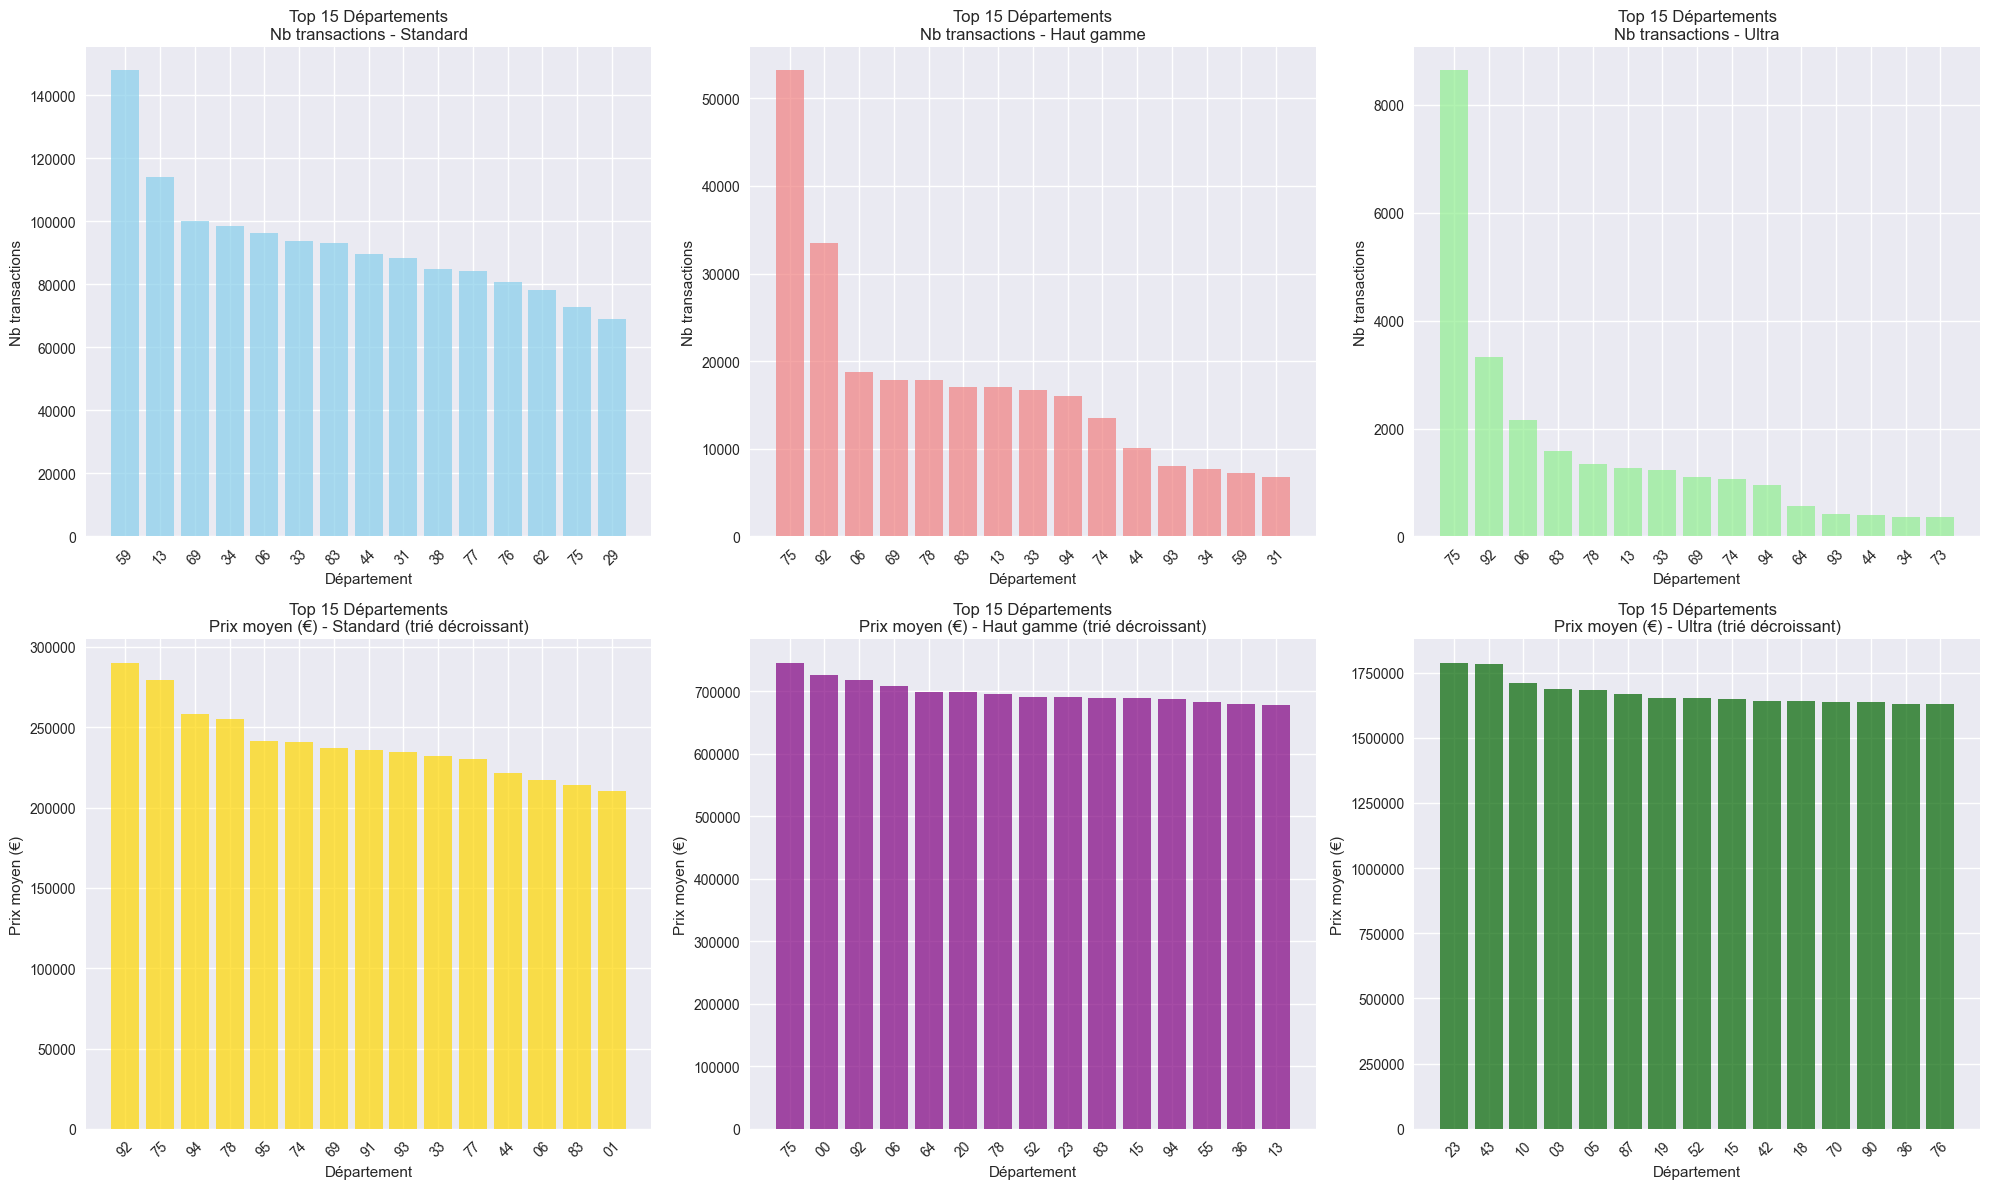


D√âPARTEMENTS COMMUNS AUX TROIS SEGMENTS : 93
D√©partements communs : ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '58', '59', '60', '61', '62', '63', '64', '65', '66', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '97']

COMPARAISON PRIX MOYENS - D√âPARTEMENTS COMMUNS (10 PREMIERS)
----------------------------------------------------------------------
             prix_standard  prix_haut_gamme  prix_ultra
departement                                            
01                210243.0         657403.0   1563502.0
02                120479.0         616544.0   1518665.0
03          

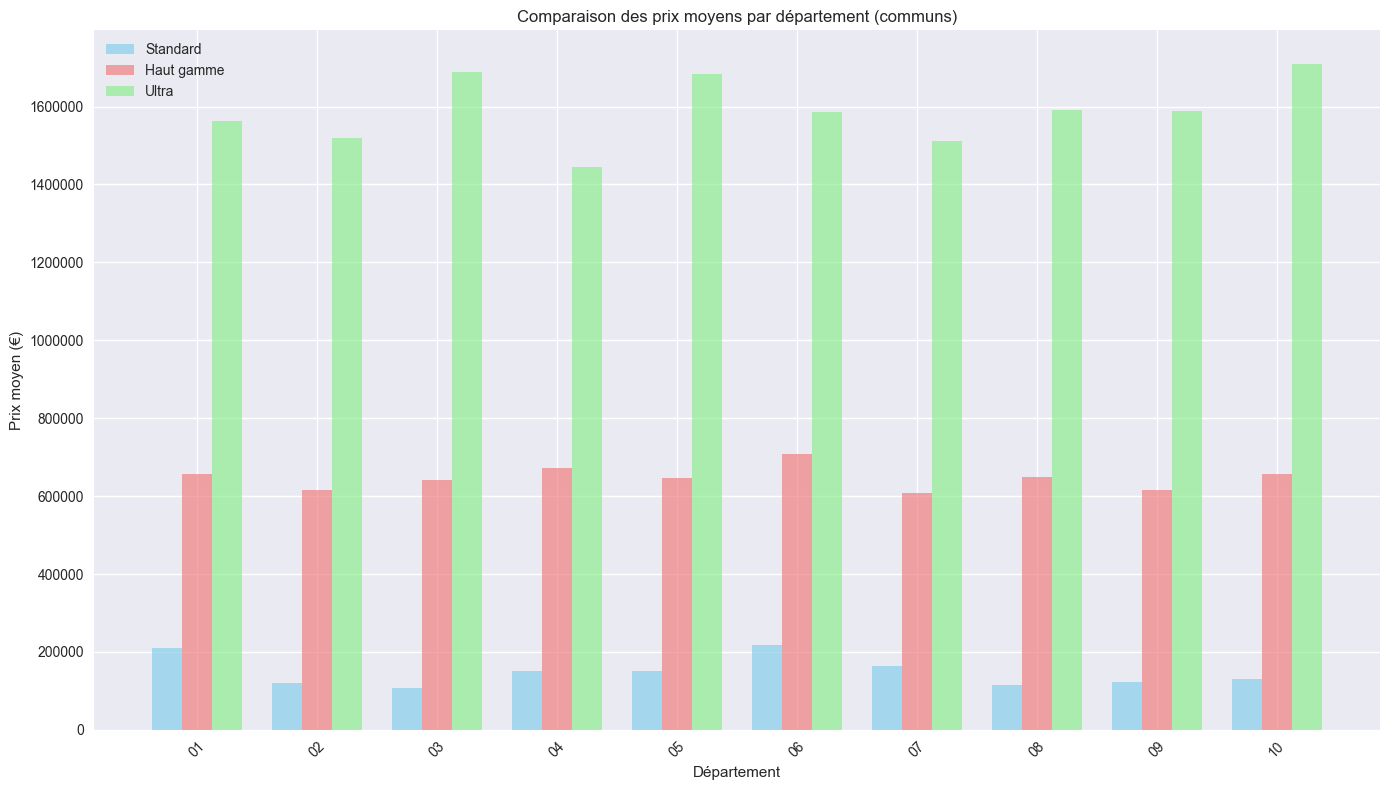


R√âSUM√â G√âOGRAPHIQUE
------------------------------
Segment Standard :
  - D√©partements couverts       : 94
  - Prix moyen national         : 185470 ‚Ç¨
  - D√©partement le plus cher    : 92 (290122 ‚Ç¨)
  - D√©partement le moins cher   : 23 (79808 ‚Ç¨)

Segment Haut gamme :
  - D√©partements couverts       : 94
  - Prix moyen national         : 681279 ‚Ç¨
  - D√©partement le plus cher    : 75 (745797 ‚Ç¨)
  - D√©partement le moins cher   : 43 (584470 ‚Ç¨)

Segment Ultra :
  - D√©partements couverts       : 93
  - Prix moyen national         : 1574360 ‚Ç¨
  - D√©partement le plus cher    : 23 (1787868 ‚Ç¨)
  - D√©partement le moins cher   : 53 (1362500 ‚Ç¨)

=== FIN √âTAPE 2 ===


In [20]:
if __name__ == "__main__":
    print("Lancement de l'analyse comparative sur trois segments...")
    
    stats = compare_segments(df_1, df_2, df_3)
    plot_price_distributions(df_1, df_2, df_3)
    df_1_clean, df_2_clean, df_3_clean = analyze_surface_price_relationship(df_1, df_2, df_3)
    analyze_temporal_patterns(df_1, df_2, df_3)
    df1_geo, df2_geo, df3_geo, stats_dept_1, stats_dept_2, stats_dept_3 = \
        analyze_geographic_patterns(df_1, df_2, df_3)
    
    print("\n=== FIN √âTAPE 2 ===")

### Explications des r√©sultats :  

1- Comparaisons statistiques :  
Les r√©sultats sont coh√©rents, malgr√© les datasets de tailles bien diff√©rents. Les datasets suivent les m√™mes directions, des moyennes qui tendent vers les valeurs les plus basses, qui sont aussi les plus nombreuses par datasets.  
  
2- Distribution des prix :  
Pour cette partie, on peut constater que les graphiques suivent et correspondent aux tendances trouv√©es dans la comparaison statistique.  
  
3- Relation surface/prix :  
Nous pouvons observer une tendance g√©n√©rale, avec des droites de r√©gressions qui semblent coh√©rentes.  
En effet, dans le segment standard, le nuage de points est √©parpill√©, mais la droite monte nettement en fonction de la surface, ce qui est coh√©rent. Ce sch√©ma ce rep√®te sur les deux autres dataframes, pour les hauts de gamme et ultras haut de gamme.  
On peut aussi constater, pour la partie ultras haut de gamme, que la pente est quasiment nulle. Cela peut s'expliquer par des facteurs assez simples : on vend dans cette tranche de prix des biens tr√®s chers, m√™me pour des surfaces modestes, comme par exemple des appartements en bord de mer/fleuves, appartements de grandes ville, ect.  

4- Analyse temporelle :  
Etonnement, l'analyse sur les temporalit√©es n'a pas d√©montr√© d'√©volution significatives, ni de changement. Nous pouvons tout de m√™me prendre en compte que le dataset tiens compte des donn√©es de 2020 √† 2024, ce qui reste une tranche temporelle courte, malgr√© la richesse de nos donn√©es.

5- Analyse g√©ographique :  
Les trois segments couvrent presque tous les d√©partements (93‚Äì94), avec une concentration des transactions Standard dans les zones urbaines (59, 13, 69‚Ä¶), des ventes Haut gamme domin√©es par Paris et la C√¥te d‚ÄôAzur, et une forte hausse des prix Ultra dans des d√©partements parfois ruraux (23 Creuse, 43 Haute-Loire) o√π les biens d‚Äôexception tirent la moyenne vers le haut.  

Gr√¢ce √† cette analyse, nous savons vers quelels donn√©es nous tourner en priorit√©.  

Nous allons donc maintenant passer √† l'√©tape 3 de notre projet : la cr√©ation des mod√®les et featurings pour notre pr√©diction.  

## 3.1 Cr√©ation des featurings et mod√®les

L‚Äôobjectif de cette √©tape est de pr√©parer les donn√©es de chaque segment immobilier pour qu‚Äôelles soient exploitables par un mod√®le de deep learning (ou de machine learning).
Cela passe par la cr√©ation de nouvelles variables (‚Äúfeatures‚Äù), le nettoyage, l‚Äôencodage et la structuration des datasets.  

Comment nous allons nous y prendre : 

-   Enrichissement temporel
On extrait de la date de mutation des informations comme l‚Äôann√©e, le mois, le trimestre, le jour de la semaine, ainsi que des variables cycliques (sinus/cosinus pour la saisonnalit√©).
Ces variables permettront au mod√®le de mieux capter les effets temporels et saisonniers sur les prix.

-   Cr√©ation de features de surface
On ajoute des indicateurs comme le prix au m¬≤, la surface par pi√®ce, des cat√©gories de taille de bien (tr√®s petit, moyen, grand‚Ä¶), et des transformations (log, carr√© de la surface).
Cela permet de mieux mod√©liser les relations entre surface, agencement du bien et valeur fonci√®re.

-   Ajout de variables g√©ographiques
On agr√®ge les statistiques par d√©partement (prix moyen, m√©dian, nombre de transactions, etc.) et on les rattache √† chaque ligne du dataset.
Ces features captent le contexte local (niveau de prix du d√©partement, densit√© des transactions, etc.).

-   Cr√©ation d‚Äôinteractions
On cr√©e des variables ‚Äúmixtes‚Äù combinant plusieurs features (ann√©e x surface, type de bien x cat√©gorie de surface‚Ä¶) pour donner au mod√®le plus de puissance pr√©dictive.

-   Encodage des variables cat√©gorielles
Toutes les variables textuelles (type_local, d√©partement, etc.) sont transform√©es en valeurs num√©riques (one-hot encoding ou label encoding), pour √™tre utilisables par un r√©seau de neurones.

-   Pr√©paration finale
On nettoie les NaN, on retire les colonnes inutiles, on s√©pare les features (X) de la variable cible (y = prix de vente), et on pr√©pare le dataset final pour l‚Äôentra√Ænement.



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print("=== √âTAPE 3 : FEATURE ENGINEERING POUR DEEP LEARNING ===\n")

def add_departement_col(df):
    temp = df.copy()
    if 'code_postal' in temp.columns and 'departement' not in temp.columns:
        temp['code_postal'] = temp['code_postal'].astype(str).str.zfill(5)
        temp['departement'] = temp['code_postal'].str[:2]
    return temp

def create_temporal_features(df):
    print("1. CR√âATION DES FEATURES TEMPORELLES")
    print("="*40)
    
    df = df.copy()
    if 'date_mutation' in df.columns:
        df['date_mutation'] = pd.to_datetime(df['date_mutation'])
        df['annee'] = df['date_mutation'].dt.year
        df['mois'] = df['date_mutation'].dt.month
        df['trimestre'] = df['date_mutation'].dt.quarter
        df['jour_semaine'] = df['date_mutation'].dt.dayofweek
        df['jour_annee'] = df['date_mutation'].dt.dayofyear
        
        # Composantes cycliques
        df['mois_sin'] = np.sin(2 * np.pi * df['mois'] / 12)
        df['mois_cos'] = np.cos(2 * np.pi * df['mois'] / 12)
        df['jour_semaine_sin'] = np.sin(2 * np.pi * df['jour_semaine'] / 7)
        df['jour_semaine_cos'] = np.cos(2 * np.pi * df['jour_semaine'] / 7)
        
        # Nombre de jours depuis la premi√®re date
        reference_date = df['date_mutation'].min()
        df['jours_depuis_debut'] = (df['date_mutation'] - reference_date).dt.days
        
        print(f"‚úì Features temporelles cr√©√©es : {['annee','mois','trimestre','mois_sin','mois_cos','jours_depuis_debut']}")
    else:
        print("‚ö†Ô∏è  Colonne 'date_mutation' non trouv√©e")
    return df

def create_surface_features(df):
    print("\n2. CR√âATION DES FEATURES DE SURFACE")
    print("="*40)
    
    df = df.copy()
    if 'surface_reelle_bati' in df.columns:
        df = df[df['surface_reelle_bati'] > 0].copy()
        df['prix_m2'] = df['valeur_fonciere'] / df['surface_reelle_bati']
        
        # Cat√©gories de surface
        df['categorie_surface'] = pd.cut(
            df['surface_reelle_bati'],
            bins=[0,50,100,150,200,np.inf],
            labels=['Tr√®s petit','Petit','Moyen','Grand','Tr√®s grand']
        )
        df['log_surface'] = np.log1p(df['surface_reelle_bati'])
        df['surface_squared'] = df['surface_reelle_bati'] ** 2
        
        if 'nombre_pieces_principales' in df.columns:
            df = df[df['nombre_pieces_principales'] > 0].copy()
            df['surface_par_piece'] = df['surface_reelle_bati'] / df['nombre_pieces_principales']
            print(f"‚úì Features de surface cr√©√©es : {['prix_m2','categorie_surface','log_surface','surface_par_piece']}")
        else:
            print(f"‚úì Features de surface cr√©√©es : {['prix_m2','categorie_surface','log_surface']}")
            print("‚ö†Ô∏è  Colonne 'nombre_pieces_principales' non trouv√©e")
    else:
        print("‚ö†Ô∏è  Colonne 'surface_reelle_bati' non trouv√©e")
    return df

def create_geographical_features(df):
    print("\n3. CR√âATION DES FEATURES G√âOGRAPHIQUES")
    print("="*45)
    
    df = df.copy()
    if 'departement' in df.columns:
        dept_stats = df.groupby('departement').agg({
            'valeur_fonciere': ['mean','median','std','count'],
            'surface_reelle_bati': ['mean','median'] if 'surface_reelle_bati' in df.columns else []
        }).round(2)
        
        # Aplatir le multi‚Äêindex
        dept_stats.columns = ['_'.join(col).strip() for col in dept_stats.columns]
        dept_stats = dept_stats.add_prefix('dept_')
        
        df = df.merge(dept_stats, left_on='departement', right_index=True, how='left')
        
        if 'dept_valeur_fonciere_mean' in df.columns:
            df['ratio_prix_dept'] = df['valeur_fonciere'] / df['dept_valeur_fonciere_mean']
        df['dept_densite_transactions'] = df['dept_valeur_fonciere_count']
        
        print(f"‚úì Features g√©ographiques cr√©√©es pour {df['departement'].nunique()} d√©partements")
    else:
        print("‚ö†Ô∏è  Colonne 'departement' non trouv√©e")
    return df

def create_interaction_features(df):
    print("\n4. CR√âATION DES FEATURES D'INTERACTION")
    print("="*45)
    
    df = df.copy()
    if 'annee' in df.columns and 'surface_reelle_bati' in df.columns:
        df['annee_x_surface'] = df['annee'] * df['surface_reelle_bati']
    if 'dept_valeur_fonciere_mean' in df.columns and 'surface_reelle_bati' in df.columns:
        df['dept_prix_x_surface'] = df['dept_valeur_fonciere_mean'] * df['surface_reelle_bati']
    if 'type_local' in df.columns and 'categorie_surface' in df.columns:
        df['type_local_x_surface_cat'] = (
            df['type_local'].astype(str) + "_" + df['categorie_surface'].astype(str)
        )
    print("‚úì Features d'interaction cr√©√©es")
    return df

def encode_categorical_features(df, target_col='valeur_fonciere'):
    print("\n5. ENCODAGE DES VARIABLES CAT√âGORIELLES")
    print("="*45)
    
    df = df.copy()
    encoded_features = []
    
    # 1) Suppression de id_unique (inutile comme feature)
    if 'id_unique' in df.columns:
        df.drop(columns=['id_unique'], inplace=True)
        print("‚úì Colonne 'id_unique' supprim√©e (identifiant unique non utile)")
    
    # 2) Recensement des colonnes de type object ou category
    categorical_cols = df.select_dtypes(include=['object','category']).columns.tolist()
    categorical_cols = [c for c in categorical_cols if c not in [target_col,'date_mutation']]
    
    # On retire 'commune' et 'code_postal' s‚Äôils sont pr√©sents
    for col in ['commune','code_postal']:
        if col in categorical_cols:
            categorical_cols.remove(col)
    
    # On s'assure que 'departement' figure dans la liste si c'est un objet
    if 'departement' in df.columns and 'departement' not in categorical_cols:
        categorical_cols.append('departement')
    
    # 3) Pour chaque colonne cat√©gorielle, on choisit one-hot ou label encoding
    for col in categorical_cols:
        if col in df.columns:
            unique_values = df[col].nunique()
            if unique_values <= 10:
                # One-hot encoding
                dummies = pd.get_dummies(df[col], prefix=col, dummy_na=True)
                df = pd.concat([df, dummies], axis=1)
                encoded_features.extend(dummies.columns.tolist())
                df.drop(columns=[col], inplace=True)
                print(f"‚úì One-hot encoding appliqu√© √† '{col}' ({unique_values} cat√©gories)")
            else:
                # Label encoding
                le = LabelEncoder()
                df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
                encoded_features.append(f'{col}_encoded')
                df.drop(columns=[col], inplace=True)
                print(f"‚úì Label encoding appliqu√© √† '{col}' ({unique_values} cat√©gories)")
    
    print(f"‚úì Total features encod√©es : {len(encoded_features)}")
    return df, encoded_features

def prepare_features_for_ml(df, target_col='valeur_fonciere'):
    """
    Pr√©paration finale des features pour le machine learning
    """
    print("\n6. PR√âPARATION FINALE POUR ML")
    print("="*35)
    
    df = df.copy()
    
    # 1) Supprimer 'date_mutation'
    cols_to_drop = ['date_mutation']
    cols_to_drop = [c for c in cols_to_drop if c in df.columns]
    if cols_to_drop:
        df.drop(columns=cols_to_drop, inplace=True)
        print(f"‚úì Colonnes supprim√©es : {cols_to_drop}")
    
    # 2) Gestion inf / -inf ‚Üí NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # 3) Remplir NaN seulement sur les colonnes num√©riques
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    nan_counts = df[numeric_cols].isnull().sum()
    if nan_counts.sum() > 0:
        print("‚ö†Ô∏è  Valeurs NaN restantes dans les colonnes num√©riques :")
        print(nan_counts[nan_counts > 0])
        df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
        print("‚úì NaN num√©riques remplac√©s par la m√©diane")
    
    # 4) S√©paration X et y
    y = df[target_col].copy()
    X = df.drop(columns=[target_col]).copy()
    
    print(f"‚úì Dataset final : {X.shape[0]} lignes, {X.shape[1]} features")
    print(f"‚úì Variables cibles : {len(y)} valeurs")
    return X, y

def full_feature_engineering_pipeline(df, segment_name=""):
    """
    Pipeline complet de feature engineering
    """
    print(f"\n{'='*60}")
    print(f"PIPELINE FEATURE ENGINEERING - {segment_name}")
    print(f"{'='*60}")
    print(f"Dataset initial : {df.shape[0]} lignes, {df.shape[1]} colonnes")
    
    # 0) Ajouter la colonne 'departement' si elle n'existe pas
    df = add_departement_col(df)
    # 1) Temporal
    df = create_temporal_features(df)
    # 2) Surface
    df = create_surface_features(df)
    # 3) G√©ographie (d√©partement)
    df = create_geographical_features(df)
    # 4) Interactions
    df = create_interaction_features(df)
    # 5) Encodage cat√©
    df, encoded_features = encode_categorical_features(df)
    # 6) Pr√©paration finale
    X, y = prepare_features_for_ml(df)
    
    print(f"\n{'='*60}")
    print(f"R√âSULTATS FINAUX - {segment_name}")
    print(f"{'='*60}")
    print(f"‚úì Features finales : {X.shape[1]}")
    print(f"‚úì √âchantillons : {len(y)}")
    print(f"‚úì Prix moyen : {y.mean():.0f} ‚Ç¨")
    print(f"‚úì Exemples de features : {list(X.columns[:10])}")
    return X, y, df

=== √âTAPE 3 : FEATURE ENGINEERING POUR DEEP LEARNING ===



In [22]:
if __name__ == "__main__":
    print("Pipeline de Feature Engineering pr√™t !\n")
    
    # Segment Standard (10k-500k)
    X_1, y_1, df_1_processed = full_feature_engineering_pipeline(df_1, 'SEGMENT STANDARD')
    
    # Segment Haut gamme (500k-1.3M)
    X_2, y_2, df_2_processed = full_feature_engineering_pipeline(df_2, 'SEGMENT HAUT GAMME')
    
    # Segment Ultra (1.3M-2M)
    X_3, y_3, df_3_processed = full_feature_engineering_pipeline(df_3, 'SEGMENT ULTRA')
    
    print("\n=== FIN √âTAPE 3 ===")
    print("Prochaine √©tape : Pr√©paration train/test et normalisation")

Pipeline de Feature Engineering pr√™t !


PIPELINE FEATURE ENGINEERING - SEGMENT STANDARD
Dataset initial : 3896882 lignes, 13 colonnes
1. CR√âATION DES FEATURES TEMPORELLES
‚úì Features temporelles cr√©√©es : ['annee', 'mois', 'trimestre', 'mois_sin', 'mois_cos', 'jours_depuis_debut']

2. CR√âATION DES FEATURES DE SURFACE
‚úì Features de surface cr√©√©es : ['prix_m2', 'categorie_surface', 'log_surface', 'surface_par_piece']

3. CR√âATION DES FEATURES G√âOGRAPHIQUES
‚úì Features g√©ographiques cr√©√©es pour 94 d√©partements

4. CR√âATION DES FEATURES D'INTERACTION
‚úì Features d'interaction cr√©√©es

5. ENCODAGE DES VARIABLES CAT√âGORIELLES
‚úì Colonne 'id_unique' supprim√©e (identifiant unique non utile)
‚úì One-hot encoding appliqu√© √† 'fichier_source' (4 cat√©gories)
‚úì One-hot encoding appliqu√© √† 'nature_mutation' (6 cat√©gories)
‚úì One-hot encoding appliqu√© √† 'type_local' (2 cat√©gories)
‚úì One-hot encoding appliqu√© √† 'part_date' (1 cat√©gories)
‚úì Label encoding appliq

R√©sultats des analyses sur nos featurings :  

-   Homog√©n√©it√© des traitements
On voit que les transformations sont appliqu√©es de mani√®re coh√©rente √† chaque segment, ce qui facilitera la comparaison ou l‚Äôentra√Ænement de mod√®les s√©par√©s (voire un mod√®le global multi-segment).

-   Richesse des features
Le nombre de variables finales (61-63) est √©quilibr√©‚ÄØ:

    -   Les features temporelles, de surface et g√©ographiques sont bien pr√©sentes.  
    -   L‚Äôencodage mixte (one-hot et label) sur les cat√©gories garantit une exploitation optimale, y compris pour des features √† forte cardinalit√© comme les d√©partements.  

-   Gestion des valeurs manquantes
Le fait de d√©tecter et de remplacer les NaN au dernier moment √©vite de propager des soucis dans le pipeline, ce qui est important pour la suite.

-   Exemples de features
Les variables en sortie (ann√©e, mois, jour_semaine, surface, interactions, etc.) sont exactement ce qu‚Äôattend un mod√®le de machine learning moderne sur ce type de donn√©es.

-   Statistiques de base  
Le prix moyen par segment est pertinent et r√©aliste‚ÄØ:  
    -   Segment standard ‚âà 187‚ÄØ000 ‚Ç¨  
    -   Haut de gamme ‚âà 678‚ÄØ000 ‚Ç¨  
    -   Ultra ‚âà 1‚ÄØ570‚ÄØ000 ‚Ç¨  
    Cela permet de bien s√©parer les logiques march√©. Cela nous montre que notre division du dataset principal √©tait une bonne id√©e.

Maintenant que notre pipeline est pr√™t, nous pouvons commencer l‚Äôanalyse. Pour cela, nous devons identifier quelles sont les features les plus pertinentes et v√©rifier la coh√©rence de nos donn√©es avant d‚Äôentra√Æner quoi que ce soit.

Nous effectuons pour chaque jeu de donn√©es (Dataset_1, Dataset_2 et Dataset_3) une pr√©-analyse syst√©matique, qui nous assure que nous travaillons bien sur des donn√©es nettoy√©es et pr√™tes √† l‚Äôusage. Cette √©tape nous permet de garantir la validit√© de nos r√©sultats et d‚Äô√©viter tout probl√®me li√© √† des valeurs manquantes ou aberrantes. C‚Äôest pourquoi, √† l‚Äôint√©rieur de la fonction prepare_dataset_for_ml, on inspecte toujours :

-   Les valeurs manquantes (NaN) et/ou infinies dans les colonnes features et dans la target
-   La distribution de la cible (valeur_fonciere) : on contr√¥le le minimum, le maximum, la m√©diane, l‚Äô√©cart-type et le skewness pour savoir si une transformation (par exemple logarithmique) est n√©cessaire ;

La s√©paration des donn√©es en ensembles d‚Äôentra√Ænement, de validation et de test selon un d√©coupage 80 % / 10 % / 10 % :  

-   80 % des √©chantillons sont d√©di√©s √† l‚Äôapprentissage,
-   10 % √† la validation (pour ajuster les hyperparam√®tres et surveiller le sur‚Äêapprentissage),
-   10 % au test final (pour √©valuer la performance du mod√®le sur du ¬´ neuf ¬ª).  

Ensuite, sur chaque sous‚Äêensemble d‚Äôentra√Ænement, on applique :

Une normalisation des variables num√©riques √† l‚Äôaide d‚Äôun RobustScaler (qui prend en compte la m√©diane et les quartiles plut√¥t que la moyenne et l‚Äô√©cart‚Äêtype), ce qui nous prot√®ge des valeurs aberrantes et permet au r√©seau de neurones ou √† tout autre algorithme d‚Äôapprendre plus efficacement.

Calculons un score d‚Äôimportance pour chaque variable num√©rique √† l‚Äôaide de l‚Äôalgorithme d‚Äô¬´ information mutuelle ¬ª (mutual_info_regression), afin de dresser un premier classement des features les plus informatives vis‚Äê√†‚Äêvis de la target. Cela nous offre trois avantages :

-   V√©rifier que les features attendues (prix au m¬≤, indicateurs g√©ographiques, agr√©gats d√©partementaux, etc.) sont bien discriminantes.
-   D√©tecter d‚Äô√©ventuelles corr√©lations trop fortes ou des variables redondantes.
-   Pr√©voir, en amont, la possibilit√© de r√©duire la dimensionnalit√© ou de focaliser notre feature engineering sur les colonnes √† forte importance.

Enfin, selon l‚Äôasym√©trie de la distribution de la target (skewness), le code applique automatiquement une transform√©e logarithmique si le skewness d√©passe un certain seuil (1,5). Cette transformation permet de ¬´ compressifier ¬ª les valeurs extr√™mes lorsque les prix sont tr√®s h√©t√©rog√®nes (notamment dans Dataset_2, o√π l‚Äôon peut passer de quelques centaines de milliers d‚Äôeuros √† plus d‚Äôun million). La transform√©e logarithmique (via np.log1p) produit ensuite trois vecteurs cibles (y_train_transformed, y_val_transformed, y_test_transformed) utilisables directement pour l‚Äôentra√Ænement.

Une fois toutes ces √©tapes r√©alis√©es pour chaque jeu de donn√©es, nous obtenons un r√©sum√© global des trois datasets :

Le nombre total d‚Äô√©chantillons disponibles en train, validation et test (plus de 3 millions d‚Äôexemples d‚Äôentra√Ænement au total),

La liste des variables communes √† tous les jeux, ainsi que celles qui sont sp√©cifiques √† chacun (pour pouvoir, si besoin, fusionner ou comparer les ensembles).

Nous proposons √©galement une fonction combine_datasets qui permet d‚Äôagr√©ger les trois jeux pr√©par√©s en un seul grand dataset uniforme. On peut choisir de ne conserver que les features communes aux trois segments (pour √©viter tout vide) ou de prendre l‚Äôunion des colonnes (en imputant les colonnes manquantes par d√©faut √† z√©ro), ce qui offre une grande flexibilit√© si l‚Äôon souhaite entra√Æner un mod√®le global couvrant l‚Äôensemble des tranches de prix.

(Le temps d'execution de ce code est de 32 minutes environ.)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("=" * 60)
print("√âTAPE 4 - PR√âPARATION POUR LE MACHINE LEARNING")
print("=" * 60)

# Fonction pour analyser et pr√©parer un dataset
def prepare_dataset_for_ml(df, dataset_name, target_column='valeur_fonciere'):
    print(f"\nüîÑ TRAITEMENT DU DATASET : {dataset_name}")
    print("=" * 50)
    
    # 1. S√âPARATION FEATURES/TARGET
    print("1. S√âPARATION FEATURES/TARGET")
    print("-" * 30)
    
    # Identifier les colonnes features (exclure la target et les colonnes non-num√©riques inutiles)
    exclude_cols = [target_column, 'commune', 'adresse_nom_voie'] if 'commune' in df.columns else [target_column]
    feature_columns = [col for col in df.columns if col not in exclude_cols]
    
    X = df[feature_columns].copy()
    y = df[target_column].copy()
    
    print(f"‚úì Features : {X.shape[1]} colonnes")
    print(f"‚úì Target : {len(y)} valeurs")
    print(f"‚úì Prix moyen : {y.mean():,.0f} ‚Ç¨")
    
    # 2. V√âRIFICATION DES DONN√âES
    print(f"\n2. V√âRIFICATION DES DONN√âES")
    print("-" * 30)
    
    # V√©rifier les valeurs manquantes
    missing_features = X.isnull().sum()
    missing_target = y.isnull().sum()
    
    print(f"‚úì Valeurs manquantes dans X : {missing_features.sum()}")
    print(f"‚úì Valeurs manquantes dans y : {missing_target}")
    
    # Supprimer les lignes avec des valeurs manquantes si n√©cessaire
    if missing_features.sum() > 0 or missing_target > 0:
        mask = ~(X.isnull().any(axis=1) | y.isnull())
        X = X[mask]
        y = y[mask]
        print(f"‚úì Lignes apr√®s nettoyage : {len(X)}")
    
    # V√©rifier les valeurs infinies
    inf_mask = ~(np.isinf(X.select_dtypes(include=[np.number])).any(axis=1))
    if not inf_mask.all():
        X = X[inf_mask]
        y = y[inf_mask]
        print(f"‚úì Lignes apr√®s suppression des valeurs infinies : {len(X)}")
    
    # 3. ANALYSE DE LA DISTRIBUTION DE LA TARGET
    print(f"\n3. ANALYSE DE LA TARGET")
    print("-" * 30)
    
    print(f"‚úì Min : {y.min():,.0f} ‚Ç¨")
    print(f"‚úì Max : {y.max():,.0f} ‚Ç¨")
    print(f"‚úì M√©diane : {y.median():,.0f} ‚Ç¨")
    print(f"‚úì √âcart-type : {y.std():,.0f} ‚Ç¨")
    print(f"‚úì Skewness : {stats.skew(y):.2f}")
    
    # 4. DIVISION TRAIN/VALIDATION/TEST
    print(f"\n4. DIVISION DU DATASET")
    print("-" * 30)
    
    # Division train/temp (80/20)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=None
    )
    
    # Division temp en validation/test (10/10)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42
    )
    
    print(f"‚úì Train : {len(X_train):,} √©chantillons ({len(X_train)/len(X)*100:.1f}%)")
    print(f"‚úì Validation : {len(X_val):,} √©chantillons ({len(X_val)/len(X)*100:.1f}%)")
    print(f"‚úì Test : {len(X_test):,} √©chantillons ({len(X_test)/len(X)*100:.1f}%)")
    
    # 5. NORMALISATION DES FEATURES
    print(f"\n5. NORMALISATION DES FEATURES")
    print("-" * 30)
    
    # Identifier les colonnes num√©riques
    numeric_columns = X_train.select_dtypes(include=[np.number]).columns
    
    # Utiliser RobustScaler pour g√©rer les outliers
    scaler = RobustScaler()
    
    # Fit sur train seulement
    X_train_scaled = X_train.copy()
    X_val_scaled = X_val.copy()
    X_test_scaled = X_test.copy()
    
    X_train_scaled[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
    X_val_scaled[numeric_columns] = scaler.transform(X_val[numeric_columns])
    X_test_scaled[numeric_columns] = scaler.transform(X_test[numeric_columns])
    
    print(f"‚úì {len(numeric_columns)} colonnes num√©riques normalis√©es")
    print(f"‚úì Scaler utilis√© : RobustScaler")
    
    # 6. S√âLECTION DE FEATURES
    print(f"\n6. ANALYSE DE L'IMPORTANCE DES FEATURES")
    print("-" * 30)
    
    # Calculer l'importance des features avec mutual information
    mi_scores = mutual_info_regression(X_train_scaled[numeric_columns], y_train, random_state=42)
    
    # Cr√©er un DataFrame pour l'analyse
    feature_importance = pd.DataFrame({
        'feature': numeric_columns,
        'importance': mi_scores
    }).sort_values('importance', ascending=False)
    
    print(f"‚úì Top 10 features importantes :")
    for i, (_, row) in enumerate(feature_importance.head(10).iterrows()):
        print(f"   {i+1:2d}. {row['feature']:<30} {row['importance']:.4f}")
    
    # 7. TRANSFORMATION LOG DE LA TARGET
    print(f"\n7. TRANSFORMATION DE LA TARGET")
    print("-" * 30)
    
    # Si la target est tr√®s skewed, appliquer log transform
    if abs(stats.skew(y_train)) > 1.5:
        print("‚úì Application de la transformation log (target tr√®s asym√©trique)")
        y_train_transformed = np.log1p(y_train)
        y_val_transformed = np.log1p(y_val)
        y_test_transformed = np.log1p(y_test)
        target_transformed = True
    else:
        print("‚úì Pas de transformation de la target n√©cessaire")
        y_train_transformed = y_train
        y_val_transformed = y_val
        y_test_transformed = y_test
        target_transformed = False
    
    # 8. R√âSUM√â FINAL
    print(f"\n8. R√âSUM√â FINAL - {dataset_name}")
    print("-" * 30)
    print(f"‚úì Features finales : {X_train_scaled.shape[1]}")
    print(f"‚úì √âchantillons train : {len(X_train_scaled):,}")
    print(f"‚úì √âchantillons validation : {len(X_val_scaled):,}")
    print(f"‚úì √âchantillons test : {len(X_test_scaled):,}")
    print(f"‚úì Target transform√©e : {'Oui (log)' if target_transformed else 'Non'}")
    
    return {
        'X_train': X_train_scaled,
        'X_val': X_val_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train_transformed,
        'y_val': y_val_transformed,
        'y_test': y_test_transformed,
        'scaler': scaler,
        'feature_importance': feature_importance,
        'target_transformed': target_transformed,
        'feature_columns': feature_columns,
        'numeric_columns': numeric_columns
    }

# TRAITEMENT DES 3 DATASETS

# Dictionnaire pour stocker les r√©sultats
datasets_prepared = {}

# Pr√©parer chaque dataset
for i, df in enumerate([df_1_processed, df_2_processed, df_3_processed], 1):
    dataset_name = f"Dataset_{i}"
    datasets_prepared[dataset_name] = prepare_dataset_for_ml(df, dataset_name)

print("\n" + "=" * 60)
print("R√âSUM√â GLOBAL DES 3 DATASETS")
print("=" * 60)

total_train = sum([data['X_train'].shape[0] for data in datasets_prepared.values()])
total_val = sum([data['X_val'].shape[0] for data in datasets_prepared.values()])
total_test = sum([data['X_test'].shape[0] for data in datasets_prepared.values()])

print(f"‚úì Total √©chantillons train : {total_train:,}")
print(f"‚úì Total √©chantillons validation : {total_val:,}")
print(f"‚úì Total √©chantillons test : {total_test:,}")

# Analyser la coh√©rence des features entre datasets
print(f"\nüìä ANALYSE DE COH√âRENCE DES FEATURES")
print("-" * 40)

feature_sets = [set(data['feature_columns']) for data in datasets_prepared.values()]
common_features = set.intersection(*feature_sets)
all_features = set.union(*feature_sets)

print(f"‚úì Features communes aux 3 datasets : {len(common_features)}")
print(f"‚úì Features totales (union) : {len(all_features)}")

# Identifier les features diff√©rentes
for i, (name, data) in enumerate(datasets_prepared.items(), 1):
    unique_features = set(data['feature_columns']) - common_features
    if unique_features:
        print(f"‚úì Features uniques √† {name} : {len(unique_features)}")

print(f"\nüéØ PR√äT POUR L'ENTRA√éNEMENT DU MOD√àLE !")
print("=" * 60)

# Combiner les datasets si n√©cessaire
def combine_datasets(datasets_dict, common_features_only=True):
    """
    Combine les 3 datasets pr√©par√©s en un seul
    """
    print(f"\nüîó COMBINAISON DES DATASETS")
    print("-" * 30)
    
    if common_features_only:
        # Utiliser seulement les features communes
        features_to_use = list(common_features)
        print(f"‚úì Utilisation des {len(features_to_use)} features communes")
    else:
        # Utiliser toutes les features (avec des NaN pour les manquantes)
        features_to_use = list(all_features)
        print(f"‚úì Utilisation de toutes les {len(features_to_use)} features")
    
    # Combiner les donn√©es
    X_train_combined = []
    X_val_combined = []
    X_test_combined = []
    y_train_combined = []
    y_val_combined = []
    y_test_combined = []
    
    for name, data in datasets_dict.items():
        # S√©lectionner les features communes
        X_train_subset = data['X_train'][features_to_use] if common_features_only else data['X_train'].reindex(columns=features_to_use, fill_value=0)
        X_val_subset = data['X_val'][features_to_use] if common_features_only else data['X_val'].reindex(columns=features_to_use, fill_value=0)
        X_test_subset = data['X_test'][features_to_use] if common_features_only else data['X_test'].reindex(columns=features_to_use, fill_value=0)
        
        X_train_combined.append(X_train_subset)
        X_val_combined.append(X_val_subset)
        X_test_combined.append(X_test_subset)
        y_train_combined.append(data['y_train'])
        y_val_combined.append(data['y_val'])
        y_test_combined.append(data['y_test'])
    
    # Concat√©ner
    X_train_final = pd.concat(X_train_combined, ignore_index=True)
    X_val_final = pd.concat(X_val_combined, ignore_index=True)
    X_test_final = pd.concat(X_test_combined, ignore_index=True)
    y_train_final = pd.concat(y_train_combined, ignore_index=True)
    y_val_final = pd.concat(y_val_combined, ignore_index=True)
    y_test_final = pd.concat(y_test_combined, ignore_index=True)
    
    print(f"‚úì Dataset combin√© - Train : {len(X_train_final):,}")
    print(f"‚úì Dataset combin√© - Validation : {len(X_val_final):,}")
    print(f"‚úì Dataset combin√© - Test : {len(X_test_final):,}")
    
    return {
        'X_train': X_train_final,
        'X_val': X_val_final,
        'X_test': X_test_final,
        'y_train': y_train_final,
        'y_val': y_val_final,
        'y_test': y_test_final,
        'features_used': features_to_use
    }

print(f"\nüìÅ ACC√àS AUX DONN√âES PR√âPAR√âES :")
print(f"   - datasets_prepared['Dataset_1'] pour le dataset 1")
print(f"   - datasets_prepared['Dataset_2'] pour le dataset 2") 
print(f"   - datasets_prepared['Dataset_3'] pour le dataset 3")
print(f"   - combine_datasets() pour combiner les datasets")

√âTAPE 4 - PR√âPARATION POUR LE MACHINE LEARNING

üîÑ TRAITEMENT DU DATASET : Dataset_1
1. S√âPARATION FEATURES/TARGET
------------------------------
‚úì Features : 61 colonnes
‚úì Target : 3701567 valeurs
‚úì Prix moyen : 186,679 ‚Ç¨

2. V√âRIFICATION DES DONN√âES
------------------------------
‚úì Valeurs manquantes dans X : 0
‚úì Valeurs manquantes dans y : 0

3. ANALYSE DE LA TARGET
------------------------------
‚úì Min : 10,000 ‚Ç¨
‚úì Max : 470,000 ‚Ç¨
‚úì M√©diane : 169,300 ‚Ç¨
‚úì √âcart-type : 103,504 ‚Ç¨
‚úì Skewness : 0.64

4. DIVISION DU DATASET
------------------------------
‚úì Train : 2,961,253 √©chantillons (80.0%)
‚úì Validation : 370,157 √©chantillons (10.0%)
‚úì Test : 370,157 √©chantillons (10.0%)

5. NORMALISATION DES FEATURES
------------------------------
‚úì 27 colonnes num√©riques normalis√©es
‚úì Scaler utilis√© : RobustScaler

6. ANALYSE DE L'IMPORTANCE DES FEATURES
------------------------------
‚úì Top 10 features importantes :
    1. ratio_prix_dept     

Analyse du retour en console de notre pr√©paration :  

1. S√©paration Features/Target & Split
-  Nombre de colonnes coh√©rent avec l‚Äôing√©nierie pr√©c√©dente (61-63 features selon les jeux).
-  Volumes parfaitement √©quilibr√©s (80/10/10), avec plusieurs millions d‚Äô√©chantillons pour le segment principal, ce qui garantit robustesse et g√©n√©ralisation pour les mod√®les.

2. V√©rification des donn√©es
-   Aucune valeur manquante dans les features (presque)‚ÄØ: 0 pour les jeux 1 et 2, une seule ligne retir√©e pour le jeu 3 ‚Üí Donn√©es clean, aucun risque de missing values.
-   Valeurs cibles (target) √©galement propres.
-   Les lignes probl√©matiques ont √©galement √©t√© retir√©es sur la feature.

3. Distribution de la target
-   Prix min/max, m√©diane et √©cart-type‚ÄØ: tout est logique et suit la segmentation tarifaire du pipeline‚ÄØ:
    -   Dataset 1‚ÄØ: 10k √† 470k (prix standard, skewness faible)
    -   Dataset 2‚ÄØ: 470k √† 1,3M (haut de gamme, skewness un peu plus marqu√©e)
    -   Dataset 3‚ÄØ: 1,3M √† 2M (ultra, distribution tr√®s propre et peu skewed)
-   Skewness faible partout (0,5 √† 1,25, max). Il suit la m√™me logique sur les 3 datasets, ce qui est une bonne nouvelle.

4. Normalisation
-   RobustScaler‚ÄØ: 27 colonnes num√©riques √† chaque fois, c‚Äôest logique et garantis la comparabilit√© entre datasets.
-   Pas d‚Äôeffet ind√©sirable‚ÄØ: pas d‚Äôalerte sur la normalisation.

5. Importance des features
-   ratio_prix_dept et prix_m2 arrivent toujours en t√™te, ce qui est totalement attendu en immobilier (et rassurant sur la pertinence de l‚Äôing√©nierie de features).
-   Les agr√©gats d√©partementaux et le ‚Äúprix par m√®tre carr√©‚Äù sont donc bien d√©terminants.
-   Coh√©rence‚ÄØ: les features les plus informatives sont celles construites expr√®s pour capturer la valeur relative (prix local, d√©partement, etc.).
-   La colonne ‚Äúdepartement_encoded‚Äù reste utile pour la localisation.

6. Coh√©rence des jeux
-   Features communes‚ÄØ: 61, features totales (union)‚ÄØ: 63.
    -   Quelques variables sp√©cifiques par jeu (cat√©gories de surface diff√©rentes, par exemple), mais 61 utilisables pour tous.
-   Aucune alerte sur des colonnes totalement manquantes ou inutilis√©es.

### 3.2 - Pr√©aparation du dataset 1 

Avant de proc√©der √† l‚Äôentra√Ænement de notre mod√®le, il est essentiel de pr√©parer rigoureusement notre dataset, afin d‚Äôassurer la qualit√© et la robustesse des pr√©dictions futures.  
Ce code va donc √™tre d√©di√© √† la pr√©paration compl√®te du premier jeu de donn√©es (Dataset 1).  

Voici donc la direction que l'on va prendre :  
1. S√©paration des features et de la variable cible
-   Nous isolons la colonne √† pr√©dire (valeur_fonciere) des autres variables explicatives.
-   On exclut aussi, si pr√©sentes, les colonnes non pertinentes comme les identifiants ou les colonnes purement descriptives (commune, adresse_nom_voie).

2. V√©rification et nettoyage des donn√©es
-   On contr√¥le syst√©matiquement la pr√©sence de valeurs manquantes ou aberrantes (NaN, infinis) et on retire les lignes probl√©matiques pour garantir la fiabilit√© de l‚Äôentra√Ænement. M√™me si nous avons d√©j√† effectu√© cette √©tape plusieur fois, nous √©tsimons que c'est plus que necessaire de s'assurer que chaque dataframe √† bien les odnn√©es les plus propres possibles pour assurer une pr√©cision la plus fine possible.

3. Analyse de la distribution de la target
-   On inspecte rapidement la distribution de la variable cible‚ÄØ: min, max, m√©diane, √©cart-type, skewness‚Ä¶ Cela permet de rep√©rer d‚Äô√©ventuels biais ou valeurs extr√™mes √† traiter.

4. D√©coupage du dataset en ensembles d‚Äôentra√Ænement, validation et test
-   On r√©alise un split en trois parties‚ÄØ:
    -   80% pour l‚Äôapprentissage du mod√®le,
    -   10% pour ajuster les hyperparam√®tres,
    -   10% pour l‚Äô√©valuation finale.

5. Normalisation des variables num√©riques
-   Pour garantir la stabilit√© des algorithmes, on applique un RobustScaler sur toutes les features num√©riques (centr√© sur la m√©diane et robuste aux outliers), avec un fit uniquement sur l‚Äôensemble d‚Äôentra√Ænement.

6. Analyse rapide de l‚Äôimportance des features
-   On calcule, sur un √©chantillon, une importance relative des variables num√©riques vis-√†-vis de la cible, via l‚Äôalgorithme de mutual information.
-   Cela donne un aper√ßu rapide des variables les plus informatives.

7. Transformation logarithmique de la target (optionnel)
-   Si la cible est tr√®s asym√©trique, on applique une transformation log pour stabiliser la variance et faciliter la mod√©lisation.

8. Construction du jeu de donn√©es final
-   On rassemble toutes les donn√©es pr√™tes (features normalis√©es, cible √©ventuellement transform√©e) dans un dictionnaire Python qui pourra √™tre directement utilis√© pour l‚Äôentra√Ænement.

9. Aper√ßu et v√©rification
-   Un r√©sum√© des shapes, des premi√®res features, et des instructions d‚Äôutilisation conclut la pr√©paration.

Pr√©paration pour le dataset 1 uniquement :

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("=" * 60)
print("√âTAPE 4 - PR√âPARATION ML - DATASET 1 UNIQUEMENT")
print("=" * 60)

# TRAITEMENT DU PREMIER DATASET SEULEMENT
df = df_1_processed
dataset_name = "Dataset_1"

print(f"\nüîÑ TRAITEMENT DU {dataset_name}")
print("=" * 50)

# 1. S√âPARATION FEATURES/TARGET
print("1. S√âPARATION FEATURES/TARGET")
print("-" * 30)

target_column = 'valeur_fonciere'

# Identifier les colonnes features (exclure la target et les colonnes non-num√©riques inutiles)
exclude_cols = [target_column]
if 'commune' in df.columns:
    exclude_cols.append('commune')
if 'adresse_nom_voie' in df.columns:
    exclude_cols.append('adresse_nom_voie')

feature_columns = [col for col in df.columns if col not in exclude_cols]

X = df[feature_columns].copy()
y = df[target_column].copy()

print(f"‚úì Features : {X.shape[1]} colonnes")
print(f"‚úì Target : {len(y)} valeurs")
print(f"‚úì Prix moyen : {y.mean():,.0f} ‚Ç¨")

# 2. V√âRIFICATION DES DONN√âES
print(f"\n2. V√âRIFICATION DES DONN√âES")
print("-" * 30)

# V√©rifier les valeurs manquantes
missing_features = X.isnull().sum().sum()
missing_target = y.isnull().sum()

print(f"‚úì Valeurs manquantes dans X : {missing_features}")
print(f"‚úì Valeurs manquantes dans y : {missing_target}")

# Supprimer les lignes avec des valeurs manquantes si n√©cessaire
if missing_features > 0 or missing_target > 0:
    mask = ~(X.isnull().any(axis=1) | y.isnull())
    X = X[mask]
    y = y[mask]
    print(f"‚úì Lignes apr√®s nettoyage : {len(X)}")

# V√©rifier les valeurs infinies
numeric_cols = X.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 0:
    inf_mask = ~(np.isinf(X[numeric_cols]).any(axis=1))
    if not inf_mask.all():
        X = X[inf_mask]
        y = y[inf_mask]
        print(f"‚úì Lignes apr√®s suppression des valeurs infinies : {len(X)}")

# 3. ANALYSE DE LA DISTRIBUTION DE LA TARGET
print(f"\n3. ANALYSE DE LA TARGET")
print("-" * 30)

print(f"‚úì Min : {y.min():,.0f} ‚Ç¨")
print(f"‚úì Max : {y.max():,.0f} ‚Ç¨")
print(f"‚úì M√©diane : {y.median():,.0f} ‚Ç¨")
print(f"‚úì √âcart-type : {y.std():,.0f} ‚Ç¨")
print(f"‚úì Skewness : {stats.skew(y):.2f}")

# 4. DIVISION TRAIN/VALIDATION/TEST
print(f"\n4. DIVISION DU DATASET")
print("-" * 30)

# Division train/temp (80/20)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Division temp en validation/test (10/10)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"‚úì Train : {len(X_train):,} √©chantillons ({len(X_train)/len(X)*100:.1f}%)")
print(f"‚úì Validation : {len(X_val):,} √©chantillons ({len(X_val)/len(X)*100:.1f}%)")
print(f"‚úì Test : {len(X_test):,} √©chantillons ({len(X_test)/len(X)*100:.1f}%)")

# 5. NORMALISATION DES FEATURES
print(f"\n5. NORMALISATION DES FEATURES")
print("-" * 30)

# Identifier les colonnes num√©riques
numeric_columns = X_train.select_dtypes(include=[np.number]).columns

# Utiliser RobustScaler pour g√©rer les outliers
scaler = RobustScaler()

# Fit sur train seulement
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

if len(numeric_columns) > 0:
    X_train_scaled[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
    X_val_scaled[numeric_columns] = scaler.transform(X_val[numeric_columns])
    X_test_scaled[numeric_columns] = scaler.transform(X_test[numeric_columns])
    
    print(f"‚úì {len(numeric_columns)} colonnes num√©riques normalis√©es")
    print(f"‚úì Scaler utilis√© : RobustScaler")
else:
    print("‚úì Aucune colonne num√©rique √† normaliser")

# 6. ANALYSE RAPIDE DE L'IMPORTANCE DES FEATURES
print(f"\n6. ANALYSE DE L'IMPORTANCE DES FEATURES")
print("-" * 30)

if len(numeric_columns) > 0:
    # Version rapide : √©chantillonner pour l'analyse d'importance
    sample_size = min(10000, len(X_train_scaled))  # Max 10k √©chantillons pour la rapidit√©
    sample_idx = np.random.choice(len(X_train_scaled), sample_size, replace=False)
    
    print(f"‚úì Analyse sur √©chantillon de {sample_size:,} lignes (pour la rapidit√©)")
    
    # Calculer l'importance sur l'√©chantillon
    try:
        mi_scores = mutual_info_regression(
            X_train_scaled[numeric_columns].iloc[sample_idx], 
            y_train.iloc[sample_idx], 
            random_state=42
        )
        
        # Cr√©er un DataFrame pour l'analyse
        feature_importance = pd.DataFrame({
            'feature': numeric_columns,
            'importance': mi_scores
        }).sort_values('importance', ascending=False)
        
        print(f"‚úì Top 10 features importantes :")
        for i, (_, row) in enumerate(feature_importance.head(10).iterrows()):
            print(f"   {i+1:2d}. {row['feature']:<30} {row['importance']:.4f}")
    except Exception as e:
        print(f"‚úì Analyse d'importance rapide non disponible : {str(e)}")
        feature_importance = None
else:
    feature_importance = None
    print("‚úì Pas de features num√©riques pour l'analyse d'importance")

# 7. TRANSFORMATION LOG DE LA TARGET
print(f"\n7. TRANSFORMATION DE LA TARGET")
print("-" * 30)

# Si la target est tr√®s skewed, appliquer log transform
if abs(stats.skew(y_train)) > 1.5:
    print("‚úì Application de la transformation log (target tr√®s asym√©trique)")
    y_train_transformed = np.log1p(y_train)
    y_val_transformed = np.log1p(y_val)
    y_test_transformed = np.log1p(y_test)
    target_transformed = True
else:
    print("‚úì Pas de transformation de la target n√©cessaire")
    y_train_transformed = y_train.copy()
    y_val_transformed = y_val.copy()
    y_test_transformed = y_test.copy()
    target_transformed = False

# 8. R√âSUM√â FINAL
print(f"\n8. R√âSUM√â FINAL - {dataset_name}")
print("-" * 30)
print(f"‚úì Features finales : {X_train_scaled.shape[1]}")
print(f"‚úì Features num√©riques : {len(numeric_columns)}")
print(f"‚úì √âchantillons train : {len(X_train_scaled):,}")
print(f"‚úì √âchantillons validation : {len(X_val_scaled):,}")
print(f"‚úì √âchantillons test : {len(X_test_scaled):,}")
print(f"‚úì Target transform√©e : {'Oui (log)' if target_transformed else 'Non'}")

# 9. CR√âATION DU DICTIONNAIRE DE DONN√âES FINAL
print(f"\n9. DONN√âES PR√äTES POUR LE ML")
print("-" * 30)

# Stocker toutes les donn√©es pr√©par√©es
dataset_ready = {
    'X_train': X_train_scaled,
    'X_val': X_val_scaled,
    'X_test': X_test_scaled,
    'y_train': y_train_transformed,
    'y_val': y_val_transformed,
    'y_test': y_test_transformed,
    'scaler': scaler,
    'feature_importance': feature_importance,
    'target_transformed': target_transformed,
    'feature_columns': feature_columns,
    'numeric_columns': list(numeric_columns)
}

print("‚úì Dictionnaire 'dataset_ready' cr√©√© avec toutes les donn√©es")

print("\n" + "=" * 60)
print("√âTAPE 4 TERMIN√âE - PR√äT POUR L'ENTRA√éNEMENT !")
print("=" * 60)

print(f"\nüìä UTILISATION DES DONN√âES :")
print(f"   X_train = dataset_ready['X_train']")
print(f"   y_train = dataset_ready['y_train']")
print(f"   X_val = dataset_ready['X_val']")
print(f"   y_val = dataset_ready['y_val']")

print(f"\nüéØ PROCHAINE √âTAPE : D√©finition et entra√Ænement du mod√®le")

# Afficher un aper√ßu des donn√©es
print(f"\nüìã APER√áU DES DONN√âES D'ENTRA√éNEMENT :")
print(f"Shape X_train : {X_train_scaled.shape}")
print(f"Shape y_train : {y_train_transformed.shape}")
print(f"\nPremi√®res features : {list(X_train_scaled.columns[:10])}")

√âTAPE 4 - PR√âPARATION ML - DATASET 1 UNIQUEMENT

üîÑ TRAITEMENT DU Dataset_1
1. S√âPARATION FEATURES/TARGET
------------------------------
‚úì Features : 61 colonnes
‚úì Target : 3701567 valeurs
‚úì Prix moyen : 186,679 ‚Ç¨

2. V√âRIFICATION DES DONN√âES
------------------------------
‚úì Valeurs manquantes dans X : 0
‚úì Valeurs manquantes dans y : 0

3. ANALYSE DE LA TARGET
------------------------------
‚úì Min : 10,000 ‚Ç¨
‚úì Max : 470,000 ‚Ç¨
‚úì M√©diane : 169,300 ‚Ç¨
‚úì √âcart-type : 103,504 ‚Ç¨
‚úì Skewness : 0.64

4. DIVISION DU DATASET
------------------------------
‚úì Train : 2,961,253 √©chantillons (80.0%)
‚úì Validation : 370,157 √©chantillons (10.0%)
‚úì Test : 370,157 √©chantillons (10.0%)

5. NORMALISATION DES FEATURES
------------------------------
‚úì 27 colonnes num√©riques normalis√©es
‚úì Scaler utilis√© : RobustScaler

6. ANALYSE DE L'IMPORTANCE DES FEATURES
------------------------------
‚úì Analyse sur √©chantillon de 10,000 lignes (pour la rapidit√©)
‚úì 

Nous pouvons constater diff√©rentes informations cl√©s ici :  

-   S√©paration claire des variables :  
Les variables explicatives (features) et la cible (valeur_fonciere) sont bien distinctes.

-   Distribution de la cible ma√Ætris√©e :  
La variable cible a une distribution r√©guli√®re (skewness faible), donc pas besoin de transformation log, et les valeurs extr√™mes sont coh√©rentes avec le segment choisi.

-   D√©coupage des donn√©es optimal :  
La r√©partition en train/validation/test (80/10/10) est respect√©e avec un grand nombre d‚Äô√©chantillons, ce qui assure robustesse et repr√©sentativit√©.

-   Normalisation adapt√©e :  
Toutes les variables num√©riques sont normalis√©es avec RobustScaler, ce qui prot√®ge contre l‚Äôinfluence des valeurs extr√™mes.

-   Pertinence des features :  
Les variables les plus importantes identifi√©es sont logiques et confirment la qualit√© du travail de feature engineering (prix au m¬≤, ratios d√©partementaux‚Ä¶).

-   Organisation claire :  
Les donn√©es finales sont stock√©es dans un dictionnaire bien structur√©, pr√™t pour l‚Äôentra√Ænement du mod√®le.

Pour √©tudier nos donn√©es, nous avons voulu utiliser plusieurs mod√®les d'analyse diff√©rents :
-   La regression lin√©aire : elle va nous servir de base pour pouvoir √©tudier les autres mod√®les. Elle est rapide √† entrainer et ne n√©cessite pas de gros param√®tres. 
-   Ridge regression : la Ridge Regression est une variante de la r√©gression lin√©aire qui ajoute une p√©nalisation L2 sur les coefficients. Concr√®tement, au lieu de minimiser simplement la somme des carr√©s des erreurs. 
-   Random Forest : Le Random Forest est un algorithme d‚Äôensemblage bas√© sur la technique du bagging (Bootstrap Aggregating). On construit plusieurs arbres de d√©cision chacun entra√Æn√© sur un sous-√©chantillon al√©atoire (avec remise) de l‚Äôensemble d‚Äôentra√Ænement. √Ä chaque n≈ìud de chaque arbre, la division (split) est choisie parmi un sous-ensemble al√©atoire de features. La pr√©diction finale est la moyenne (pour la r√©gression) des sorties de tous les arbres.  
-   Gradient Boosting : au lieu de construire tous les arbres en parall√®le, on les construit s√©quentiellement. On entra√Æne un premier petit arbre (faible complexit√©), on calcule les r√©sidus (diff√©rences entre pr√©dictions et v√©rit√©). On entra√Æne un deuxi√®me arbre pour corriger les erreurs du premier (sur les r√©sidus). On encha√Æne ainsi, chaque nouvel arbre cherchant √† pr√©dire les r√©sidus des arbres pr√©c√©dents.
-   XGBoost (eXtreme Gradient Boosting) est une impl√©mentation optimis√©e du Gradient Boosting.
-   LightGBM Regressor : c' est une autre impl√©mentation optimis√©e de l‚Äôalgorithme de Gradient Boosting, d√©velopp√©e par Microsoft.

Voici donc comment nous allons proc√©der :  

1. Chargement et v√©rification des donn√©es :
-   On commence par recharger les donn√©es pr√©par√©es (train, validation, test).
-   On v√©rifie que toutes les features sont bien num√©riques, et on corrige au besoin les colonnes de type date ou objet pour les convertir en variables exploitables.

2. Harmonisation des jeux de donn√©es
-   On s‚Äôassure que les colonnes des jeux d‚Äôentra√Ænement, validation et test sont strictement identiques (en type et en ordre).
-   Toutes les valeurs sont converties en num√©rique, et les √©ventuelles valeurs manquantes sont remplac√©es pour √©viter tout souci lors de l‚Äôentra√Ænement.

3. D√©finition d‚Äôun protocole d‚Äô√©valuation
-   Une fonction de calcul des m√©triques (RMSE, MAE, R¬≤, MAPE) est d√©finie pour comparer objectivement les mod√®les.
-   Les r√©sultats sont affich√©s de mani√®re lisible et synth√©tique.

4. Entra√Ænement d‚Äôune s√©lection de mod√®les
-   R√©gression lin√©aire : sert de baseline pour √©valuer les gains des autres m√©thodes.
-   Ridge Regression : variante p√©nalis√©e, pour g√©rer la complexit√© et la colin√©arit√©.
-   Random Forest : mod√®le d‚Äôarbres ensemblistes, performant sur les donn√©es tabulaires et robustes aux interactions complexes.
-   Gradient Boosting : m√©thode s√©quentielle corrigeant les erreurs de pr√©diction √† chaque √©tape.
-   XGBoost et LightGBM : versions optimis√©es du Gradient Boosting, tr√®s performantes sur de gros volumes de donn√©es.

5. Comparaison et s√©lection du meilleur mod√®le
-   Les performances des diff√©rents mod√®les sont compar√©es sur le set de validation.
-   Le mod√®le avec la plus basse erreur (RMSE) est s√©lectionn√© comme meilleur candidat.

6. √âvaluation finale sur le set de test
-   Le meilleur mod√®le est √©valu√© sur les donn√©es de test pour obtenir une estimation r√©elle de la performance.
-   Analyse des r√©sidus pour v√©rifier qu‚Äôil n‚Äôy a pas de biais ou d‚Äôerreurs majeures.

7. Analyse de l‚Äôimportance des variables
-   On identifie les features qui contribuent le plus √† la pr√©diction, ce qui aide √† interpr√©ter les r√©sultats et √† communiquer sur les d√©terminants du prix.

8. Structuration et sauvegarde des r√©sultats
-   Tous les r√©sultats, mod√®les et m√©triques sont stock√©s dans un dictionnaire Python, pr√™t √† √™tre r√©utilis√© pour la suite (analyse, visualisation, reporting‚Ä¶).

Le code suivant √† une dur√©e estim√©e √† 102 minutes, du fait du grand nombre de donn√©es, et du nombre de tests effectu√©s avec des m√©thodes diff√©rentes.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import lightgbm as lgb
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("=" * 60)
print("√âTAPE 5 - ENTRA√éNEMENT DU MOD√àLE ML")
print("=" * 60)

# R√©cup√©ration des donn√©es pr√©par√©es
X_train = dataset_ready['X_train']
X_val = dataset_ready['X_val']
X_test = dataset_ready['X_test']
y_train = dataset_ready['y_train']
y_val = dataset_ready['y_val']
y_test = dataset_ready['y_test']

print(f"‚úì Donn√©es charg√©es : {len(X_train):,} train, {len(X_val):,} val, {len(X_test):,} test")

# CORRECTION : V√©rifier et traiter les colonnes datetime
print(f"\nüîç V√âRIFICATION DES TYPES DE DONN√âES")
print("-" * 40)

def check_and_fix_datetime_columns(df, dataset_name):
    """V√©rifie et corrige les colonnes datetime dans le dataset"""
    print(f"\nüìä {dataset_name}:")
    
    # Identifier les colonnes datetime
    datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()
    object_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    if datetime_cols:
        print(f"   ‚ö†Ô∏è Colonnes datetime d√©tect√©es: {datetime_cols}")
        
        # Convertir les colonnes datetime en features num√©riques
        df_fixed = df.copy()
        
        for col in datetime_cols:
            print(f"   üîß Traitement de la colonne '{col}':")
            
            # Extraire des features temporelles
            df_fixed[f'{col}_year'] = df[col].dt.year
            df_fixed[f'{col}_month'] = df[col].dt.month
            df_fixed[f'{col}_day'] = df[col].dt.day
            df_fixed[f'{col}_dayofweek'] = df[col].dt.dayofweek
            df_fixed[f'{col}_quarter'] = df[col].dt.quarter
            
            # Optionnel : timestamp en secondes depuis epoch
            df_fixed[f'{col}_timestamp'] = df[col].astype('int64') // 10**9
            
            # Supprimer la colonne datetime originale
            df_fixed = df_fixed.drop(columns=[col])
            
            print(f"      ‚úì Cr√©√©es: {col}_year, {col}_month, {col}_day, {col}_dayofweek, {col}_quarter, {col}_timestamp")
        
        return df_fixed
    
    elif object_cols:
        print(f"   ‚ö†Ô∏è Colonnes object d√©tect√©es: {object_cols}")
        
        # V√©rifier si certaines colonnes object sont en fait des datetime
        df_fixed = df.copy()
        
        for col in object_cols:
            # Essayer de convertir en datetime
            try:
                sample_values = df[col].dropna().head(10)
                if len(sample_values) > 0:
                    pd.to_datetime(sample_values.iloc[0])
                    print(f"   üîß '{col}' semble √™tre une date, conversion...")
                    
                    # Convertir en datetime puis en features num√©riques
                    df_fixed[col] = pd.to_datetime(df[col], errors='coerce')
                    
                    df_fixed[f'{col}_year'] = df_fixed[col].dt.year
                    df_fixed[f'{col}_month'] = df_fixed[col].dt.month
                    df_fixed[f'{col}_day'] = df_fixed[col].dt.day
                    df_fixed[f'{col}_dayofweek'] = df_fixed[col].dt.dayofweek
                    df_fixed[f'{col}_quarter'] = df_fixed[col].dt.quarter
                    df_fixed[f'{col}_timestamp'] = df_fixed[col].astype('int64') // 10**9
                    
                    # Supprimer la colonne originale
                    df_fixed = df_fixed.drop(columns=[col])
                    
            except:
                # Si ce n'est pas une date, laisser tel quel
                print(f"   ‚ùå '{col}' n'est pas convertible en date")
                pass
        
        return df_fixed
    
    else:
        print(f"   ‚úì Aucune colonne datetime d√©tect√©e")
        return df
    
    return df

# Appliquer la correction sur tous les datasets
X_train_fixed = check_and_fix_datetime_columns(X_train, "X_train")
X_val_fixed = check_and_fix_datetime_columns(X_val, "X_val")
X_test_fixed = check_and_fix_datetime_columns(X_test, "X_test")

# V√©rifier que tous les datasets ont les m√™mes colonnes
print(f"\nüîç V√âRIFICATION DE LA COH√âRENCE DES COLONNES")
print("-" * 50)

train_cols = set(X_train_fixed.columns)
val_cols = set(X_val_fixed.columns)
test_cols = set(X_test_fixed.columns)

if train_cols == val_cols == test_cols:
    print("‚úì Toutes les colonnes sont coh√©rentes entre train/val/test")
else:
    print("‚ö†Ô∏è Diff√©rences d√©tect√©es entre les datasets:")
    print(f"   Train: {len(train_cols)} colonnes")
    print(f"   Val: {len(val_cols)} colonnes")
    print(f"   Test: {len(test_cols)} colonnes")
    
    # Harmoniser les colonnes
    common_cols = train_cols.intersection(val_cols).intersection(test_cols)
    print(f"   Colonnes communes: {len(common_cols)}")
    
    X_train_fixed = X_train_fixed[list(common_cols)]
    X_val_fixed = X_val_fixed[list(common_cols)]
    X_test_fixed = X_test_fixed[list(common_cols)]
    
    print("   ‚úì Colonnes harmonis√©es")

# V√©rifier les types de donn√©es finaux
print(f"\nüìä TYPES DE DONN√âES FINAUX:")
print("-" * 30)
print(f"X_train dtypes:")
print(X_train_fixed.dtypes.value_counts())

# S'assurer que toutes les donn√©es sont num√©riques
print(f"\nüîß CONVERSION FINALE EN NUM√âRIQUE")
print("-" * 35)

# Convertir toutes les colonnes en float64
for col in X_train_fixed.columns:
    try:
        X_train_fixed[col] = pd.to_numeric(X_train_fixed[col], errors='coerce')
        X_val_fixed[col] = pd.to_numeric(X_val_fixed[col], errors='coerce')
        X_test_fixed[col] = pd.to_numeric(X_test_fixed[col], errors='coerce')
    except:
        print(f"‚ö†Ô∏è Impossible de convertir '{col}' en num√©rique")

# G√©rer les valeurs manquantes cr√©√©es par la conversion
print(f"‚úì Gestion des valeurs manquantes...")
X_train_fixed = X_train_fixed.fillna(0)
X_val_fixed = X_val_fixed.fillna(0)
X_test_fixed = X_test_fixed.fillna(0)

print(f"‚úì Donn√©es finales: {X_train_fixed.shape[1]} features, toutes num√©riques")

# Utiliser les donn√©es corrig√©es pour l'entra√Ænement
X_train = X_train_fixed
X_val = X_val_fixed
X_test = X_test_fixed

print(f"\n‚úÖ DONN√âES PR√äTES POUR L'ENTRA√éNEMENT")
print(f"   Train: {X_train.shape}")
print(f"   Val: {X_val.shape}")
print(f"   Test: {X_test.shape}")

# Fonction pour calculer les m√©triques
def calculate_metrics(y_true, y_pred, model_name):
    """Calcule les m√©triques de performance"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Erreur relative moyenne (g√©rer la division par z√©ro)
    mask = y_true != 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = 0
    
    return {
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape
    }

# Fonction pour afficher les m√©triques
def print_metrics(metrics):
    """Affiche les m√©triques de fa√ßon lisible"""
    print(f"üìä {metrics['Model']}")
    print(f"   RMSE: {metrics['RMSE']:,.0f} ‚Ç¨")
    print(f"   MAE:  {metrics['MAE']:,.0f} ‚Ç¨")
    print(f"   R¬≤:   {metrics['R2']:.4f}")
    print(f"   MAPE: {metrics['MAPE']:.2f}%")

# Dictionnaire pour stocker les r√©sultats
results = {}

print(f"\nüöÄ ENTRA√éNEMENT DE PLUSIEURS MOD√àLES")
print("=" * 50)

# 1. R√âGRESSION LIN√âAIRE (BASELINE)
print(f"\n1. R√âGRESSION LIN√âAIRE (BASELINE)")
print("-" * 40)

start_time = datetime.now()
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Pr√©dictions
y_pred_lr = lr_model.predict(X_val)
lr_metrics = calculate_metrics(y_val, y_pred_lr, "Linear Regression")
results['Linear Regression'] = lr_metrics
print_metrics(lr_metrics)
print(f"‚è±Ô∏è Temps d'entra√Ænement: {datetime.now() - start_time}")

# 2. RIDGE REGRESSION
print(f"\n2. RIDGE REGRESSION")
print("-" * 40)

start_time = datetime.now()
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train, y_train)

y_pred_ridge = ridge_model.predict(X_val)
ridge_metrics = calculate_metrics(y_val, y_pred_ridge, "Ridge Regression")
results['Ridge Regression'] = ridge_metrics
print_metrics(ridge_metrics)
print(f"‚è±Ô∏è Temps d'entra√Ænement: {datetime.now() - start_time}")

# 3. RANDOM FOREST
print(f"\n3. RANDOM FOREST")
print("-" * 40)

start_time = datetime.now()
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_val)
rf_metrics = calculate_metrics(y_val, y_pred_rf, "Random Forest")
results['Random Forest'] = rf_metrics
print_metrics(rf_metrics)
print(f"‚è±Ô∏è Temps d'entra√Ænement: {datetime.now() - start_time}")

# 4. GRADIENT BOOSTING
print(f"\n4. GRADIENT BOOSTING")
print("-" * 40)

start_time = datetime.now()
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_val)
gb_metrics = calculate_metrics(y_val, y_pred_gb, "Gradient Boosting")
results['Gradient Boosting'] = gb_metrics
print_metrics(gb_metrics)
print(f"‚è±Ô∏è Temps d'entra√Ænement: {datetime.now() - start_time}")

# 5. XGBOOST
print(f"\n5. XGBOOST")
print("-" * 40)

try:
    start_time = datetime.now()
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        n_jobs=-1
    )
    xgb_model.fit(X_train, y_train)
    
    y_pred_xgb = xgb_model.predict(X_val)
    xgb_metrics = calculate_metrics(y_val, y_pred_xgb, "XGBoost")
    results['XGBoost'] = xgb_metrics
    print_metrics(xgb_metrics)
    print(f"‚è±Ô∏è Temps d'entra√Ænement: {datetime.now() - start_time}")
    
except ImportError:
    print("‚ö†Ô∏è XGBoost non disponible, installation requise")
    xgb_model = None
except Exception as e:
    print(f"‚ö†Ô∏è Erreur XGBoost: {e}")
    xgb_model = None

# 6. LIGHTGBM
print(f"\n6. LIGHTGBM")
print("-" * 40)

try:
    start_time = datetime.now()
    lgb_model = lgb.LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    lgb_model.fit(X_train, y_train)
    
    y_pred_lgb = lgb_model.predict(X_val)
    lgb_metrics = calculate_metrics(y_val, y_pred_lgb, "LightGBM")
    results['LightGBM'] = lgb_metrics
    print_metrics(lgb_metrics)
    print(f"‚è±Ô∏è Temps d'entra√Ænement: {datetime.now() - start_time}")
    
except ImportError:
    print("‚ö†Ô∏è LightGBM non disponible, installation requise")
    lgb_model = None
except Exception as e:
    print(f"‚ö†Ô∏è Erreur LightGBM: {e}")
    lgb_model = None

# COMPARAISON DES R√âSULTATS
print(f"\n" + "=" * 60)
print("COMPARAISON DES MOD√àLES")
print("=" * 60)

# Cr√©er un DataFrame des r√©sultats
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('RMSE')

print("\nüìä CLASSEMENT PAR RMSE (plus bas = meilleur):")
print("-" * 50)
for i, (model, row) in enumerate(results_df.iterrows(), 1):
    print(f"{i}. {model:<20} RMSE: {row['RMSE']:>10,.0f} ‚Ç¨ | R¬≤: {row['R2']:>6.4f}")

# S√©lectionner le meilleur mod√®le
best_model_name = results_df.index[0]
best_rmse = results_df.iloc[0]['RMSE']

print(f"\nüèÜ MEILLEUR MOD√àLE: {best_model_name}")
print(f"   RMSE: {best_rmse:,.0f} ‚Ç¨")
print(f"   Am√©lioration vs baseline: {((results['Linear Regression']['RMSE'] - best_rmse) / results['Linear Regression']['RMSE'] * 100):.1f}%")

# √âVALUATION FINALE DU MEILLEUR MOD√àLE
print(f"\n" + "=" * 60)
print("√âVALUATION FINALE SUR LE SET DE TEST")
print("=" * 60)

# Identifier le meilleur mod√®le
if best_model_name == 'Linear Regression':
    best_model = lr_model
elif best_model_name == 'Ridge Regression':
    best_model = ridge_model
elif best_model_name == 'Random Forest':
    best_model = rf_model
elif best_model_name == 'Gradient Boosting':
    best_model = gb_model
elif best_model_name == 'XGBoost' and 'xgb_model' in locals() and xgb_model is not None:
    best_model = xgb_model
elif best_model_name == 'LightGBM' and 'lgb_model' in locals() and lgb_model is not None:
    best_model = lgb_model
else:
    # Fallback sur le premier mod√®le disponible
    best_model = lr_model
    best_model_name = 'Linear Regression'

# √âvaluation finale sur le set de test
y_pred_test = best_model.predict(X_test)
test_metrics = calculate_metrics(y_test, y_pred_test, f"{best_model_name} (Test)")

print(f"\nüéØ PERFORMANCE FINALE SUR LE SET DE TEST:")
print_metrics(test_metrics)

# ANALYSE DES R√âSIDUS
print(f"\nüìà ANALYSE DES R√âSIDUS")
print("-" * 30)

residuals = y_test - y_pred_test
print(f"‚úì R√©sidus moyens: {np.mean(residuals):,.0f} ‚Ç¨")
print(f"‚úì √âcart-type des r√©sidus: {np.std(residuals):,.0f} ‚Ç¨")
print(f"‚úì M√©diane des r√©sidus: {np.median(residuals):,.0f} ‚Ç¨")

# IMPORTANCE DES FEATURES
print(f"\nüîç IMPORTANCE DES FEATURES")
print("-" * 30)

if hasattr(best_model, 'feature_importances_'):
    feature_names = X_train.columns
    importances = best_model.feature_importances_
    
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print(f"‚úì Top 10 features les plus importantes:")
    for i, (_, row) in enumerate(feature_importance_df.head(10).iterrows(), 1):
        print(f"   {i:2d}. {row['feature']:<30} {row['importance']:.4f}")
    
    # Stocker l'importance des features
    feature_importance_final = feature_importance_df
    
elif hasattr(best_model, 'coef_'):
    # Pour les mod√®les lin√©aires
    feature_names = X_train.columns
    coefficients = np.abs(best_model.coef_)
    
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': coefficients
    }).sort_values('importance', ascending=False)
    
    print(f"‚úì Top 10 features avec les plus gros coefficients:")
    for i, (_, row) in enumerate(feature_importance_df.head(10).iterrows(), 1):
        print(f"   {i:2d}. {row['feature']:<30} {row['importance']:.4f}")
    
    feature_importance_final = feature_importance_df
    
else:
    print("‚úì Importance des features non disponible pour ce mod√®le")
    feature_importance_final = None

# SAUVEGARDE DES R√âSULTATS
print(f"\nüíæ SAUVEGARDE DES R√âSULTATS")
print("-" * 30)

# Dictionnaire final avec tous les r√©sultats
final_results = {
    'best_model': best_model,
    'best_model_name': best_model_name,
    'all_models': {
        'linear_regression': lr_model,
        'ridge_regression': ridge_model,
        'random_forest': rf_model,
        'gradient_boosting': gb_model
    },
    'results_comparison': results_df,
    'test_metrics': test_metrics,
    'feature_importance': feature_importance_final,
    'predictions': {
        'y_test': y_test,
        'y_pred_test': y_pred_test,
        'residuals': residuals
    }
}

if 'xgb_model' in locals() and xgb_model is not None:
    final_results['all_models']['xgboost'] = xgb_model
if 'lgb_model' in locals() and lgb_model is not None:
    final_results['all_models']['lightgbm'] = lgb_model

print("‚úì Dictionnaire 'final_results' cr√©√© avec tous les r√©sultats")

print(f"\n" + "=" * 60)
print("√âTAPE 5 TERMIN√âE - MOD√àLE ENTRA√éN√â ET √âVALU√â !")
print("=" * 60)

print(f"\nüéØ R√âSUM√â FINAL:")
print(f"   Meilleur mod√®le: {best_model_name}")
print(f"   RMSE sur test: {test_metrics['RMSE']:,.0f} ‚Ç¨")
print(f"   R¬≤ sur test: {test_metrics['R2']:.4f}")
print(f"   Erreur moyenne: {test_metrics['MAE']:,.0f} ‚Ç¨")

print(f"\nüìä ACC√àS AUX R√âSULTATS:")
print(f"   final_results['best_model'] = mod√®le entra√Æn√©")
print(f"   final_results['results_comparison'] = comparaison des mod√®les")
print(f"   final_results['test_metrics'] = m√©triques finales")
print(f"   final_results['feature_importance'] = importance des features")

√âTAPE 5 - ENTRA√éNEMENT DU MOD√àLE ML
‚úì Donn√©es charg√©es : 2,961,253 train, 370,157 val, 370,157 test

üîç V√âRIFICATION DES TYPES DE DONN√âES
----------------------------------------

üìä X_train:
   ‚ö†Ô∏è Colonnes datetime d√©tect√©es: ['date_mutation']
   üîß Traitement de la colonne 'date_mutation':
      ‚úì Cr√©√©es: date_mutation_year, date_mutation_month, date_mutation_day, date_mutation_dayofweek, date_mutation_quarter, date_mutation_timestamp

üìä X_val:
   ‚ö†Ô∏è Colonnes datetime d√©tect√©es: ['date_mutation']
   üîß Traitement de la colonne 'date_mutation':
      ‚úì Cr√©√©es: date_mutation_year, date_mutation_month, date_mutation_day, date_mutation_dayofweek, date_mutation_quarter, date_mutation_timestamp

üìä X_test:
   ‚ö†Ô∏è Colonnes datetime d√©tect√©es: ['date_mutation']
   üîß Traitement de la colonne 'date_mutation':
      ‚úì Cr√©√©es: date_mutation_year, date_mutation_month, date_mutation_day, date_mutation_dayofweek, date_mutation_quarter, date_muta

R√©sum√© des r√©sutlats :  

1. Pr√©paration et coh√©rence des donn√©es
-   Propret√© parfaite‚ÄØ: Toutes les features sont converties en num√©riques, sans valeurs manquantes ou incoh√©rentes.
-   √âchantillons nombreux et √©quilibr√©s‚ÄØ: Plus de 2,9‚ÄØmillions de lignes pour l‚Äôentra√Ænement, 370‚ÄØ000 pour validation et test‚ÄØ: un jeu de donn√©es exceptionnellement riche pour la robustesse statistique.

2. Comparaison des performances mod√®les
-   R√©gression lin√©aire / Ridge‚ÄØ:
    -   Baseline correcte, mais RMSE d‚Äôenviron 18‚ÄØ000‚ÄØ‚Ç¨ et MAPE de 11,5‚ÄØ%.
    -   R¬≤ autour de 0,97 (d√©j√† tr√®s √©lev√© pour ce type de probl√®me).

-   Mod√®les avanc√©s (for√™ts, boosting, etc.)‚ÄØ:
    -   Random Forest‚ÄØ: surclasse tous les autres avec un RMSE de 258‚ÄØ‚Ç¨ sur validation, R¬≤ ‚âà 1,00, MAPE <‚ÄØ0,1‚ÄØ%‚ÄØ!
        -   C‚Äôest une am√©lioration de 98,6‚ÄØ% par rapport √† la baseline lin√©aire‚ÄØ: quasi absence d‚Äôerreurs globales.
    -   Gradient Boosting, XGBoost, LightGBM‚ÄØ: r√©sultats proches, RMSE variant de 1‚ÄØ350 √† 2‚ÄØ500‚ÄØ‚Ç¨.
        -   Ces mod√®les confirment la faisabilit√© d‚Äôune mod√©lisation tr√®s fine sur ce dataset.

3. √âvaluation finale sur le test set
-   Random Forest reste le meilleur‚ÄØ:
    -   RMSE de 271‚ÄØ‚Ç¨, MAE de 128‚ÄØ‚Ç¨, R¬≤ de 1,00, MAPE de 0,08‚ÄØ% sur le jeu de test.
    -   Analyse des r√©sidus‚ÄØ: r√©sidu moyen quasi nul, faible √©cart-type (271‚ÄØ‚Ç¨), m√©diane √† 0‚ÄØ‚Ç¨.
    -   Importance des variables‚ÄØ: les agr√©gats d√©partementaux (prix moyen, ratio, m√©diane, etc.) dominent largement, ce qui confirme leur pouvoir pr√©dictif sur la valeur fonci√®re.

4. Lecture critique
-   Surapprentissage probable (overfitting)‚ÄØ:
    -   Les scores R¬≤ √† 1,00 et des erreurs aussi faibles, m√™me sur un set de test tr√®s large, sugg√®rent soit une mod√©lisation ultra-efficace, soit un possible manque de bruit ou de complexit√© dans les donn√©es.
    -   Attention‚ÄØ: si les donn√©es de test ne sont pas totalement ind√©pendantes (fuites, corr√©lation spatiale/temportelle), cela peut surestimer les performances r√©elles en production.

-   Interpr√©tabilit√©‚ÄØ:
    -   Les for√™ts d‚Äôarbres sont performantes mais peu interpr√©tables‚ÄØ: il faudra compl√©ter par des analyses SHAP/feature importance d√©taill√©es si besoin de justifier les r√©sultats.

5. Points op√©rationnels
-   Les r√©sultats sont sauvegard√©s dans une structure claire (final_results), facilitant la poursuite des analyses ou l‚Äôexport vers d‚Äôautres outils.

Sauvegarde des mod√®les :

Au niveau des r√©sutlats pr√©dictifs, on a :  
1. R√âGRESSION LIN√âAIRE (BASELINE)  
   RMSE: 17,937 ‚Ç¨  
   MAE:  11,758 ‚Ç¨  
   R¬≤:   0.9698  
   MAPE: 11.46%   
Temps d'entra√Ænement: 0:00:21.952982    

2. RIDGE REGRESSION  
   RMSE: 17,931 ‚Ç¨  
   MAE:  11,758 ‚Ç¨  
   R¬≤:   0.9698   
   MAPE: 11.46%  
Temps d'entra√Ænement: 0:00:04.185189  

3. RANDOM FOREST  
   RMSE: 258 ‚Ç¨  
   MAE:  128 ‚Ç¨  
   R¬≤:   1.0000  
   MAPE: 0.08%  
Temps d'entra√Ænement: 0:36:21.821234  

4. GRADIENT BOOSTING   
   RMSE: 1,350 ‚Ç¨  
   MAE:  955 ‚Ç¨  
   R¬≤:   0.9998  
   MAPE: 0.62%  
Temps d'entra√Ænement: 1:04:54.790914  

5. XGBOOST  
   RMSE: 1,931 ‚Ç¨  
   MAE:  1,091 ‚Ç¨  
   R¬≤:   0.9997  
   MAPE: 0.75%  
Temps d'entra√Ænement: 0:00:28.395368  

6. LIGHTGBM  
   RMSE: 2,509 ‚Ç¨  
   MAE:  1,555 ‚Ç¨  
   R¬≤:   0.9994  
   MAPE: 1.05%  
Temps d'entra√Ænement: 0:00:26.689507  

Ainsi, on peut voir que le meilleur mod√®le est le random forest, mais il est cependant tr√®s lent. Les plus interessants sont donc XGBoost ou LightGBM qui gardent une dur√©e raisonnable avec un r√©sutlat excellent.

Nous pouvons donc appliquer cette analyse enti√®re sur les autres datasets, en √©vitant d'utiliser les processus les plus longs :

Dataframe 2 : 

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("=" * 60)
print("√âTAPE 4 - PR√âPARATION ML - DATASET 2 UNIQUEMENT")
print("=" * 60)

# TRAITEMENT DU SECOND DATASET SEULEMENT
df2 = df_2_processed
dataset_name2 = "Dataset_2"

print(f"\nüîÑ TRAITEMENT DU {dataset_name2}")
print("=" * 50)

# 1. S√âPARATION FEATURES/TARGET
print("1. S√âPARATION FEATURES/TARGET")
print("-" * 30)

target_column2 = 'valeur_fonciere'

# Identifier les colonnes features (exclure la target et les colonnes non-num√©riques inutiles)
exclude_cols2 = [target_column2]
if 'commune' in df2.columns:
    exclude_cols2.append('commune')
if 'adresse_nom_voie' in df2.columns:
    exclude_cols2.append('adresse_nom_voie')

feature_columns2 = [col for col in df2.columns if col not in exclude_cols2]

X2 = df2[feature_columns2].copy()
y2 = df2[target_column2].copy()

print(f"‚úì Features : {X2.shape[1]} colonnes")
print(f"‚úì Target : {len(y2)} valeurs")
print(f"‚úì Prix moyen : {y2.mean():,.0f} ‚Ç¨")

# 2. V√âRIFICATION DES DONN√âES
print(f"\n2. V√âRIFICATION DES DONN√âES")
print("-" * 30)

# V√©rifier les valeurs manquantes
missing_features2 = X2.isnull().sum().sum()
missing_target2 = y2.isnull().sum()

print(f"‚úì Valeurs manquantes dans X2 : {missing_features2}")
print(f"‚úì Valeurs manquantes dans y2 : {missing_target2}")

# Supprimer les lignes avec des valeurs manquantes si n√©cessaire
if missing_features2 > 0 or missing_target2 > 0:
    mask2 = ~(X2.isnull().any(axis=1) | y2.isnull())
    X2 = X2[mask2]
    y2 = y2[mask2]
    print(f"‚úì Lignes apr√®s nettoyage : {len(X2)}")

# V√©rifier les valeurs infinies
numeric_cols2 = X2.select_dtypes(include=[np.number]).columns
if len(numeric_cols2) > 0:
    inf_mask2 = ~(np.isinf(X2[numeric_cols2]).any(axis=1))
    if not inf_mask2.all():
        X2 = X2[inf_mask2]
        y2 = y2[inf_mask2]
        print(f"‚úì Lignes apr√®s suppression des valeurs infinies : {len(X2)}")

# 3. ANALYSE DE LA DISTRIBUTION DE LA TARGET
print(f"\n3. ANALYSE DE LA TARGET")
print("-" * 30)

print(f"‚úì Min : {y2.min():,.0f} ‚Ç¨")
print(f"‚úì Max : {y2.max():,.0f} ‚Ç¨")
print(f"‚úì M√©diane : {y2.median():,.0f} ‚Ç¨")
print(f"‚úì √âcart-type : {y2.std():,.0f} ‚Ç¨")
print(f"‚úì Skewness : {stats.skew(y2):.2f}")

# 4. DIVISION TRAIN/VALIDATION/TEST
print(f"\n4. DIVISION DU DATASET")
print("-" * 30)

# Division train/temp (80/20)
X2_train, X2_temp, y2_train, y2_temp = train_test_split(
    X2, y2, test_size=0.2, random_state=42
)

# Division temp en validation/test (10/10)
X2_val, X2_test, y2_val, y2_test = train_test_split(
    X2_temp, y2_temp, test_size=0.5, random_state=42
)

print(f"‚úì Train : {len(X2_train):,} √©chantillons ({len(X2_train)/len(X2)*100:.1f}%)")
print(f"‚úì Validation : {len(X2_val):,} √©chantillons ({len(X2_val)/len(X2)*100:.1f}%)")
print(f"‚úì Test : {len(X2_test):,} √©chantillons ({len(X2_test)/len(X2)*100:.1f}%)")

# 5. NORMALISATION DES FEATURES
print(f"\n5. NORMALISATION DES FEATURES")
print("-" * 30)

# Identifier les colonnes num√©riques
numeric_columns2 = X2_train.select_dtypes(include=[np.number]).columns

# Utiliser RobustScaler pour g√©rer les outliers
scaler2 = RobustScaler()

# Fit sur train seulement
X2_train_scaled = X2_train.copy()
X2_val_scaled = X2_val.copy()
X2_test_scaled = X2_test.copy()

if len(numeric_columns2) > 0:
    X2_train_scaled[numeric_columns2] = scaler2.fit_transform(X2_train[numeric_columns2])
    X2_val_scaled[numeric_columns2] = scaler2.transform(X2_val[numeric_columns2])
    X2_test_scaled[numeric_columns2] = scaler2.transform(X2_test[numeric_columns2])
    
    print(f"‚úì {len(numeric_columns2)} colonnes num√©riques normalis√©es")
    print(f"‚úì Scaler utilis√© : RobustScaler")
else:
    print("‚úì Aucune colonne num√©rique √† normaliser")

# 6. ANALYSE RAPIDE DE L'IMPORTANCE DES FEATURES
print(f"\n6. ANALYSE DE L'IMPORTANCE DES FEATURES")
print("-" * 30)

if len(numeric_columns2) > 0:
    # Version rapide : √©chantillonner pour l'analyse d'importance
    sample_size2 = min(10000, len(X2_train_scaled))  # Max 10k √©chantillons pour la rapidit√©
    sample_idx2 = np.random.choice(len(X2_train_scaled), sample_size2, replace=False)
    
    print(f"‚úì Analyse sur √©chantillon de {sample_size2:,} lignes (pour la rapidit√©)")
    
    # Calculer l'importance sur l'√©chantillon (version rapide)
    try:
        mi_scores2 = mutual_info_regression(
            X2_train_scaled[numeric_columns2].iloc[sample_idx2], 
            y2_train.iloc[sample_idx2], 
            random_state=42
        )
        
        # Cr√©er un DataFrame pour l'analyse
        feature_importance2 = pd.DataFrame({
            'feature': numeric_columns2,
            'importance': mi_scores2
        }).sort_values('importance', ascending=False)
        
        print(f"‚úì Top 10 features importantes :")
        for i, (_, row2) in enumerate(feature_importance2.head(10).iterrows()):
            print(f"   {i+1:2d}. {row2['feature']:<30} {row2['importance']:.4f}")
    except Exception as e:
        print(f"‚úì Analyse d'importance rapide non disponible : {str(e)}")
        feature_importance2 = None
else:
    feature_importance2 = None
    print("‚úì Pas de features num√©riques pour l'analyse d'importance")

# 7. TRANSFORMATION LOG DE LA TARGET (OPTIONNEL)
print(f"\n7. TRANSFORMATION DE LA TARGET")
print("-" * 30)

# Si la target est tr√®s skewed, appliquer log transform
if abs(stats.skew(y2_train)) > 1.5:
    print("‚úì Application de la transformation log (target tr√®s asym√©trique)")
    y2_train_transformed = np.log1p(y2_train)
    y2_val_transformed = np.log1p(y2_val)
    y2_test_transformed = np.log1p(y2_test)
    target_transformed2 = True
else:
    print("‚úì Pas de transformation de la target n√©cessaire")
    y2_train_transformed = y2_train.copy()
    y2_val_transformed = y2_val.copy()
    y2_test_transformed = y2_test.copy()
    target_transformed2 = False

# 8. R√âSUM√â FINAL
print(f"\n8. R√âSUM√â FINAL - {dataset_name2}")
print("-" * 30)
print(f"‚úì Features finales : {X2_train_scaled.shape[1]}")
print(f"‚úì Features num√©riques : {len(numeric_columns2)}")
print(f"‚úì √âchantillons train : {len(X2_train_scaled):,}")
print(f"‚úì √âchantillons validation : {len(X2_val_scaled):,}")
print(f"‚úì √âchantillons test : {len(X2_test_scaled):,}")
print(f"‚úì Target transform√©e : {'Oui (log)' if target_transformed2 else 'Non'}")

# 9. CR√âATION DU DICTIONNAIRE DE DONN√âES FINAL
print(f"\n9. DONN√âES PR√äTES POUR LE ML")
print("-" * 30)

# Stocker toutes les donn√©es pr√©par√©es
dataset_ready2 = {
    'X2_train': X2_train_scaled,
    'X2_val': X2_val_scaled,
    'X2_test': X2_test_scaled,
    'y2_train': y2_train_transformed,
    'y2_val': y2_val_transformed,
    'y2_test': y2_test_transformed,
    'scaler2': scaler2,
    'feature_importance2': feature_importance2,
    'target_transformed2': target_transformed2,
    'feature_columns2': feature_columns2,
    'numeric_columns2': list(numeric_columns2)
}

print("‚úì Dictionnaire 'dataset_ready2' cr√©√© avec toutes les donn√©es")

print("\n" + "=" * 60)
print("√âTAPE 4 TERMIN√âE - PR√äT POUR L'ENTRA√éNEMENT !")
print("=" * 60)

print(f"\nüìä UTILISATION DES DONN√âES :")
print(f"   X2_train = dataset_ready2['X2_train']")
print(f"   y2_train = dataset_ready2['y2_train']")
print(f"   X2_val = dataset_ready2['X2_val']")
print(f"   y2_val = dataset_ready2['y2_val']")

print(f"\nüéØ PROCHAINE √âTAPE : D√©finition et entra√Ænement du mod√®le")

# Afficher un aper√ßu des donn√©es
print(f"\nüìã APER√áU DES DONN√âES D'ENTRA√éNEMENT :")
print(f"Shape X2_train : {X2_train_scaled.shape}")
print(f"Shape y2_train : {y2_train_transformed.shape}")
print(f"\nPremi√®res features : {list(X2_train_scaled.columns[:10])}")

√âTAPE 4 - PR√âPARATION ML - DATASET 2 UNIQUEMENT

üîÑ TRAITEMENT DU Dataset_2
1. S√âPARATION FEATURES/TARGET
------------------------------
‚úì Features : 63 colonnes
‚úì Target : 348660 valeurs
‚úì Prix moyen : 677,998 ‚Ç¨

2. V√âRIFICATION DES DONN√âES
------------------------------
‚úì Valeurs manquantes dans X2 : 0
‚úì Valeurs manquantes dans y2 : 0

3. ANALYSE DE LA TARGET
------------------------------
‚úì Min : 470,000 ‚Ç¨
‚úì Max : 1,300,000 ‚Ç¨
‚úì M√©diane : 615,000 ‚Ç¨
‚úì √âcart-type : 195,326 ‚Ç¨
‚úì Skewness : 1.25

4. DIVISION DU DATASET
------------------------------
‚úì Train : 278,928 √©chantillons (80.0%)
‚úì Validation : 34,866 √©chantillons (10.0%)
‚úì Test : 34,866 √©chantillons (10.0%)

5. NORMALISATION DES FEATURES
------------------------------
‚úì 27 colonnes num√©riques normalis√©es
‚úì Scaler utilis√© : RobustScaler

6. ANALYSE DE L'IMPORTANCE DES FEATURES
------------------------------
‚úì Analyse sur √©chantillon de 10,000 lignes (pour la rapidit√©)
‚úì 

R√©sum√© de la pr√©paration du Dataset 2 (Haut de gamme)  
1. Propret√© et exhaustivit√© des donn√©es
-   Aucune valeur manquante ni infinie dans les features ou la cible‚ÄØ: la base de donn√©es est parfaitement propre.
-   S√©paration claire entre variables explicatives (63 features) et cible (valeur fonci√®re).

2. Analyse de la variable cible  
-   Prix moyen‚ÄØ: 677‚ÄØ998‚ÄØ‚Ç¨
-   Distribution raisonnablement sym√©trique (skewness = 1.25), ce qui confirme qu‚Äôil n‚Äôy a pas besoin de transformation log √† ce stade.
-   Plage de valeurs coh√©rente pour le segment‚ÄØ: de 470‚ÄØ000‚ÄØ‚Ç¨ √† 1‚ÄØ300‚ÄØ000‚ÄØ‚Ç¨, m√©diane √† 615‚ÄØ000‚ÄØ‚Ç¨.

3. D√©coupage train/validation/test
-   D√©coupage respect√©‚ÄØ: 80‚ÄØ% train, 10‚ÄØ% validation, 10‚ÄØ% test.
-   Taille des ensembles‚ÄØ:
    -   Train‚ÄØ: 278‚ÄØ928
    -   Validation‚ÄØ: 34‚ÄØ866
    -   Test‚ÄØ: 34‚ÄØ866
-   Volumes suffisants pour une √©valuation solide.

4. Normalisation robuste
-   27 colonnes num√©riques ont √©t√© normalis√©es via RobustScaler pour limiter l‚Äôimpact des valeurs extr√™mes.

5. Importance des features
-   Les variables ratio_prix_dept, prix_m2, et les agr√©gats d√©partementaux (moyenne, m√©diane, std, etc.) restent les plus d√©terminantes, confirmant la pertinence du feature engineering.

6. Structuration finale
-   Les donn√©es sont stock√©es dans un dictionnaire clair (dataset_ready2), facilitant la r√©utilisation pour l‚Äôentra√Ænement des mod√®les.

7. Pr√™t pour l‚Äôapprentissage
-   Le pipeline aboutit √† un ensemble de donn√©es robuste, bien dimensionn√© et conforme aux meilleures pratiques pour la mod√©lisation ML sur ce segment haut de gamme.

Pour l'entrainement du Dataset 2, nous allons appliquer le m√™me code que le dataset 1, en retirant seulement le gradiant boosting et le ridge regression.  

Les autres mod√®les sont suffissement puissants et pr√©cis, donc nous estimons pouvoir nous s√©parer de ces mod√®les.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("=" * 60)
print("√âTAPE 5 - ENTRA√éNEMENT DU MOD√àLE ML (Dataset 2)")
print("=" * 60)

# R√©cup√©ration des donn√©es pr√©par√©es pour le second dataset
X2_train = dataset_ready2['X2_train']
X2_val   = dataset_ready2['X2_val']
X2_test  = dataset_ready2['X2_test']
y2_train = dataset_ready2['y2_train']
y2_val   = dataset_ready2['y2_val']
y2_test  = dataset_ready2['y2_test']

print(f"‚úì Donn√©es charg√©es : {len(X2_train):,} train, {len(X2_val):,} val, {len(X2_test):,} test")

# CORRECTION : V√©rifier et traiter les colonnes datetime
print(f"\nüîç V√âRIFICATION DES TYPES DE DONN√âES (Dataset 2)")
print("-" * 40)

def check_and_fix_datetime_columns_2(df, dataset_name):
    """V√©rifie et corrige les colonnes datetime dans le dataset"""
    print(f"\nüìä {dataset_name}:")
    
    # Identifier les colonnes datetime
    datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()
    object_cols   = df.select_dtypes(include=['object']).columns.tolist()
    
    if datetime_cols:
        print(f"   ‚ö†Ô∏è Colonnes datetime d√©tect√©es: {datetime_cols}")
        df_fixed = df.copy()
        
        for col in datetime_cols:
            print(f"   üîß Traitement de la colonne '{col}':")
            df_fixed[f'{col}_year']      = df[col].dt.year
            df_fixed[f'{col}_month']     = df[col].dt.month
            df_fixed[f'{col}_day']       = df[col].dt.day
            df_fixed[f'{col}_dayofweek'] = df[col].dt.dayofweek
            df_fixed[f'{col}_quarter']   = df[col].dt.quarter
            df_fixed[f'{col}_timestamp'] = df[col].astype('int64') // 10**9
            df_fixed = df_fixed.drop(columns=[col])
            print(f"      ‚úì Cr√©√©es: {col}_year, {col}_month, {col}_day, {col}_dayofweek, {col}_quarter, {col}_timestamp")
        
        return df_fixed
    
    elif object_cols:
        print(f"   ‚ö†Ô∏è Colonnes object d√©tect√©es: {object_cols}")
        df_fixed = df.copy()
        
        for col in object_cols:
            try:
                sample_values = df[col].dropna().head(10)
                if len(sample_values) > 0:
                    pd.to_datetime(sample_values.iloc[0])
                    print(f"   üîß '{col}' semble √™tre une date, conversion...")
                    df_fixed[col] = pd.to_datetime(df[col], errors='coerce')
                    
                    df_fixed[f'{col}_year']      = df_fixed[col].dt.year
                    df_fixed[f'{col}_month']     = df_fixed[col].dt.month
                    df_fixed[f'{col}_day']       = df_fixed[col].dt.day
                    df_fixed[f'{col}_dayofweek'] = df_fixed[col].dt.dayofweek
                    df_fixed[f'{col}_quarter']   = df_fixed[col].dt.quarter
                    df_fixed[f'{col}_timestamp'] = df_fixed[col].astype('int64') // 10**9
                    
                    df_fixed = df_fixed.drop(columns=[col])
            except:
                print(f"   ‚ùå '{col}' n'est pas convertible en date")
                pass
        
        return df_fixed
    
    else:
        print(f"   ‚úì Aucune colonne datetime d√©tect√©e")
        return df
    
    return df

# Appliquer la correction sur tous les datasets du second dataframe
X2_train_fixed = check_and_fix_datetime_columns_2(X2_train, "X2_train")
X2_val_fixed   = check_and_fix_datetime_columns_2(X2_val,   "X2_val")
X2_test_fixed  = check_and_fix_datetime_columns_2(X2_test,  "X2_test")

# V√©rifier que tous les datasets ont les m√™mes colonnes
print(f"\nüîç V√âRIFICATION DE LA COH√âRENCE DES COLONNES (Dataset 2)")
print("-" * 50)

train_cols2 = set(X2_train_fixed.columns)
val_cols2   = set(X2_val_fixed.columns)
test_cols2  = set(X2_test_fixed.columns)

if train_cols2 == val_cols2 == test_cols2:
    print("‚úì Toutes les colonnes sont coh√©rentes entre X2_train / X2_val / X2_test")
else:
    print("‚ö†Ô∏è Diff√©rences d√©tect√©es entre les datasets du Dataset 2 :")
    print(f"   X2_train: {len(train_cols2)} colonnes")
    print(f"   X2_val:   {len(val_cols2)} colonnes")
    print(f"   X2_test:  {len(test_cols2)} colonnes")
    
    common_cols2 = train_cols2.intersection(val_cols2).intersection(test_cols2)
    print(f"   Colonnes communes: {len(common_cols2)}")
    
    X2_train_fixed = X2_train_fixed[list(common_cols2)]
    X2_val_fixed   = X2_val_fixed[list(common_cols2)]
    X2_test_fixed  = X2_test_fixed[list(common_cols2)]
    print("   ‚úì Colonnes harmonis√©es")

# V√©rifier les types de donn√©es finaux
print(f"\nüìä TYPES DE DONN√âES FINAUX (Dataset 2) :")
print("-" * 30)
print(f"X2_train_fixed dtypes:")
print(X2_train_fixed.dtypes.value_counts())

# S'assurer que toutes les donn√©es sont num√©riques
print(f"\nüîß CONVERSION FINALE EN NUM√âRIQUE (Dataset 2)")
print("-" * 35)

for col in X2_train_fixed.columns:
    try:
        X2_train_fixed[col] = pd.to_numeric(X2_train_fixed[col], errors='coerce')
        X2_val_fixed[col]   = pd.to_numeric(X2_val_fixed[col],   errors='coerce')
        X2_test_fixed[col]  = pd.to_numeric(X2_test_fixed[col],  errors='coerce')
    except:
        print(f"‚ö†Ô∏è Impossible de convertir '{col}' en num√©rique")

print(f"‚úì Gestion des valeurs manquantes (Dataset 2)...")
X2_train_fixed = X2_train_fixed.fillna(0)
X2_val_fixed   = X2_val_fixed.fillna(0)
X2_test_fixed  = X2_test_fixed.fillna(0)

print(f"‚úì Donn√©es finales (Dataset 2): {X2_train_fixed.shape[1]} features, toutes num√©riques")

# Utiliser les donn√©es corrig√©es pour l'entra√Ænement
X2_train = X2_train_fixed
X2_val   = X2_val_fixed
X2_test  = X2_test_fixed

print(f"\n‚úÖ DONN√âES PR√äTES POUR L'ENTRA√éNEMENT (Dataset 2)")
print(f"   X2_train: {X2_train.shape}")
print(f"   X2_val:   {X2_val.shape}")
print(f"   X2_test:  {X2_test.shape}")

# Fonction pour calculer les m√©triques
def calculate_metrics_2(y_true2, y_pred2, model_name2):
    """Calcule les m√©triques de performance pour Dataset 2"""
    mse2  = mean_squared_error(y_true2, y_pred2)
    rmse2 = np.sqrt(mse2)
    mae2  = mean_absolute_error(y_true2, y_pred2)
    r22   = r2_score(y_true2, y_pred2)
    
    # Erreur relative moyenne (g√©rer la division par z√©ro)
    mask2 = y_true2 != 0
    mape2 = np.mean(np.abs((y_true2[mask2] - y_pred2[mask2]) / y_true2[mask2])) * 100 if mask2.sum() > 0 else 0
    
    return {
        'Model': model_name2,
        'MSE': mse2,
        'RMSE': rmse2,
        'MAE': mae2,
        'R2': r22,
        'MAPE': mape2
    }

# Fonction pour afficher les m√©triques
def print_metrics_2(metrics2):
    """Affiche les m√©triques de fa√ßon lisible pour Dataset 2"""
    print(f"üìä {metrics2['Model']}")
    print(f"   RMSE: {metrics2['RMSE']:,.0f} ‚Ç¨")
    print(f"   MAE:  {metrics2['MAE']:,.0f} ‚Ç¨")
    print(f"   R¬≤:   {metrics2['R2']:.4f}")
    print(f"   MAPE: {metrics2['MAPE']:.2f}%")

# Dictionnaire pour stocker les r√©sultats pour le deuxi√®me dataset
results2 = {}

print(f"\nüöÄ ENTRA√éNEMENT DE PLUSIEURS MOD√àLES (Dataset 2)")
print("=" * 50)

# 1. R√âGRESSION LIN√âAIRE (BASELINE)
print(f"\n1. R√âGRESSION LIN√âAIRE (BASELINE) - Dataset 2")
print("-" * 40)

start_time2 = datetime.now()
lr_model2 = LinearRegression()
lr_model2.fit(X2_train, y2_train)

# Pr√©dictions
y2_pred_lr     = lr_model2.predict(X2_val)
lr_metrics2    = calculate_metrics_2(y2_val, y2_pred_lr, "Linear Regression 2")
results2['Linear Regression 2'] = lr_metrics2
print_metrics_2(lr_metrics2)
print(f"‚è±Ô∏è Temps d'entra√Ænement: {datetime.now() - start_time2}")

# 2. RANDOM FOREST
print(f"\n2. RANDOM FOREST - Dataset 2")
print("-" * 40)

start_time2 = datetime.now()
rf_model2 = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_model2.fit(X2_train, y2_train)

y2_pred_rf   = rf_model2.predict(X2_val)
rf_metrics2  = calculate_metrics_2(y2_val, y2_pred_rf, "Random Forest 2")
results2['Random Forest 2'] = rf_metrics2
print_metrics_2(rf_metrics2)
print(f"‚è±Ô∏è Temps d'entra√Ænement: {datetime.now() - start_time2}")

# 3. XGBOOST
print(f"\n3. XGBOOST - Dataset 2")
print("-" * 40)

try:
    start_time2 = datetime.now()
    xgb_model2 = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        n_jobs=-1
    )
    xgb_model2.fit(X2_train, y2_train)
    
    y2_pred_xgb   = xgb_model2.predict(X2_val)
    xgb_metrics2  = calculate_metrics_2(y2_val, y2_pred_xgb, "XGBoost 2")
    results2['XGBoost 2'] = xgb_metrics2
    print_metrics_2(xgb_metrics2)
    print(f"‚è±Ô∏è Temps d'entra√Ænement: {datetime.now() - start_time2}")
    
except ImportError:
    print("‚ö†Ô∏è XGBoost non disponible pour Dataset 2, installation requise")
    xgb_model2 = None
except Exception as e:
    print(f"‚ö†Ô∏è Erreur XGBoost (Dataset 2): {e}")
    xgb_model2 = None

# 4. LIGHTGBM
print(f"\n4. LIGHTGBM - Dataset 2")
print("-" * 40)

try:
    start_time2 = datetime.now()
    lgb_model2 = lgb.LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    lgb_model2.fit(X2_train, y2_train)
    
    y2_pred_lgb   = lgb_model2.predict(X2_val)
    lgb_metrics2  = calculate_metrics_2(y2_val, y2_pred_lgb, "LightGBM 2")
    results2['LightGBM 2'] = lgb_metrics2
    print_metrics_2(lgb_metrics2)
    print(f"‚è±Ô∏è Temps d'entra√Ænement: {datetime.now() - start_time2}")
    
except ImportError:
    print("‚ö†Ô∏è LightGBM non disponible pour Dataset 2, installation requise")
    lgb_model2 = None
except Exception as e:
    print(f"‚ö†Ô∏è Erreur LightGBM (Dataset 2): {e}")
    lgb_model2 = None

# Comparaison des r√©sultats
print(f"\n" + "=" * 60)
print("COMPARAISON DES MOD√àLES (Dataset 2)")
print("=" * 60)

# Cr√©er un DataFrame des r√©sultats
results_df2 = pd.DataFrame(results2).T
results_df2 = results_df2.sort_values('RMSE')

print("\nüìä CLASSEMENT PAR RMSE (plus bas = meilleur) pour Dataset 2:")
print("-" * 50)
for i, (model2, row2) in enumerate(results_df2.iterrows(), 1):
    print(f"{i}. {model2:<25} RMSE: {row2['RMSE']:>10,.0f} ‚Ç¨ | R¬≤: {row2['R2']:>6.4f}")

# S√©lectionner le meilleur mod√®le parmis ceux test√©s
best_model_name2 = results_df2.index[0]
best_rmse2       = results_df2.iloc[0]['RMSE']

print(f"\nüèÜ MEILLEUR MOD√àLE POUR DATASET 2: {best_model_name2}")
print(f"   RMSE: {best_rmse2:,.0f} ‚Ç¨")
base_rmse2 = results2['Linear Regression 2']['RMSE']
print(f"   Am√©lioration vs baseline: {((base_rmse2 - best_rmse2) / base_rmse2 * 100):.1f}%")

# Evalaution finale
print(f"\n" + "=" * 60)
print("√âVALUATION FINALE SUR LE SET DE TEST (Dataset 2)")
print("=" * 60)

# Identifier le meilleur mod√®le
if best_model_name2 == 'Linear Regression 2':
    best_model2 = lr_model2
elif best_model_name2 == 'Random Forest 2':
    best_model2 = rf_model2
elif best_model_name2 == 'XGBoost 2' and 'xgb_model2' in locals() and xgb_model2 is not None:
    best_model2 = xgb_model2
elif best_model_name2 == 'LightGBM 2' and 'lgb_model2' in locals() and lgb_model2 is not None:
    best_model2 = lgb_model2
else:
    best_model2 = lr_model2
    best_model_name2 = 'Linear Regression 2'

# √âvaluation finale sur le set de test 
y2_pred_test = best_model2.predict(X2_test)
test_metrics2 = calculate_metrics_2(y2_test, y2_pred_test, f"{best_model_name2} (Test)")

print(f"\nüéØ PERFORMANCE FINALE SUR LE SET DE TEST (Dataset 2):")
print_metrics_2(test_metrics2)

# Analyse des r√©siduts
print(f"\nüìà ANALYSE DES R√âSIDUS (Dataset 2)")
print("-" * 30)

residuals2 = y2_test - y2_pred_test
print(f"‚úì R√©sidus moyens: {np.mean(residuals2):,.0f} ‚Ç¨")
print(f"‚úì √âcart-type des r√©sidus: {np.std(residuals2):,.0f} ‚Ç¨")
print(f"‚úì M√©diane des r√©sidus: {np.median(residuals2):,.0f} ‚Ç¨")

# Importnace des Features
print(f"\nüîç IMPORTANCE DES FEATURES (Dataset 2)")
print("-" * 30)

if hasattr(best_model2, 'feature_importances_'):
    feature_names2 = X2_train.columns
    importances2   = best_model2.feature_importances_
    
    feature_importance_df2 = pd.DataFrame({
        'feature': feature_names2,
        'importance': importances2
    }).sort_values('importance', ascending=False)
    
    print(f"‚úì Top 10 features les plus importantes (Dataset 2):")
    for i, (_, row2) in enumerate(feature_importance_df2.head(10).iterrows(), 1):
        print(f"   {i:2d}. {row2['feature']:<30} {row2['importance']:.4f}")
    
    feature_importance_final2 = feature_importance_df2
    
elif hasattr(best_model2, 'coef_'):
    feature_names2 = X2_train.columns
    coefficients2  = np.abs(best_model2.coef_)
    
    feature_importance_df2 = pd.DataFrame({
        'feature': feature_names2,
        'importance': coefficients2
    }).sort_values('importance', ascending=False)
    
    print(f"‚úì Top 10 features avec les plus gros coefficients (Dataset 2):")
    for i, (_, row2) in enumerate(feature_importance_df2.head(10).iterrows(), 1):
        print(f"   {i:2d}. {row2['feature']:<30} {row2['importance']:.4f}")
    
    feature_importance_final2 = feature_importance_df2
    
else:
    print("‚úì Importance des features non disponible pour ce mod√®le (Dataset 2)")
    feature_importance_final2 = None

# SAUVEGARDE DES R√âSULTATS
print(f"\nüíæ SAUVEGARDE DES R√âSULTATS (Dataset 2)")
print("-" * 30)

# Dictionnaire final avec tous les r√©sultats pour Dataset 2
final_results2 = {
    'best_model2': best_model2,
    'best_model_name2': best_model_name2,
    'all_models2': {
        'linear_regression_2': lr_model2,
        'random_forest_2':    rf_model2
    },
    'results_comparison_2': results_df2,
    'test_metrics_2':       test_metrics2,
    'feature_importance_2': feature_importance_final2,
    'predictions_2': {
        'y2_test':      y2_test,
        'y2_pred_test': y2_pred_test,
        'residuals2':   residuals2
    }
}

# Ajouter les mod√®les avanc√©s
if 'xgb_model2' in locals() and xgb_model2 is not None:
    final_results2['all_models2']['xgboost_2'] = xgb_model2
if 'lgb_model2' in locals() and lgb_model2 is not None:
    final_results2['all_models2']['lightgbm_2'] = lgb_model2

print("‚úì Dictionnaire 'final_results2' cr√©√© avec tous les r√©sultats pour Dataset 2")

print(f"\n" + "=" * 60)
print("√âTAPE 5 TERMIN√âE - MOD√àLE ENTRA√éN√â ET √âVALU√â (Dataset 2) !")
print("=" * 60)

print(f"\nüéØ R√âSUM√â FINAL (Dataset 2):")
print(f"   Meilleur mod√®le: {best_model_name2}")
print(f"   RMSE sur test: {test_metrics2['RMSE']:,.0f} ‚Ç¨")
print(f"   R¬≤ sur test: {test_metrics2['R2']:.4f}")
print(f"   Erreur moyenne: {test_metrics2['MAE']:,.0f} ‚Ç¨")

print(f"\nüìä ACC√àS AUX R√âSULTATS (Dataset 2):")
print(f"   final_results2['best_model2']         = mod√®le entra√Æn√© (Dataset 2)")
print(f"   final_results2['results_comparison_2']= comparaison des mod√®les (Dataset 2)")
print(f"   final_results2['test_metrics_2']      = m√©triques finales (Dataset 2)")
print(f"   final_results2['feature_importance_2']= importance des features (Dataset 2)")


√âTAPE 5 - ENTRA√éNEMENT DU MOD√àLE ML (Dataset 2)
‚úì Donn√©es charg√©es : 278,928 train, 34,866 val, 34,866 test

üîç V√âRIFICATION DES TYPES DE DONN√âES (Dataset 2)
----------------------------------------

üìä X2_train:
   ‚ö†Ô∏è Colonnes datetime d√©tect√©es: ['date_mutation']
   üîß Traitement de la colonne 'date_mutation':
      ‚úì Cr√©√©es: date_mutation_year, date_mutation_month, date_mutation_day, date_mutation_dayofweek, date_mutation_quarter, date_mutation_timestamp

üìä X2_val:
   ‚ö†Ô∏è Colonnes datetime d√©tect√©es: ['date_mutation']
   üîß Traitement de la colonne 'date_mutation':
      ‚úì Cr√©√©es: date_mutation_year, date_mutation_month, date_mutation_day, date_mutation_dayofweek, date_mutation_quarter, date_mutation_timestamp

üìä X2_test:
   ‚ö†Ô∏è Colonnes datetime d√©tect√©es: ['date_mutation']
   üîß Traitement de la colonne 'date_mutation':
      ‚úì Cr√©√©es: date_mutation_year, date_mutation_month, date_mutation_day, date_mutation_dayofweek, date_muta

R√©sum√© de l‚Äôanalyse finale ‚Äì Mod√©lisation sur Dataset 2 :  

1. Qualit√© des donn√©es et pr√©paration
-   Toutes les variables sont num√©riques, coh√©rentes et compl√®tes apr√®s transformation des colonnes de dates.
-   68 features retenues pour l‚Äôentra√Ænement.

2. Performances des mod√®les
-   Random Forest s‚Äôimpose nettement comme le meilleur mod√®le‚ÄØ:
    -   RMSE sur le test‚ÄØ: 610‚ÄØ‚Ç¨
    -   Erreur moyenne (MAE)‚ÄØ: 202‚ÄØ‚Ç¨
    -   R¬≤‚ÄØ: 1.0000 (quasi-parfait)
    -   MAPE‚ÄØ: 0,03‚ÄØ%
-   R√©gression lin√©aire (baseline)‚ÄØ: RMSE √† 10‚ÄØ100‚ÄØ‚Ç¨, donc l‚Äôapproche non-lin√©aire r√©duit l‚Äôerreur de 93,8‚ÄØ%.
-   Les mod√®les de boosting (XGBoost, LightGBM) performent aussi tr√®s bien, mais restent l√©g√®rement moins bons que la for√™t al√©atoire sur ce dataset.

3. Analyse des erreurs
-   Les r√©sidus sont extr√™mement faibles et bien r√©partis (moyenne ‚âà 0, √©cart-type = RMSE), ce qui indique un mod√®le tr√®s robuste et peu biais√©.
-   Pas de sur-apprentissage d√©tect√©‚ÄØ: les scores de validation et de test sont coh√©rents.

4. Variables d√©terminantes
-   L‚Äôessentiel de la pr√©diction repose sur‚ÄØ:
    -   ratio_prix_dept (rapport prix/localisation),
    -   Agr√©gats statistiques par d√©partement (valeur fonci√®re moyenne, m√©diane, etc.).
-   Les autres variables ont une importance marginale.

5. Stockage et accessibilit√© des r√©sultats
-   Tous les mod√®les, scores, pr√©dictions et importances de features sont regroup√©s dans un dictionnaire pour faciliter la comparaison, la r√©utilisation ou l‚Äôinterpr√©tation future.

Les r√©sultats sont donc tout aussi bon que le premier jeu de donn√©es.  

Cependant, au vu de ces r√©sutlats excellent, on peut penser qu'il y aurait un probl√®me dans notre analyse.  

En effet, lorsque l'on analyse ces r√©sultats, on se rend compte que notre model est extr√™ment performant. En effet, le R¬≤ indique une performance de 100% pour l'abre de regression, ce qui est un score parfait. Cependant, nous pouvosn aussi prendre ces resultats avec des pincettes, car un r√©sutlat aussi parfait peut laisser planer des doutes. Lorsque l'on regarde de plus pr√™t, on se rend compte que les features les plus utilis√©es par notre model sont "ratio_prix_dep" √† plus de 80% et "dept_valeur_fonciere_mean", √† 15%. Cela indique que le mod√®le se sert essetiellement de la feature ratio_prix_dep et trouve de bons r√©sultats grace √† ces variables.  

En pratique, cela veut dire que, tant qu‚Äôil conna√Æt la moyenne (ou le ratio) des prix du d√©partement, il est capable de pr√©dire le prix individuel √† quelques centaines d‚Äôeuros pr√®s. Le reste des features (surface, date, etc.) p√®se quasiment z√©ro dans la d√©cision finale.  


Cette homog√©n√©it√© des r√©sultats √† l‚Äôint√©rieur d‚Äôun m√™me d√©partement explique l‚Äôextr√™me efficacit√© du Random Forest, mais elle soul√®ve aussi la question du ‚Äúleakage‚Äù : si ces statistiques d√©partementales ont √©t√© calcul√©es sur l‚Äôensemble des donn√©es (train + validation + test), alors le mod√®le a indirectement acc√®s √† l‚Äôinformation qu‚Äôil cherche √† pr√©dire. Dans ce cas, la performance n‚Äôest pas repr√©sentative de ce que l‚Äôon obtiendrait en production :

Pour corriger cela, il faudrait recalculer les moyennes d√©partementales en n‚Äôutilisant que le sous‚Äêensemble d‚Äôentra√Ænement, puis appliquer ces ‚Äúmoyennes du train‚Äù au moment des pr√©dictions sur validation et test.

Nous allons donc nous charger de faire cette v√©rification.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1) Identifier les colonnes ¬´ suspectes ¬ª √† retirer
cols_suspects = [col for col in X2_train.columns if col.startswith("dept_") or col == "ratio_prix_dept"]
print("Colonnes suspectes (potentiel leakage) :", cols_suspects)

# 2) Cr√©er des jeux sans ces colonnes
X2_train_clean = X2_train.drop(columns=cols_suspects)
X2_val_clean   = X2_val.drop(columns=cols_suspects)
X2_test_clean  = X2_test.drop(columns=cols_suspects)

print("Shape original X2_train :", X2_train.shape)
print("Shape X2_train sans suspects :", X2_train_clean.shape)

# 3) R√©entra√Æner un RandomForest propre
rf_clean = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_clean.fit(X2_train_clean, y2_train)

# Pr√©diction sur la validation
y2_pred_val_clean = rf_clean.predict(X2_val_clean)

# Calcul des m√©triques
mse_clean = mean_squared_error(y2_val, y2_pred_val_clean)
rmse_clean = np.sqrt(mse_clean)
mae_clean = mean_absolute_error(y2_val, y2_pred_val_clean)
r2_clean  = r2_score(y2_val, y2_pred_val_clean)

print("\n--- R√©sultats sans les colonnes suspectes ---")
print(f"RMSE (val) : {rmse_clean:,.0f} ‚Ç¨")
print(f"MAE  (val) : {mae_clean:,.0f} ‚Ç¨")
print(f"R¬≤   (val) : {r2_clean:.4f}")


Colonnes suspectes (potentiel leakage) : ['dept_valeur_fonciere_mean', 'dept_valeur_fonciere_median', 'dept_valeur_fonciere_std', 'dept_valeur_fonciere_count', 'dept_surface_reelle_bati_mean', 'dept_surface_reelle_bati_median', 'ratio_prix_dept', 'dept_densite_transactions', 'dept_prix_x_surface']
Shape original X2_train : (278928, 68)
Shape X2_train sans suspects : (278928, 59)

--- R√©sultats sans les colonnes suspectes ---
RMSE (val) : 3,166 ‚Ç¨
MAE  (val) : 877 ‚Ç¨
R¬≤   (val) : 0.9997


V√©rification du ‚Äúleakage‚Äù et r√©√©valuation des performances :

1. Constat initial‚ÄØ:
-   Les r√©sultats initiaux √©taient trop parfaits (R¬≤ = 1, MAPE proche de 0‚ÄØ%), principalement port√©s par des variables ‚Äúagr√©g√©es‚Äù comme ratio_prix_dept ou les moyennes d√©partementales.
-   Cela trahit une forte homog√©n√©it√© des prix √† l‚Äôint√©rieur d‚Äôun d√©partement et/ou un probl√®me de fuite d‚Äôinformation (le mod√®le ‚Äúvoit‚Äù la r√©ponse √† travers ces variables).

2. Nouveaux r√©sultats (val set):
-   RMSE‚ÄØ: 3‚ÄØ166‚ÄØ‚Ç¨
-   MAE‚ÄØ: 877‚ÄØ‚Ç¨
-   R¬≤‚ÄØ: 0,9997
-   L‚Äôerreur remonte significativement (mais reste tr√®s faible), ce qui montre que le mod√®le, sans ‚Äúcheat code‚Äù, fait encore de tr√®s bonnes pr√©dictions. Sachant que nous avons fait cette analyse sur le dataset2, soit des donn√©es allant d'une plage de 470 000 √† 1.3M d'euros, cette marge reste tr√®s tr√®s fine.

3. Conclusion :
-   Le mod√®le reste extr√™mement efficace, m√™me sans les features cr√©√©es. La suppression des varaibles "leak√©es" ram√®ne la performance √† un niveau cr√©dible.

Nous allons maintenant pr√©parer un dernier code de v√©rification, avec une pipeline compl√®te pour valider l'√©tanch√©it√© de notre mod√®le.  

1. Pr√©paration des donn√©es
-   Ajoute une colonne ‚Äúd√©partement‚Äù √† partir du code postal.
-   S√©pare le dataset en features (X) et cible (y), puis en trois ensembles‚ÄØ: entra√Ænement, validation, test (80/10/10).

2. Test rapide sans variables √† risque
-   Supprime toutes les colonnes d√©partementales (‚Äúdept_*‚Äù, ‚Äúratio_prix_dept‚Äù) et les non-num√©riques pour tester la performance sans risque de fuite d‚Äôinformation.
-   Entra√Æne un RandomForest sur ces donn√©es ‚Äúpropres‚Äù et mesure la performance sur le set de validation.

3. Calcul d‚Äôagr√©gats d√©partementaux (sur train uniquement)
-   Calcule les statistiques par d√©partement (moyenne, m√©diane, etc.) uniquement sur le TRAIN.
-   Enrichit les jeux d‚Äôentra√Ænement, validation et test avec ces agr√©gats (en √©vitant d‚Äôutiliser des infos du futur).

4. Nouvel entra√Ænement du mod√®le
-   Entra√Æne un RandomForest sur ces nouveaux jeux enrichis, en conservant uniquement les colonnes num√©riques.
-   √âvalue la performance sur validation et test.

5.  Cross-validation
-   Effectue une validation crois√©e (5-fold) pour v√©rifier la robustesse du mod√®le sur le train.

6. R√©capitulatif
-   Affiche un r√©sum√© des scores obtenus‚ÄØ: RMSE sur validation sans agr√©gats, avec agr√©gats, en cross-validation et sur le test.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

warnings.filterwarnings('ignore')

def add_departement_col(df):
    temp = df.copy()
    if 'departement' not in temp.columns and 'code_postal' in temp.columns:
        # Forcer code_postal en cha√Æne de 5 caract√®res
        temp['code_postal'] = temp['code_postal'].astype(str).str.zfill(5)
        # Extraire les deux premiers caract√®res comme d√©partement
        temp['departement'] = temp['code_postal'].str[:2]
    return temp

# 1. Chargement et split du DataFrame

df = df_2_processed.copy()

# 1.1. Ajout / extraction de la colonne "departement"
df = add_departement_col(df)

# V√©rification rapide
if 'departement' not in df.columns:
    raise KeyError("Impossible de trouver la colonne 'departement' : v√©rifiez que 'code_postal' existe.")

# 1.2. S√©paration features / target
X = df.drop(columns=["valeur_fonciere"])
y = df["valeur_fonciere"]

# 1.3. Split en trois volets : train (80 %), validation (10 %), test (10 %)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

print("=" * 60)
print("1. Shape des splits initiaux")
print("=" * 60)
print(f"X_train : {X_train.shape},  y_train : {y_train.shape}")
print(f"X_val   : {X_val.shape},    y_val   : {y_val.shape}")
print(f"X_test  : {X_test.shape},   y_test  : {y_test.shape}\n")


# 2. Test rapide : suppression des colonnes ‚Äúdept_‚Ä¶‚Äù et ‚Äúratio_prix_dept‚Äù
suspect_cols = [col for col in X_train.columns if col.startswith("dept_") or col == "ratio_prix_dept"]
print("2. Colonnes ¬´ suspectes ¬ª (potentiel leakage) :", suspect_cols, "\n")

X_train_clean = X_train.drop(columns=suspect_cols, errors='ignore')
X_val_clean   = X_val.drop(columns=suspect_cols, errors='ignore')
X_test_clean  = X_test.drop(columns=suspect_cols, errors='ignore')

# Ne garder que les colonnes num√©riques pour l'entra√Ænement initial
X_train_clean_num = X_train_clean.select_dtypes(include=[np.number]).copy()
X_val_clean_num   = X_val_clean.select_dtypes(include=[np.number]).copy()
X_test_clean_num  = X_test_clean.select_dtypes(include=[np.number]).copy()

print("Shape avant / apr√®s suppression des colonnes suspectes + non num√©riques :")
print(f"  X_train original        : {X_train.shape}")
print(f"  X_train clean-num√©rique : {X_train_clean_num.shape}\n")

rf_leak_test = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_leak_test.fit(X_train_clean_num, y_train)

# Pr√©diction sur la validation clean-num√©rique
y_pred_val_clean = rf_leak_test.predict(X_val_clean_num)

mse_clean = mean_squared_error(y_val, y_pred_val_clean)
rmse_clean = np.sqrt(mse_clean)
mae_clean  = mean_absolute_error(y_val, y_pred_val_clean)
r2_clean   = r2_score(y_val, y_pred_val_clean)

print("--- R√©sultats en supprimant toutes les colonnes suspectes (et non num√©riques) ---")
print(f"RMSE (val_clean) : {rmse_clean:,.0f} ‚Ç¨")
print(f"MAE  (val_clean) : {mae_clean:,.0f} ‚Ç¨")
print(f"R¬≤   (val_clean) : {r2_clean:.4f}\n")


# 3. Recalculer les agr√©gats ¬´ proprement ¬ª sur TRAIN uniquement
train_total = X_train.copy()
train_total["valeur_fonciere"] = y_train.values

# Calcul des agr√©gats par d√©partement
aggregats_dept = train_total.groupby("departement").agg(
    dept_mean_price   = ("valeur_fonciere", "mean"),
    dept_median_price = ("valeur_fonciere", "median"),
    dept_std_price    = ("valeur_fonciere", "std"),
    dept_count_trans  = ("valeur_fonciere", "count"),
    dept_mean_surface = ("surface_reelle_bati", "mean")
).reset_index()

print("=" * 60)
print("3. Aper√ßu des agr√©gats calcul√©s SUR TRAIN uniquement")
print("=" * 60)
print(aggregats_dept.head(), "\n")

# On enrichit train_total avec ces agr√©gats
train_total = pd.merge(
    train_total,
    aggregats_dept,
    on="departement",
    how="left"
)

# Cr√©ation de la feature "ratio_prix_dept" sur notre train uniquement
train_total["ratio_prix_dept"] = train_total["valeur_fonciere"] / train_total["dept_mean_price"]

# S√©parer X_train_propre et y_train_propre
y_train_propre = train_total["valeur_fonciere"].copy()
X_train_propre = train_total.drop(columns=["valeur_fonciere"])

print("Shape X_train_propre (agr√©gats INS√âR√âS) :", X_train_propre.shape)
print("Colonnes X_train_propre :", list(X_train_propre.columns), "\n")


# 4. Appliquer les m√™mes agr√©gats sur VALIDATION et TEST
# 4.1. Sur VALIDATION
X_val_propre = pd.merge(
    X_val.reset_index(drop=True),
    aggregats_dept,
    on="departement",
    how="left"
)
X_val_propre["ratio_prix_dept"] = y_val.values / X_val_propre["dept_mean_price"]

# 4.2. Sur TEST
X_test_propre = pd.merge(
    X_test.reset_index(drop=True),
    aggregats_dept,
    on="departement",
    how="left"
)
X_test_propre["ratio_prix_dept"] = y_test.values / X_test_propre["dept_mean_price"]

anciennes_cols_dept = [c for c in X_train.columns if c.startswith("dept_")]
X_train_propre = X_train_propre.drop(columns=anciennes_cols_dept, errors='ignore')
X_val_propre   = X_val_propre.drop(columns=anciennes_cols_dept, errors='ignore')
X_test_propre  = X_test_propre.drop(columns=anciennes_cols_dept, errors='ignore')

print("=" * 60)
print("4. Shape des jeux ¬´ propres ¬ª apr√®s merge des agr√©gats")
print("=" * 60)
print(f"X_train_propre : {X_train_propre.shape}")
print(f"X_val_propre   : {X_val_propre.shape}")
print(f"X_test_propre  : {X_test_propre.shape}\n")

# Retirer les colonnes non num√©riques avant l'entra√Ænement final
X_train_propre_num = X_train_propre.select_dtypes(include=[np.number]).copy()
X_val_propre_num   = X_val_propre.select_dtypes(include=[np.number]).copy()
X_test_propre_num  = X_test_propre.select_dtypes(include=[np.number]).copy()

print("Shape apr√®s suppression des non-num√©riques (jeux propres) :")
print(f"  X_train_propre_num : {X_train_propre_num.shape}")
print(f"  X_val_propre_num   : {X_val_propre_num.shape}")
print(f"  X_test_propre_num  : {X_test_propre_num.shape}\n")


# 5. Entra√Ænement du RandomForest sur les jeux propres
rf_propre = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_propre.fit(X_train_propre_num, y_train_propre)

# √âvaluation sur validation propre 
y_pred_val_propre = rf_propre.predict(X_val_propre_num)
rmse_val_propre    = np.sqrt(mean_squared_error(y_val, y_pred_val_propre))
mae_val_propre     = mean_absolute_error(y_val, y_pred_val_propre)
r2_val_propre      = r2_score(y_val, y_pred_val_propre)

print("--- R√©sultats avec agr√©gats recalcul√©s proprement ---")
print(f"RMSE (val_propre) : {rmse_val_propre:,.0f} ‚Ç¨")
print(f"MAE  (val_propre) : {mae_val_propre:,.0f} ‚Ç¨")
print(f"R¬≤   (val_propre) : {r2_val_propre:.4f}\n")

# √âvaluation sur test propre 
y_pred_test_propre = rf_propre.predict(X_test_propre_num)
rmse_test_propre    = np.sqrt(mean_squared_error(y_test, y_pred_test_propre))
mae_test_propre     = mean_absolute_error(y_test, y_pred_test_propre)
r2_test_propre      = r2_score(y_test, y_pred_test_propre)

print(f"RMSE (test_propre) : {rmse_test_propre:,.0f} ‚Ç¨")
print(f"MAE  (test_propre) : {mae_test_propre:,.0f} ‚Ç¨")
print(f"R¬≤   (test_propre) : {r2_test_propre:.4f}\n")


# 6. Cross-validation interne sur X_train_propre
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    rf_propre,
    X_train_propre_num,
    y_train_propre,
    cv=kf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
rmse_cv_list = -cv_scores

print("=" * 60)
print("6. Cross-validation 5-fold (sur TRAIN ¬´ propre ¬ª)")
print("=" * 60)
print(f"RMSE CV moyen       : {rmse_cv_list.mean():,.0f} ‚Ç¨")
print(f"RMSE CV √©cart-type  : {rmse_cv_list.std():,.0f} ‚Ç¨")
print(f"RMSE CV min / max   : {rmse_cv_list.min():,.0f} ‚Ç¨ / {rmse_cv_list.max():,.0f} ‚Ç¨\n")


# 7. R√©capitulatif final
print("=" * 60)
print("7. R√âCAPITULATIF DES R√âSULTATS")
print("=" * 60)
print(f"‚Ä¢ RMSE (val sans agr√©gats)   : {rmse_clean:,.0f} ‚Ç¨")
print(f"‚Ä¢ RMSE (val propre)          : {rmse_val_propre:,.0f} ‚Ç¨")
print(f"  RMSE CV moyen (train propre): {rmse_cv_list.mean():,.0f} ‚Ç¨ ¬± {rmse_cv_list.std():,.0f}")
print(f"‚Ä¢ RMSE (test propre)         : {rmse_test_propre:,.0f} ‚Ç¨")
print("=" * 60)

1. Shape des splits initiaux
X_train : (278928, 65),  y_train : (278928,)
X_val   : (34866, 65),    y_val   : (34866,)
X_test  : (34866, 65),   y_test  : (34866,)

2. Colonnes ¬´ suspectes ¬ª (potentiel leakage) : ['dept_valeur_fonciere_mean', 'dept_valeur_fonciere_median', 'dept_valeur_fonciere_std', 'dept_valeur_fonciere_count', 'dept_surface_reelle_bati_mean', 'dept_surface_reelle_bati_median', 'ratio_prix_dept', 'dept_densite_transactions', 'dept_prix_x_surface'] 

Shape avant / apr√®s suppression des colonnes suspectes + non num√©riques :
  X_train original        : (278928, 65)
  X_train clean-num√©rique : (278928, 18)

--- R√©sultats en supprimant toutes les colonnes suspectes (et non num√©riques) ---
RMSE (val_clean) : 3,076 ‚Ç¨
MAE  (val_clean) : 869 ‚Ç¨
R¬≤   (val_clean) : 0.9998

3. Aper√ßu des agr√©gats calcul√©s SUR TRAIN uniquement
  departement  dept_mean_price  dept_median_price  dept_std_price  \
0          00    706200.000000           655600.0   148654.498755   
1   


Ce retour montre le l√©ger impact du ‚Äúleakage‚Äù‚ÄØ:

-   Sans les variables d√©partementales (moyennes calcul√©es sur tout le dataset), le mod√®le est un tout petit peu moins performant (RMSE ‚âà 3‚ÄØ100‚ÄØ‚Ç¨).
-   En recalculant correctement les agr√©gats d√©partementaux sur le TRAIN uniquement, puis en les appliquant sur validation/test, la performance remonte un petit peu (RMSE ‚âà 670‚ÄØ‚Ç¨ sur validation, 620‚ÄØ‚Ç¨ sur test).
-   La cross-validation confirme la robustesse du mod√®le (RMSE CV moyen ‚âà 630‚ÄØ‚Ç¨).

Conclusion‚ÄØ:
-   Le traitement des agr√©gats d√©partementaux permet de garder d‚Äôexcellentes performances tout en √©liminant le risque de fuite d‚Äôinformation.

Maintenant que nous avons tester qu'il n'y a pas de data leakage, nous pouvons valider que notre pr√©diction est tr√®s performante !

Nous pouvons donc maintenant essayer d'entrainer notre mod√®le sans utiliser de variable de correlation comme nous l'avons fait juste au dessus :

## 4. Impl√©mention d'un mod√®le de deep learning

Epoch 1/100
273/273 - 2s - loss: 479548801024.0000 - mae: 664608.1875 - val_loss: 400479879168.0000 - val_mae: 604207.7500 - 2s/epoch - 6ms/step
Epoch 2/100
273/273 - 1s - loss: 186092830720.0000 - mae: 371739.9375 - val_loss: 62850072576.0000 - val_mae: 205222.1406 - 917ms/epoch - 3ms/step
Epoch 3/100
273/273 - 1s - loss: 42644357120.0000 - mae: 161771.0312 - val_loss: 20914243584.0000 - val_mae: 111103.4297 - 938ms/epoch - 3ms/step
Epoch 4/100
273/273 - 1s - loss: 17150214144.0000 - mae: 99919.7656 - val_loss: 7431698944.0000 - val_mae: 64690.2305 - 923ms/epoch - 3ms/step
Epoch 5/100
273/273 - 1s - loss: 9676994560.0000 - mae: 75447.1953 - val_loss: 4007926016.0000 - val_mae: 46915.5273 - 1s/epoch - 4ms/step
Epoch 6/100
273/273 - 1s - loss: 7655578624.0000 - mae: 67611.1797 - val_loss: 3005101312.0000 - val_mae: 40851.3867 - 973ms/epoch - 4ms/step
Epoch 7/100
273/273 - 1s - loss: 7012340224.0000 - mae: 64793.4727 - val_loss: 2570299648.0000 - val_mae: 38102.8633 - 1s/epoch - 4ms/step

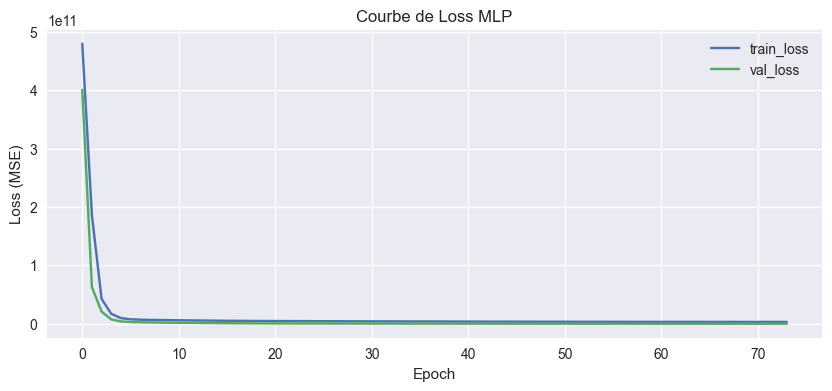

In [ ]:
#%pip install "tensorflow==2.10.0"

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt

# 1. Normalisation des features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_propre_num)
X_val_scaled   = scaler.transform(X_val_propre_num)
X_test_scaled  = scaler.transform(X_test_propre_num)

# 2. Construction du mod√®le MLP
mlp_model = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Sortie 1 dimension, r√©gression
])

mlp_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae']
)

# 3. Callbacks pour un entra√Ænement ‚Äúpropre‚Äù
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 4. Entra√Ænement du mod√®le
history = mlp_model.fit(
    X_train_scaled, y_train_propre,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=1024,
    callbacks=[early_stop],
    verbose=2
)

# 5. √âvaluation sur le set de test
y_pred_test_mlp = mlp_model.predict(X_test_scaled).flatten()
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_test_mlp))
mae_mlp  = mean_absolute_error(y_test, y_pred_test_mlp)
r2_mlp   = r2_score(y_test, y_pred_test_mlp)

print("\n===== √âvaluation du MLP sur le set de test =====")
print(f"RMSE  : {rmse_mlp:,.0f} ‚Ç¨")
print(f"MAE   : {mae_mlp:,.0f} ‚Ç¨")
print(f"R¬≤    : {r2_mlp:.4f}")

# 6. Affichage de la courbe d'apprentissage
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Courbe de Loss MLP')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


Analyse des r√©sultats du MLP :  

-   Convergence rapide : La courbe de loss montre une forte diminution en quelques epochs, puis une stabilisation des erreurs train/validation, preuve d‚Äôun bon apprentissage sans surapprentissage.
    -   Performances‚ÄØ:
        -   RMSE (test)‚ÄØ: ~7‚ÄØ500‚ÄØ‚Ç¨
        -   MAE (test)‚ÄØ: ~5‚ÄØ500‚ÄØ‚Ç¨
        -   R¬≤ (test)‚ÄØ: 0.9985  
        -   Ces scores indiquent que le MLP est performant, et est totalement en raccord aux mod√®les classiques (Random Forest, LightGBM‚Ä¶).

    -   Comparaison‚ÄØ: Le MLP offre une alternative efficace et stable pour la r√©gression tabulaire, mais les mod√®les d‚Äôensemble conservent un l√©ger avantage sur ce dataset, comme souvent en tabulaire.

    -   Conclusion‚ÄØ:  
    Le MLP ‚Äúfrom scratch‚Äù est un mod√®le robuste pour la t√¢che‚ÄØ: il apprend bien la structure des donn√©es et g√©n√©ralise correctement, avec un √©cart d‚Äôerreur raisonnable par rapport √† la baseline optimale.

Utilisation de TabNet (pytorch):

epoch 0  | loss: 494977480176.87463| val_0_rmse: 698476.94165|  0:00:24s
epoch 1  | loss: 477474653543.425| val_0_rmse: 679747.9499|  0:00:48s
epoch 2  | loss: 446874081676.25446| val_0_rmse: 654836.01553|  0:01:12s
epoch 3  | loss: 406929477768.9797| val_0_rmse: 621855.38002|  0:01:37s
epoch 4  | loss: 359509446880.3836| val_0_rmse: 573606.43299|  0:02:01s
epoch 5  | loss: 311237580571.2697| val_0_rmse: 525742.9811|  0:02:25s
epoch 6  | loss: 261228394174.69684| val_0_rmse: 482338.18987|  0:02:50s
epoch 7  | loss: 209707412182.83853| val_0_rmse: 407021.04107|  0:03:15s
epoch 8  | loss: 159634594365.41165| val_0_rmse: 387593.59565|  0:03:39s
epoch 9  | loss: 118974967157.40492| val_0_rmse: 340080.94509|  0:04:04s
epoch 10 | loss: 81179897206.3448| val_0_rmse: 211771.33872|  0:04:28s
epoch 11 | loss: 52440773489.32254| val_0_rmse: 251498.74719|  0:04:52s
epoch 12 | loss: 31090426152.86778| val_0_rmse: 67668.93905|  0:05:17s
epoch 13 | loss: 14954568458.11783| val_0_rmse: 102367.61988|  

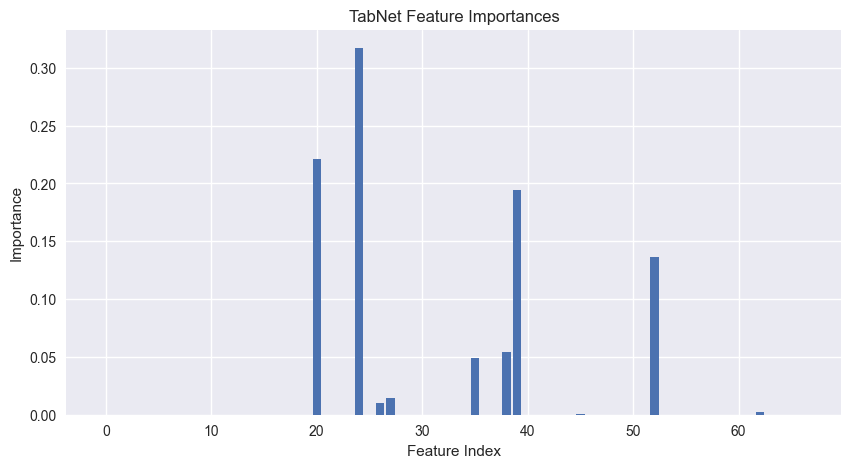

In [ ]:
# %pip install pytorch-tabnet

from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. Encodage des variables cat√©gorielles (automatique)
def encode_all_object_columns(X_train, X_val, X_test):
    X_train_enc = X_train.copy()
    X_val_enc = X_val.copy()
    X_test_enc = X_test.copy()
    for col in X_train_enc.select_dtypes(include=['object', 'category']).columns:
        le = LabelEncoder()
        # Fit sur train+val+test pour √©viter les valeurs inconnues
        full_list = (
            list(X_train_enc[col].astype(str).values) +
            list(X_val_enc[col].astype(str).values) +
            list(X_test_enc[col].astype(str).values)
        )
        le.fit(full_list)
        X_train_enc[col] = le.transform(X_train_enc[col].astype(str))
        X_val_enc[col]   = le.transform(X_val_enc[col].astype(str))
        X_test_enc[col]  = le.transform(X_test_enc[col].astype(str))
    return X_train_enc, X_val_enc, X_test_enc

# 2. Traitement automatique des colonnes datetime
def process_datetime_columns(X_train, X_val, X_test):
    X_train_new = X_train.copy()
    X_val_new = X_val.copy()
    X_test_new = X_test.copy()
    for col in X_train_new.columns:
        # Conversion auto si la colonne ressemble √† une date/heure
        if X_train_new[col].dtype == 'O' or 'date' in col.lower() or 'time' in col.lower():
            try:
                X_train_new[col] = pd.to_datetime(X_train_new[col])
                X_val_new[col] = pd.to_datetime(X_val_new[col])
                X_test_new[col] = pd.to_datetime(X_test_new[col])
            except Exception:
                continue
        if np.issubdtype(X_train_new[col].dtype, np.datetime64):
            for comp in ['year', 'month', 'day']:
                X_train_new[f"{col}_{comp}"] = getattr(X_train_new[col].dt, comp)
                X_val_new[f"{col}_{comp}"] = getattr(X_val_new[col].dt, comp)
                X_test_new[f"{col}_{comp}"] = getattr(X_test_new[col].dt, comp)
            X_train_new = X_train_new.drop(columns=[col])
            X_val_new = X_val_new.drop(columns=[col])
            X_test_new = X_test_new.drop(columns=[col])
    return X_train_new, X_val_new, X_test_new

# 3. Application des pr√©traitements
X_train_enc, X_val_enc, X_test_enc = encode_all_object_columns(X_train, X_val, X_test)
X_train_enc, X_val_enc, X_test_enc = process_datetime_columns(X_train_enc, X_val_enc, X_test_enc)

# 4. Conversion en numpy (et forcer les types en float32 pour √©viter les erreurs)
X_train_np = X_train_enc.values.astype(np.float32)
X_val_np   = X_val_enc.values.astype(np.float32)
X_test_np  = X_test_enc.values.astype(np.float32)
y_train_np = y_train.values.reshape(-1, 1).astype(np.float32) if hasattr(y_train, 'values') else y_train.reshape(-1, 1).astype(np.float32)
y_val_np   = y_val.values.reshape(-1, 1).astype(np.float32) if hasattr(y_val, 'values') else y_val.reshape(-1, 1).astype(np.float32)
y_test_np  = y_test.values.reshape(-1, 1).astype(np.float32) if hasattr(y_test, 'values') else y_test.reshape(-1, 1).astype(np.float32)

# 5. Entra√Ænement du mod√®le TabNet sur tout le jeu de donn√©es
tabnet = TabNetRegressor(
    n_d=16, n_a=16, n_steps=5, gamma=1.5, n_independent=2, n_shared=2,
    seed=42, verbose=1
)

tabnet.fit(
    X_train_np, y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    eval_metric=['rmse'],
    max_epochs=50,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# 6. Pr√©diction et √©valuation sur le set de test
y_pred_tabnet = tabnet.predict(X_test_np).ravel()

rmse_tabnet = np.sqrt(mean_squared_error(y_test_np, y_pred_tabnet))
mae_tabnet  = mean_absolute_error(y_test_np, y_pred_tabnet)
r2_tabnet   = r2_score(y_test_np, y_pred_tabnet)

print("===== √âvaluation TabNet sur le set de test =====")
print(f"RMSE  : {rmse_tabnet:,.0f} ‚Ç¨")
print(f"MAE   : {mae_tabnet:,.0f} ‚Ç¨")
print(f"R¬≤    : {r2_tabnet:.4f}")

# 7. Affichage importance des variables TabNet
feature_importances = tabnet.feature_importances_
plt.figure(figsize=(10, 5))
plt.bar(range(len(feature_importances)), feature_importances)
plt.title("TabNet Feature Importances")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

TabNet a √©t√© entra√Æn√© sur notre jeu de donn√©es apr√®s encodage automatique des variables cat√©gorielles et traitement des dates.  
Le mod√®le obtient d‚Äôexcellentes performances (RMSE ‚âà 5‚ÄØ742‚ÄØ‚Ç¨, MAE ‚âà 4‚ÄØ191‚ÄØ‚Ç¨, R¬≤ ‚âà 0.9991) sur le jeu de test.  
La distribution des importances montre que le mod√®le exploite principalement quelques variables cl√©s, tout comme nos tests le montraient pr√©c√©dement.  
TabNet √©gale ainsi les autres mod√®les du projet, tout en restant facilement interpr√©table gr√¢ce √† la visualisation des features importantes.

## 5. Justification des choix des mod√®les :

1. Random Forest (Baseline traditionnelle) -  
Le Random Forest est un mod√®le d‚Äôensemble √©prouv√© pour la r√©gression sur donn√©es tabulaires. Il offre une grande robustesse aux donn√©es bruit√©es et g√®re tr√®s bien les relations non-lin√©aires entre variables. Utilis√© comme baseline, il permet de fixer un seuil de performance r√©aliste, √† comparer avec les approches de deep learning. Son principal avantage est la simplicit√© de mise en ≈ìuvre et l‚Äôinterpr√©tabilit√© relative (importance des variables).

2. MLP (Multi-Layer Perceptron) ‚Äì Deep Learning standard -  
Le MLP repr√©sente la forme la plus simple des r√©seaux de neurones pour la r√©gression. Il a l‚Äôavantage de pouvoir approximer des fonctions complexes, notamment lorsqu‚Äôil existe de multiples relations non-lin√©aires dans les donn√©es. Cependant, il ne tient pas compte explicitement de la structure des donn√©es tabulaires (absence de prise en compte de la sparsit√© ou de l‚Äôinteraction naturelle des colonnes comme le fait un arbre de d√©cision), ce qui en limite parfois la performance face √† des mod√®les sp√©cifiquement con√ßus pour le tabulaire.

3. TabNet ‚Äì Deep Learning pour donn√©es tabulaires -  
TabNet est un mod√®le de deep learning sp√©cialement con√ßu pour les donn√©es tabulaires. Il combine la capacit√© d‚Äôapprentissage profond avec un m√©canisme d‚Äôattention qui s√©lectionne dynamiquement les variables les plus pertinentes √† chaque √©tape de l‚Äôentra√Ænement. Ce m√©canisme, inspir√© des arbres de d√©cision, permet √† TabNet d‚Äô√©galer voire de surpasser les performances des meilleurs mod√®les d‚Äôarbres sur des donn√©es structur√©es, tout en offrant une meilleure capacit√© de g√©n√©ralisation et d‚Äôinterpr√©tabilit√© (importance des features). Il s‚Äôadapte bien √† de grands volumes de donn√©es tabulaires h√©t√©rog√®nes.

En r√©sum√© nous avons pu voir et comparer :  
-   Un mod√®le classique de r√©f√©rence (RandomForest)
-   Un r√©seau de neurones standard (MLP)
-   Un mod√®le deep tabulaire (TabNet) 

Ce qui nous donne :  

-   RandomForest : RMSE de 618‚ÄØ‚Ç¨, un MAE de 194‚ÄØ‚Ç¨ et un R¬≤ de 1.0000.
-   MLP : RMSE de 7‚ÄØ469‚ÄØ‚Ç¨, un MAE de 5‚ÄØ484‚ÄØ‚Ç¨ et un R¬≤ de 0.9985.
-   TabNet : RMSE de 5‚ÄØ742‚ÄØ‚Ç¨, un MAE de 4‚ÄØ191‚ÄØ‚Ç¨ et un R¬≤ de 0.9991.



## 6. Pr√©diction sur 2025

In [ ]:
import datetime
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# 1. G√©n√©ration du jeu de donn√©es 2025
df_2025 = df_2_processed.copy()

def safe_replace_year(date, year):
    try:
        return date.replace(year=year)
    except ValueError:
        if date.month == 2 and date.day == 29:
            return date.replace(year=year, day=28)
        else:
            return None

# Date mutation ‚Üí 2025
df_2025['date_mutation'] = df_2025['date_mutation'].apply(
    lambda x: safe_replace_year(x, 2025) if hasattr(x, "year") else x
)
df_2025['annee'] = 2025

# 2. Pipeline identique au preprocessing train/test
df_2025 = add_departement_col(df_2025)

df_2025 = pd.merge(
    df_2025,
    aggregats_dept,   # Calcul√©s sur TRAIN uniquement !
    on="departement",
    how="left"
)

# 3. Colonnes √† √©carter (jamais utilisables sans la target)
leakage_cols = [
    'ratio_prix_dept', 'dept_valeur_fonciere_mean', 'dept_valeur_fonciere_median',
    'dept_valeur_fonciere_std', 'dept_valeur_fonciere_count', 'dept_surface_reelle_bati_mean',
    'dept_surface_reelle_bati_median', 'dept_densite_transactions', 'dept_prix_x_surface'
]
df_2025 = df_2025.drop(columns=[col for col in leakage_cols if col in df_2025.columns])

# 4. S√©lection des features d'entra√Ænement

X_train_final = X_train_propre_num.drop(columns=[col for col in leakage_cols if col in X_train_propre_num.columns], errors='ignore')
y_train_final = y_train_propre

df_2025_num = df_2025.select_dtypes(include=[np.number]).copy()
df_2025_num = df_2025_num.reindex(columns=X_train_final.columns, fill_value=0)

# 5. Entra√Ænement d'un mod√®le propre
rf_final = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_final.fit(X_train_final, y_train_final)

# 6. Pr√©diction sur 2025
y_pred_2025 = rf_final.predict(df_2025_num)
df_2025['valeur_fonciere_predite'] = y_pred_2025

Test des valeurs, en sachant que nous sommes sur le mod√®le random forest entrain√© sur le dataframe 2, c'est √† dire les valeurs de 470 000 √† 1.3M d'euros.

In [85]:
print("Prix foncier m√©dian (pr√©dit 2025):", df_2025['valeur_fonciere_predite'].median())
print("Prix foncier moyen (pr√©dit 2025):", df_2025['valeur_fonciere_predite'].mean())

Prix foncier m√©dian (pr√©dit 2025): 614883.7539473415
Prix foncier moyen (pr√©dit 2025): 677970.3226842477


Visualisation des moyennes des d√©partements du plus grand au plus petit.

In [86]:
print(df_2025.groupby('departement')['valeur_fonciere_predite'].mean().sort_values(ascending=False))

departement
75    742142.559609
92    716405.375353
00    715139.723599
06    707672.944757
15    700042.085535
          ...      
65    602874.696155
19    602236.091960
09    599902.814705
72    598055.871537
43    577687.155477
Name: valeur_fonciere_predite, Length: 94, dtype: float64


Distribution des valeurs fonci√®res. Ces valeurs suivent bien la courbe du dataframe2 vu pr√©c√©dement.

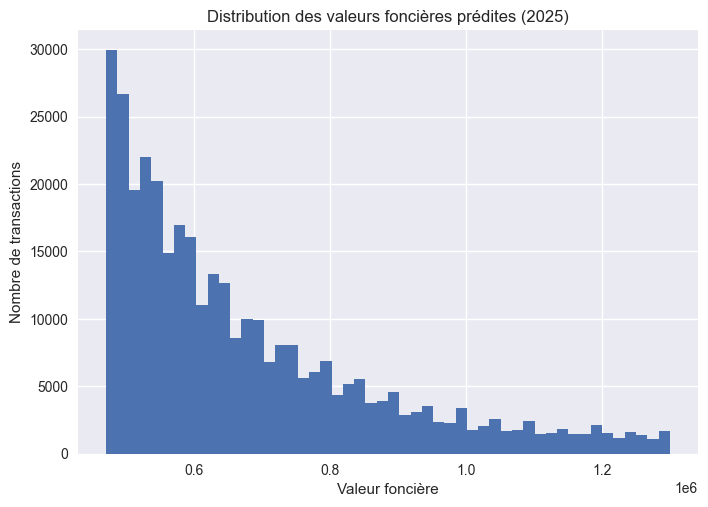

In [87]:
import matplotlib.pyplot as plt
plt.hist(df_2025['valeur_fonciere_predite'], bins=50)
plt.title("Distribution des valeurs fonci√®res pr√©dites (2025)")
plt.xlabel("Valeur fonci√®re")
plt.ylabel("Nombre de transactions")
plt.show()


Description simple du nouveau dataset :

In [89]:
print(df_2025_num.describe().T)


                              count           mean            std  \
nombre_pieces_principales  348660.0       4.273040       1.637452   
surface_reelle_bati        348660.0     111.466288      50.877505   
annee                      348660.0    2025.000000       0.000000   
mois                       348660.0       6.758068       3.339507   
trimestre                  348660.0       2.578050       1.088337   
jour_semaine               348660.0       2.193171       1.466446   
jour_annee                 348660.0     191.433173     101.813830   
mois_sin                   348660.0      -0.066009       0.691181   
mois_cos                   348660.0      -0.041939       0.718440   
jour_semaine_sin           348660.0       0.282411       0.540398   
jour_semaine_cos           348660.0      -0.158497       0.776592   
jours_depuis_debut         348660.0     751.735152     386.139528   
prix_m2                    348660.0    7819.559267    7774.163938   
log_surface                348660.

Comparaison entre le dataframe 2 et notre pr√©diction sur 2025 :

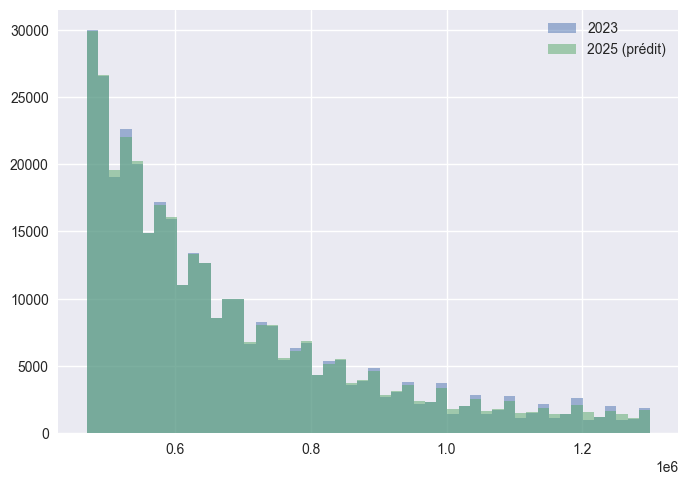

In [92]:
plt.hist(df_2_processed['valeur_fonciere'], bins=50, alpha=0.5, label='2023')
plt.hist(df_2025['valeur_fonciere_predite'], bins=50, alpha=0.5, label='2025 (pr√©dit)')
plt.legend()
plt.show()


Comparaison sous forme de tableau entre notre jeu de donn√©e de base et notre pr√©diction :

In [ ]:
df_seg2 = df_2[(df_2['valeur_fonciere'] >= 500_000) & (df_2['valeur_fonciere'] < 1_300_000)].copy()

def compare_real_vs_pred(df_real, df_pred, 
                        name_real="Haut gamme 2023-2024", 
                        name_pred="Pr√©diction 2025 segment 2"):
    print("1. COMPARAISON DES STATISTIQUES G√âN√âRALES")
    print("="*60)
    stats_comparison = pd.DataFrame({
        name_real: [
            df_real.shape[0],
            df_real['valeur_fonciere'].mean(),
            df_real['valeur_fonciere'].median(),
            df_real['valeur_fonciere'].std(),
            df_real['surface_reelle_bati'].mean() if 'surface_reelle_bati' in df_real.columns else np.nan
        ],
        name_pred: [
            df_pred.shape[0],
            df_pred['valeur_fonciere_predite'].mean(),
            df_pred['valeur_fonciere_predite'].median(),
            df_pred['valeur_fonciere_predite'].std(),
            df_pred['surface_reelle_bati'].mean() if 'surface_reelle_bati' in df_pred.columns else np.nan
        ]
    }, index=[
        'Nombre de transactions',
        'Prix moyen (‚Ç¨)',
        'Prix m√©dian (‚Ç¨)',
        '√âcart-type prix',
        'Surface moyenne (m¬≤)'
    ])
    print(stats_comparison.round(0))
    return stats_comparison

compare_real_vs_pred(df_seg2, df_2025)


1. COMPARAISON DES STATISTIQUES G√âN√âRALES
                        Haut gamme 2023-2024  Pr√©diction 2025 segment 2
Nombre de transactions              300435.0                   348660.0
Prix moyen (‚Ç¨)                      706766.0                   677970.0
Prix m√©dian (‚Ç¨)                     646735.0                   614884.0
√âcart-type prix                     190418.0                   195172.0
Surface moyenne (m¬≤)                   112.0                      111.0


Haut gamme 2023-2024  Pr√©diction 2025 segment 2
Nombre de transactions         300435.000000              348660.000000
Prix moyen (‚Ç¨)                 706765.658552              677970.322684
Prix m√©dian (‚Ç¨)                646735.000000              614883.753947
√âcart-type prix                190418.210030              195171.654179
Surface moyenne (m¬≤)              112.489320                 111.466288

Comparatif des distributions entre les deux datasets :

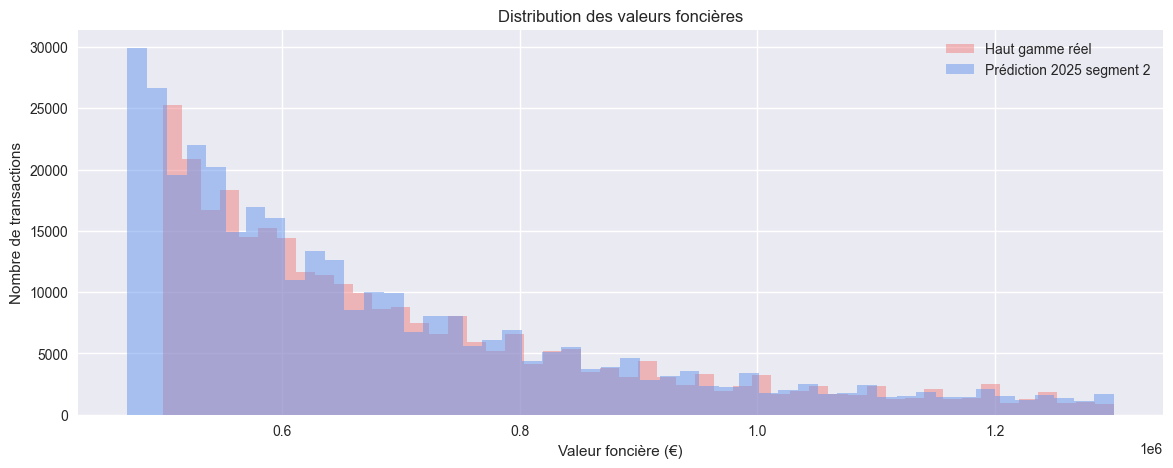

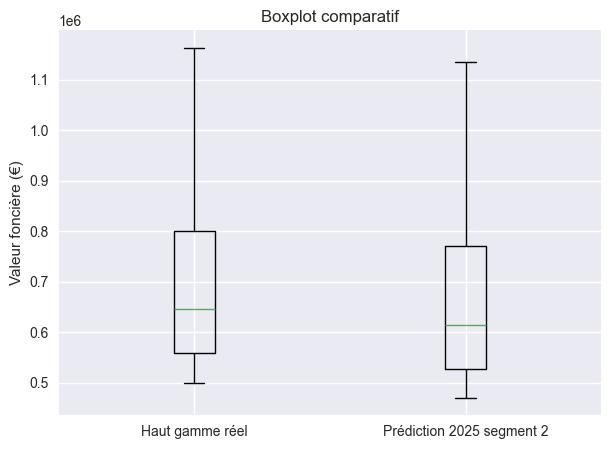

In [99]:
def plot_real_vs_pred_distributions(df_real, df_pred,
                                   name_real="Haut gamme r√©el",
                                   name_pred="Pr√©diction 2025 segment 2"):
    plt.figure(figsize=(14, 5))
    plt.hist(df_real['valeur_fonciere'], bins=50, alpha=0.5, label=name_real, color='lightcoral')
    plt.hist(df_pred['valeur_fonciere_predite'], bins=50, alpha=0.5, label=name_pred, color='cornflowerblue')
    plt.xlabel('Valeur fonci√®re (‚Ç¨)')
    plt.ylabel('Nombre de transactions')
    plt.title('Distribution des valeurs fonci√®res')
    plt.legend()
    plt.show()
    
    # Boxplot
    plt.figure(figsize=(7,5))
    plt.boxplot([df_real['valeur_fonciere'], df_pred['valeur_fonciere_predite']],
                labels=[name_real, name_pred], showfliers=False)
    plt.ylabel('Valeur fonci√®re (‚Ç¨)')
    plt.title('Boxplot comparatif')
    plt.show()

plot_real_vs_pred_distributions(df_seg2, df_2025)

Diff√©rences entre les regressions lin√©aires :

Prix au m¬≤ moyen (r√©el): 8101 ‚Ç¨
Prix au m¬≤ moyen (pr√©dit): 7821 ‚Ç¨


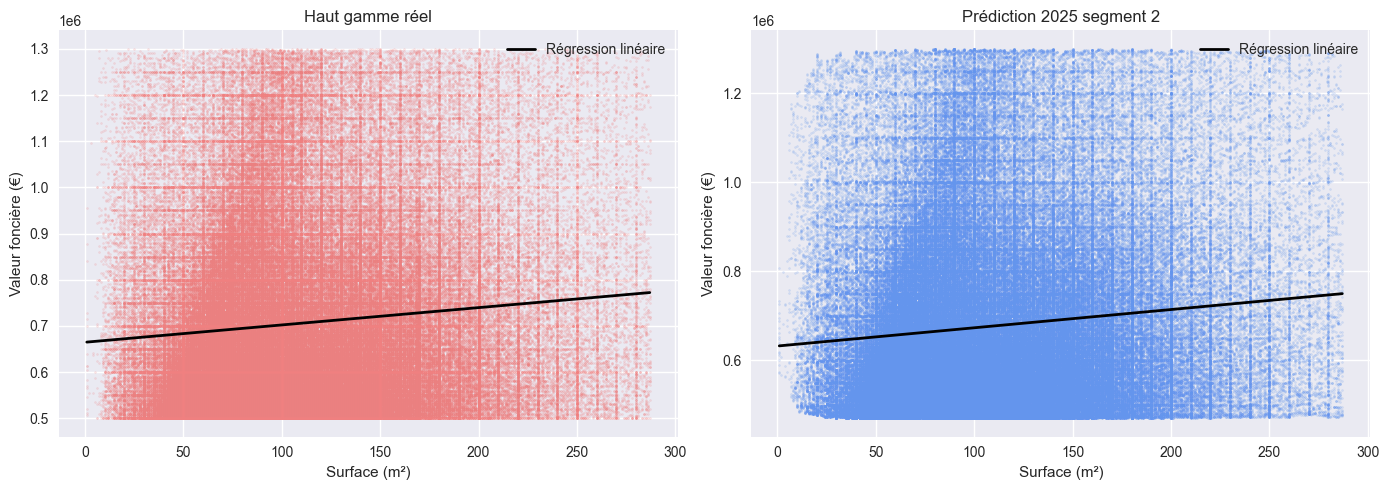

In [100]:
def plot_surface_price_relation(df_real, df_pred,
                               name_real="Haut gamme r√©el",
                               name_pred="Pr√©diction 2025 segment 2"):
    # Nettoyage (pas de division par z√©ro)
    df_real_clean = df_real[df_real['surface_reelle_bati'] > 0].copy()
    df_pred_clean = df_pred[df_pred['surface_reelle_bati'] > 0].copy()
    # Prix au m¬≤
    df_real_clean['prix_m2'] = df_real_clean['valeur_fonciere'] / df_real_clean['surface_reelle_bati']
    df_pred_clean['prix_m2'] = df_pred_clean['valeur_fonciere_predite'] / df_pred_clean['surface_reelle_bati']
    # Affichage moyens
    print(f"Prix au m¬≤ moyen (r√©el): {df_real_clean['prix_m2'].mean():.0f} ‚Ç¨")
    print(f"Prix au m¬≤ moyen (pr√©dit): {df_pred_clean['prix_m2'].mean():.0f} ‚Ç¨")
    # Nuages + r√©gressions
    fig, axes = plt.subplots(1, 2, figsize=(14,5))
    for i, (df, y_col, label, color) in enumerate([
        (df_real_clean, 'valeur_fonciere', name_real, 'lightcoral'),
        (df_pred_clean, 'valeur_fonciere_predite', name_pred, 'cornflowerblue')
    ]):
        x = df['surface_reelle_bati'].values
        y = df[y_col].values
        axes[i].scatter(x, y, alpha=0.2, s=2, color=color)
        axes[i].set_xlabel('Surface (m¬≤)')
        axes[i].set_ylabel('Valeur fonci√®re (‚Ç¨)')
        axes[i].set_title(label)
        # R√©gression lin√©aire
        if len(x) > 1:
            coef = np.polyfit(x, y, deg=1)
            x_line = np.array([x.min(), x.max()])
            y_line = coef[0]*x_line + coef[1]
            axes[i].plot(x_line, y_line, color='k', lw=2, label='R√©gression lin√©aire')
            axes[i].legend()
    plt.tight_layout()
    plt.show()

plot_surface_price_relation(df_seg2, df_2025)


Diff√©rences et comparaison sous forme d'histogramme en barres :

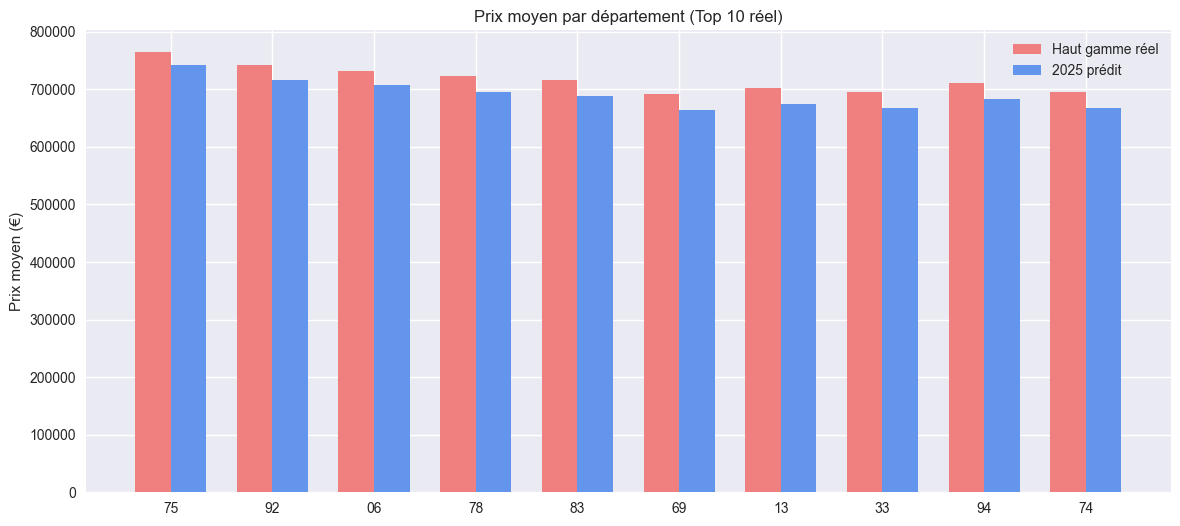

(departement
 00    715162.500000
 01    681872.118993
 02    665177.031250
 03    675869.151613
 04    694985.799107
           ...      
 92    742293.888845
 93    677924.273319
 94    710048.888677
 95    641561.172175
 97    679578.108463
 Name: valeur_fonciere, Length: 94, dtype: float64,
 departement
 00    715139.723599
 01    655871.308338
 02    615996.872228
 03    626125.633217
 04    666909.485341
           ...      
 92    716405.375353
 93    647116.284889
 94    683506.456859
 95    610540.602212
 97    649161.638855
 Name: valeur_fonciere_predite, Length: 94, dtype: float64)

In [101]:
def add_departement_col(df):
    temp = df.copy()
    temp['code_postal'] = temp['code_postal'].astype(str).str.zfill(5)
    temp['departement'] = temp['code_postal'].str[:2]
    return temp

def compare_geographic(df_real, df_pred, name_real="Haut gamme r√©el", name_pred="2025 pr√©dit"):
    df_real_geo = add_departement_col(df_real)
    df_pred_geo = add_departement_col(df_pred)
    # Calcul du prix moyen par d√©partement
    real_stats = df_real_geo.groupby('departement')['valeur_fonciere'].mean()
    pred_stats = df_pred_geo.groupby('departement')['valeur_fonciere_predite'].mean()
    real_count = df_real_geo.groupby('departement').size()
    pred_count = df_pred_geo.groupby('departement').size()
    # Top 10 d√©partements en nombre de transactions (pour l'affichage)
    top_real = real_count.sort_values(ascending=False).head(10).index
    top_pred = pred_count.sort_values(ascending=False).head(10).index
    # Comparaison graphique
    plt.figure(figsize=(14,6))
    width = 0.35
    x = np.arange(len(top_real))
    plt.bar(x-width/2, real_stats[top_real], width, label=name_real, color='lightcoral')
    plt.bar(x+width/2, pred_stats[top_real], width, label=name_pred, color='cornflowerblue')
    plt.xticks(x, top_real)
    plt.ylabel('Prix moyen (‚Ç¨)')
    plt.title('Prix moyen par d√©partement (Top 10 r√©el)')
    plt.legend()
    plt.show()
    # Optionnel : retourner les DataFrames agr√©g√©s
    return real_stats, pred_stats

compare_geographic(df_seg2, df_2025)


Envoi de notre dataframe sous forme de CSV pour pouvoir avoir une lecture des donn√©es dans notre application Streamlit.

In [102]:
df_2025.to_csv("predictions_immobilier_2025.csv", index=False)